In [1]:
!pip install pmdarima


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import statsmodels.api as sm
import yfinance as yf
import datetime
from sklearn.metrics import silhouette_score
import networkx as nx
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.colors as mcolors
import cvxpy as cp
from pypfopt import EfficientFrontier, risk_models, expected_returns, EfficientCVaR
import numpy as np
from numpy import cumsum, log, polyfit, sqrt, std, subtract
import pandas_datareader
from arch import arch_model
import itertools
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from scipy.stats import skew, kurtosis
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
import hvplot.pandas
from sklearn.preprocessing import StandardScaler
from pandas.plotting import table
from scipy.stats import t, norm
from statsmodels.tsa.arima.model import ARIMA
from matplotlib.colors import LinearSegmentedColormap
import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from sklearn.metrics import mean_squared_error
from scipy.stats import probplot, moment
from scipy import stats
import sys
from pylab import rcParams 
from pmdarima import auto_arima
import pmdarima as pm
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm
from scipy.optimize import linprog
from arch.univariate.distribution import SkewStudent
from joblib import Parallel, delayed
import multiprocessing
import concurrent.futures
from concurrent.futures import ThreadPoolExecutor, as_completed
from scipy.optimize import minimize

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

## *** Importing list of Tickers from SP1500, Pulled from top 100 of the index based on market cap ***  


In [4]:
sp1500_tickers=pd.read_csv('SP1500.csv')
sp1500_tickers.head()

Ticker
0   AAPL.OQ
1   MSFT.OQ
2   NVDA.OQ
3  GOOGL.OQ
4   GOOG.OQ

In [5]:
# After loading SP1500 tickers
sp1500_tickers = pd.read_csv('SP1500.csv')
ticker_list = sp1500_tickers['Ticker'].tolist()

# 🚨 Remove any problematic tickers containing 'BRK'
ticker_list = [t for t in ticker_list if 'BRK' not in t]

# Optional: Reassign the cleaned list back to DataFrame if needed
sp1500_tickers = pd.DataFrame({'Ticker': ticker_list})

# ✅ Confirm cleaning worked
print('BRK present after cleaning?', any('BRK' in t for t in ticker_list))


BRK present after cleaning? False


In [6]:
ticker_list=sp1500_tickers['Ticker'].tolist()
print(ticker_list)

['AAPL.OQ', 'MSFT.OQ', 'NVDA.OQ', 'GOOGL.OQ', 'GOOG.OQ', 'AMZN.OQ', 'META.OQ', 'AVGO.OQ', 'TSLA.OQ', 'WMT.N', 'LLY.N', 'V.N', 'JPM.N', 'UNH.N', 'MA.N', 'XOM.N', 'COST.OQ', 'NFLX.OQ', 'PG.N', 'JNJ.N', 'ORCL.N', 'HD.N', 'KO.N', 'ABBV.N', 'TMUS.OQ', 'BAC.N', 'PM.N', 'CRM.N', 'CVX.N', 'ABT.N', 'CSCO.OQ', 'IBM.N', 'MCD.N', 'PLTR.OQ', 'LIN.OQ', 'WFC.N', 'GE.N', 'T.N', 'MRK.N', 'PEP.OQ', 'VZ.N', 'ACN.N', 'AXP.N', 'MS.N', 'RTX.N', 'ISRG.OQ', 'NOW.N', 'TMO.N', 'INTU.OQ', 'PGR.N', 'BX.N', 'GS.N', 'UBER.N', 'AMGN.OQ', 'QCOM.OQ', 'DIS.N', 'BKNG.OQ', 'ADBE.OQ', 'AMD.OQ', 'SPGI.N', 'TJX.N', 'BSX.N', 'CAT.N', 'SCHW.N', 'DHR.N', 'NEE.N', 'BLK.N', 'TXN.OQ', 'SYK.N', 'GILD.OQ', 'UNP.N', 'CMCSA.OQ', 'PFE.N', 'VRTX.OQ', 'HON.OQ', 'DE.N', 'LOW.N', 'ADP.OQ', 'BA.N', 'FI.N', 'C.N', 'CB.N', 'MMC.N', 'PANW.OQ', 'AMAT.OQ', 'LMT.N', 'COP.N', 'MDT.N', 'ETN.N', 'AMT.N', 'BMY.N', 'SO.N', 'ELV.N', 'MO.N', 'WELL.N', 'CME.OQ', 'CRWD.OQ', 'DUK.N', 'PLD.N']


***Importing the Raw Data from LSEG Workspace*** 

In [296]:
import eikon as ek
import pandas as pd

# Load the tickers
sp1500_tickers = pd.read_csv('Downloads/SP1500.csv')

# Assuming the column is named 'Ticker'
ticker_list = sp1500_tickers['Ticker'].dropna().astype(str).tolist()
print(f"✅ Fetched {len(ticker_list)} tickers.")

# Set your Eikon App Key
ek.set_app_key('74a3d98fed1b4f078464ea6207bc5b3cfb5ec9b2')

# Fields to fetch
fields = [
    'TR.CommonName',
    'TR.Instrument',
    'TR.EnvironmentPillarScore.date',
    'TR.EnvironmentPillarScore',
    'TR.TRBCEconomicSector'
]

# Parameters
params = {'SDate': 'FY0', 'EDate': -8}

# Fetch data
df_raw, err = ek.get_data(ticker_list, fields, parameters=params)

# Process data
if df_raw is not None and not df_raw.empty:
    # Now, correctly check for 'Date'!
    if 'Date' in df_raw.columns:
        df_raw['Date'] = pd.to_datetime(df_raw['Date'])
        df_raw['Year'] = df_raw['Date'].dt.year
        df_raw.drop('Date', axis=1, inplace=True)
    else:
        print("⚠️ Warning: 'Date' column missing!")

    # Rename columns
    df_raw.rename(columns={
        'TRBC Economic Sector Name': 'Industry',
        'Instrument': 'Ticker',
        'Company Common Name': 'Company',
        'Environmental Pillar Score': 'E Score'
    }, inplace=True)

    print(df_raw.head(20))

else:
    print("❌ Error: No data retrieved from Eikon.")



✅ Fetched 100 tickers.


2025-04-28 21:05:32,940 P[6812] [MainThread 9968] Error: no proxy address identified.
Check if Eikon Desktop or Eikon API Proxy is running.
2025-04-28 21:05:34,994 P[6812] [MainThread 9968] Error on handshake url http://127.0.0.1:9000/api/handshake : ConnectError('All connection attempts failed')
2025-04-28 21:05:34,994 P[6812] [MainThread 9968] Error on handshake url http://127.0.0.1:9000/api/handshake : ConnectError('All connection attempts failed')
2025-04-28 21:05:34,994 P[6812] [MainThread 9968] Port number was not identified, cannot send any request
2025-04-28 21:05:37,034 P[6812] [MainThread 9968] Eikon Proxy not running or cannot be reached. Please read the documentation on troubleshooting


EikonError: Error code 401 | Eikon Proxy not running or cannot be reached. Please read the documentation on troubleshooting

In [9]:
df_raw['Ticker'].nunique()

100

In [10]:
df_raw.columns

Index(['Ticker', 'Company', 'E Score', 'Industry', 'Year'], dtype='object')

In [11]:
df_raw.shape

(899, 5)

In [12]:
#raw data saved
df_raw.to_csv('Raw_DataSP1500.csv')

***Cleaning Time***

In [298]:
df_raw=pd.read_csv('Raw_DataSP1500.csv',index_col=[0])
df_raw.head(20)

Ticker         Company    E Score    Industry  Year
0   AAPL.OQ       Apple Inc  66.501035  Technology  2023
1   AAPL.OQ             NaN  66.911080         NaN  2022
2   AAPL.OQ             NaN  65.550560         NaN  2021
3   AAPL.OQ             NaN  64.601399         NaN  2020
4   AAPL.OQ             NaN  61.005273         NaN  2019
5   AAPL.OQ             NaN  58.197813         NaN  2018
6   AAPL.OQ             NaN  56.239479         NaN  2017
7   AAPL.OQ             NaN  52.830211         NaN  2016
8   AAPL.OQ             NaN  51.787648         NaN  2015
9   MSFT.OQ  Microsoft Corp  78.101233  Technology  2023
10  MSFT.OQ             NaN  78.197286         NaN  2022
11  MSFT.OQ             NaN  77.961238         NaN  2021
12  MSFT.OQ             NaN  77.801823         NaN  2020
13  MSFT.OQ             NaN  77.524426         NaN  2019
14  MSFT.OQ             NaN  76.755615         NaN  2018
15  MSFT.OQ             NaN  77.613153         NaN  2017
16  MSFT.OQ             NaN  79.751516         NaN  2016
17  MSFT.OQ             NaN  80.751916         NaN  2015
18  NVDA.OQ     NVIDIA Corp  68.164584  Technology  2024
19  NVDA.OQ             NaN  66.932463         NaN  2023

In [15]:
df_raw['Ticker'] = df_raw['Ticker'].str.split('.').str[0]
df_raw['Ticker'] = df_raw['Ticker'].replace({'BRKb': 'BRK-B'})

invalid_tickers = df_raw[df_raw['E Score'].isna() | (df_raw['E Score'] == 0)]['Ticker'].unique()

tickers_to_drop = list(invalid_tickers) + ['GOOG', 'BRK', 'BRK-B']


df = df_raw[~df_raw['Ticker'].isin(tickers_to_drop)].reset_index(drop=True)


print("Tickers dropped due to invalid E Score or manual exclusion:")
print(sorted(tickers_to_drop))

df.head()

Tickers dropped due to invalid E Score or manual exclusion:
['BKNG', 'BRK', 'BRK-B', 'BX', 'CRWD', 'FI', 'GOOG', 'NFLX', 'NOW', 'PANW', 'PLTR', 'UBER']


Ticker    Company    E Score    Industry  Year
0   AAPL  Apple Inc  66.501035  Technology  2023
1   AAPL        NaN  66.911080         NaN  2022
2   AAPL        NaN  65.550560         NaN  2021
3   AAPL        NaN  64.601399         NaN  2020
4   AAPL        NaN  61.005273         NaN  2019

In [16]:
df['Ticker'].nunique()

89

In [17]:
all_tickers_before = set(df['Ticker'].unique())

# Get tickers that have 2023 data
tickers_with_2023 = set(df[df['Year'] == 2023]['Ticker'].unique())

# Find which tickers will be dropped due to missing 2023 data
tickers_dropped_2023 = sorted(all_tickers_before - tickers_with_2023)

# Print them
print("Tickers dropped due to missing E Score data for 2023:")
print(tickers_dropped_2023)

# Then filter the DataFrame
df = df[df['Ticker'].isin(tickers_with_2023)].reset_index(drop=True)

Tickers dropped due to missing E Score data for 2023:
['KO']


In [18]:
# View dropped tickers
dropped_tickers = sorted(set(df_raw['Ticker'].unique()) - set(df['Ticker'].unique()))
print("Dropped tickers:")
print(dropped_tickers)

Dropped tickers:
['BKNG', 'BRK-B', 'BX', 'CRWD', 'FI', 'GOOG', 'KO', 'NFLX', 'NOW', 'PANW', 'PLTR', 'UBER']


In [19]:
df['Ticker'].nunique()

88

In [20]:
df['Ticker'] = df['Ticker'].str.split('.').str[0]

# Fix specific naming cases, like BRKb -> BRK
df['Ticker'] = df['Ticker'].replace({'BRKb': 'BRK-B'})  # Add any more if needed
df.head()



Ticker    Company    E Score    Industry  Year
0   AAPL  Apple Inc  66.501035  Technology  2023
1   AAPL        NaN  66.911080         NaN  2022
2   AAPL        NaN  65.550560         NaN  2021
3   AAPL        NaN  64.601399         NaN  2020
4   AAPL        NaN  61.005273         NaN  2019

In [21]:
#Fill in company name and industry for tickers
company_map = df.dropna(subset=['Company']).groupby('Ticker')['Company'].first()
industry_map = df.dropna(subset=['Industry']).groupby('Ticker')['Industry'].first()

# Step 2: Map those values back into the DataFrame
df['Company'] = df['Ticker'].map(company_map)
df['Industry'] = df['Ticker'].map(industry_map)
df.head()

Ticker    Company    E Score    Industry  Year
0   AAPL  Apple Inc  66.501035  Technology  2023
1   AAPL  Apple Inc  66.911080  Technology  2022
2   AAPL  Apple Inc  65.550560  Technology  2021
3   AAPL  Apple Inc  64.601399  Technology  2020
4   AAPL  Apple Inc  61.005273  Technology  2019

In [22]:
#Drop if there is data in the years 2015 or 2024 to align dates
df = df[~df['Year'].isin([2024, 2015])]

df.head()

Ticker    Company    E Score    Industry  Year
0   AAPL  Apple Inc  66.501035  Technology  2023
1   AAPL  Apple Inc  66.911080  Technology  2022
2   AAPL  Apple Inc  65.550560  Technology  2021
3   AAPL  Apple Inc  64.601399  Technology  2020
4   AAPL  Apple Inc  61.005273  Technology  2019

In [23]:
df.shape

(704, 5)

****Exporting Cleaned Data to CSV path****

In [25]:
df.to_csv('Clean_Data_SP1500.csv')

****preClustering****

In [27]:
df_clean=pd.read_csv('Clean_Data_SP1500.csv',index_col=[0])
df_clean.head()

Ticker    Company    E Score    Industry  Year
0   AAPL  Apple Inc  66.501035  Technology  2023
1   AAPL  Apple Inc  66.911080  Technology  2022
2   AAPL  Apple Inc  65.550560  Technology  2021
3   AAPL  Apple Inc  64.601399  Technology  2020
4   AAPL  Apple Inc  61.005273  Technology  2019

In [28]:
summary_stats = df_clean.groupby('Ticker')['E Score'].agg(
    Min='min',
    Max='max',
    Mean='mean',
    Std='std',
    Skew=lambda x: skew(x, bias=False),
    Kurt=lambda x: kurtosis(x, bias=False)
).reset_index()

def color_mean(val):
    # Normalize val between 0 and 1
    norm = (val - summary_stats['Mean'].min()) / (summary_stats['Mean'].max() - summary_stats['Mean'].min())
    # Convert norm to a gradient color
    from matplotlib import colors
    cmap = colors.LinearSegmentedColormap.from_list('custom', ['brown', 'yellow', 'lightgreen', 'green'])
    rgb = cmap(norm)[:3]
    hex_color = colors.rgb2hex(rgb)
    return f'background-color: {hex_color}'

# Apply the coloring to the Mean column
data_summary = summary_stats.style.map(color_mean, subset=['Mean'])
print("Summary Statistics for Cleaned Data:\n")
data_summary

Summary Statistics for Cleaned Data:



****Clustering****

✅ Firms with complete ESG coverage: 87

Average Silhouette Scores Across All Years:
   K  Average_Silhouette
0  2            0.654712
1  3            0.552089
2  4            0.572414
3  5            0.581954
4  6            0.564482
5  7            0.556811
6  8            0.545464
7  9            0.555522


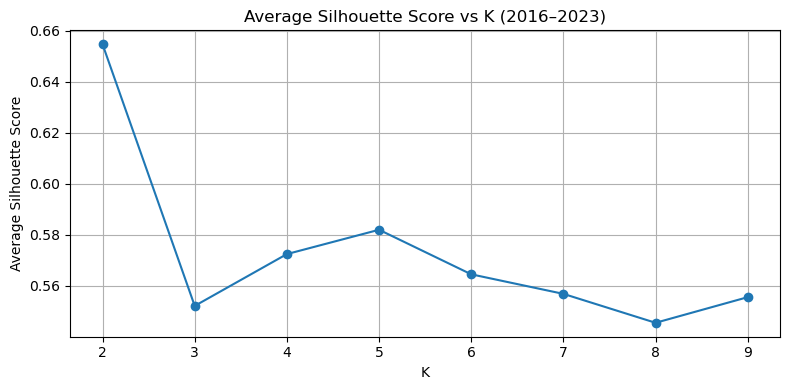

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from matplotlib.colors import LinearSegmentedColormap
import warnings

warnings.filterwarnings("ignore")

# Load ESG data
df_clean = pd.read_csv("Clean_Data_SP1500.csv")

# ✅ Keep only firms with full coverage
years_required = set(range(2016, 2024))
ticker_years = df_clean.groupby('Ticker')['Year'].apply(set)
consistent_tickers = ticker_years[ticker_years.apply(lambda x: years_required.issubset(x))].index.tolist()
df_clean = df_clean[df_clean['Ticker'].isin(consistent_tickers)].copy()
print(f"✅ Firms with complete ESG coverage: {len(consistent_tickers)}")

# 📊 Silhouette summary table for global K decision
silhouette_summary = []

for k in range(2, 10):
    sil_scores = []
    for year in sorted(df_clean['Year'].unique()):
        df_year = df_clean[df_clean['Year'] == year].copy()
        if df_year['E Score'].isnull().all():
            continue

        scaler = StandardScaler()
        x_scaled = scaler.fit_transform(df_year[['E Score']])

        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(x_scaled)

        sil = silhouette_score(x_scaled, labels)
        sil_scores.append(sil)

    avg_sil = np.mean(sil_scores)
    silhouette_summary.append({'K': k, 'Average_Silhouette': avg_sil})

# 📋 Show summary table
silhouette_df = pd.DataFrame(silhouette_summary)
print("\nAverage Silhouette Scores Across All Years:")
print(silhouette_df)

# 📈 Plot summary
plt.figure(figsize=(8, 4))
plt.plot(silhouette_df['K'], silhouette_df['Average_Silhouette'], marker='o')
plt.title("Average Silhouette Score vs K (2016–2023)")
plt.xlabel("K")
plt.ylabel("Average Silhouette Score")
plt.grid(True)
plt.tight_layout()
plt.show()


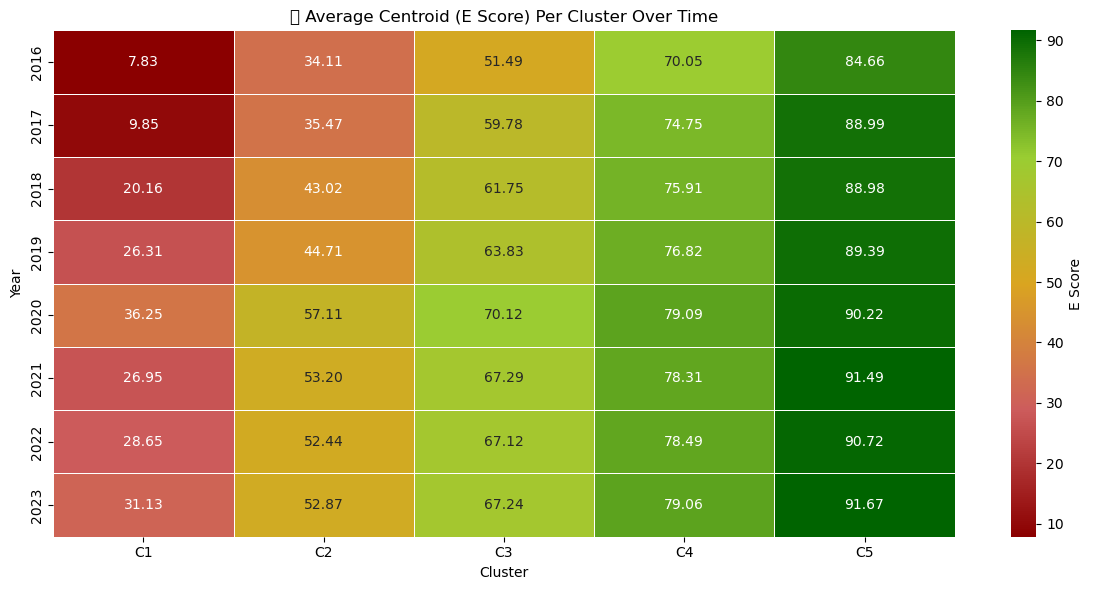

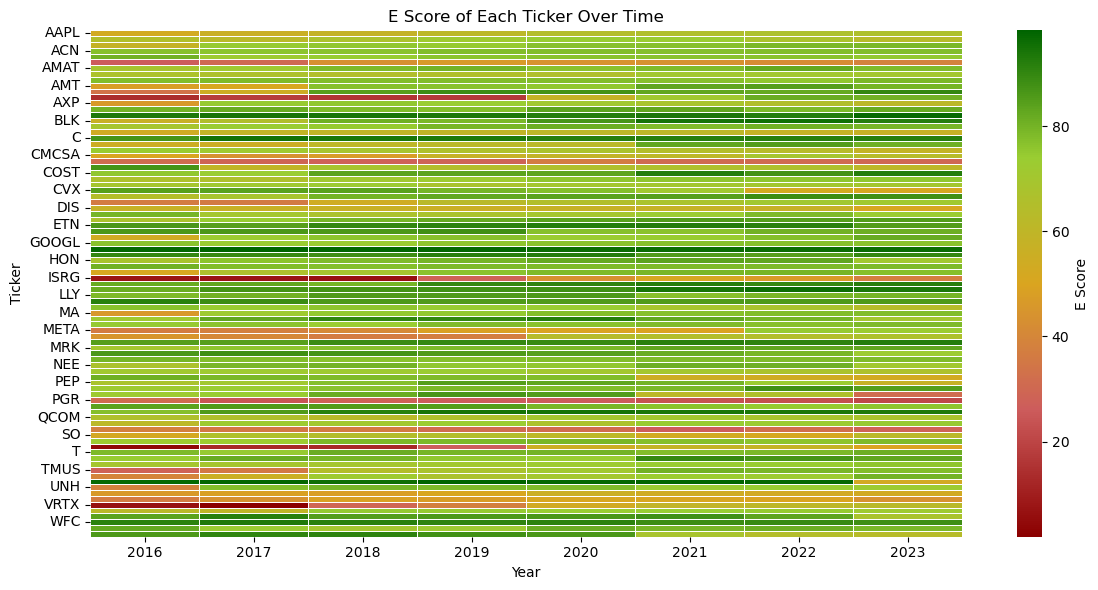

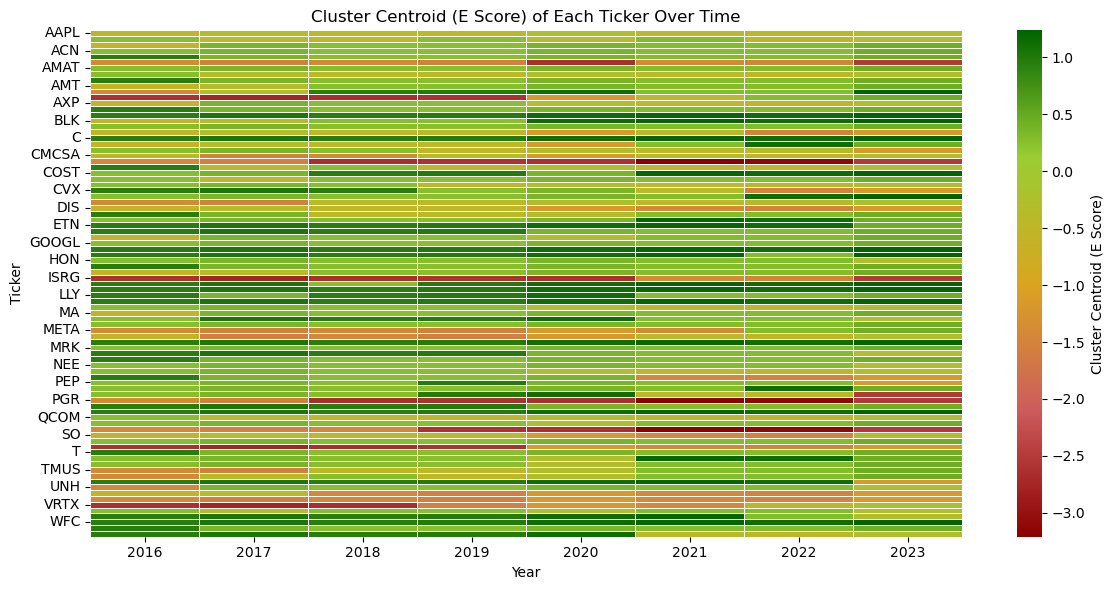

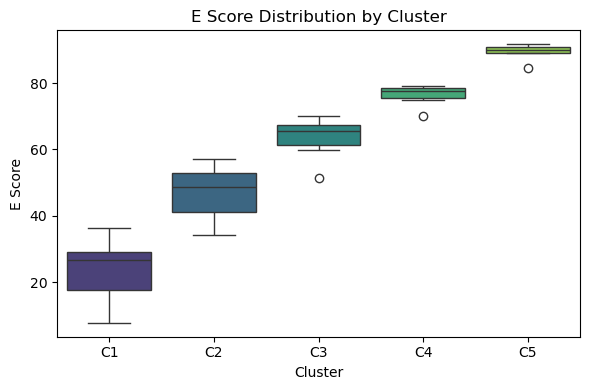

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from matplotlib.colors import LinearSegmentedColormap
import hvplot.pandas  # Optional: if using hvplot for global elbow

# 🔧 Choose fixed K after silhouette analysis
fixed_k = 5

# 🎨 Define ESG color scale
colors = ["#8B0000", "#CD5C5C", "#DAA520", "#9ACD32", "#006400"]
esg_cmap = LinearSegmentedColormap.from_list("ESGScale", colors)

# -----------------------------------
# 📈 Optional: global Elbow Curve
# -----------------------------------
df_year = df_clean[df_clean['Year'] == 2023].copy()
x = StandardScaler().fit_transform(df_year[['E Score']])
k_range = list(range(2, 10))
inertia = [KMeans(n_clusters=k, random_state=42).fit(x).inertia_ for k in k_range]
pd.DataFrame({'k': k_range, 'inertia': inertia}).hvplot.line(
    x='k', y='inertia', title='Global Elbow Curve (e.g., 2023)', xlabel='Number of Clusters', ylabel='Inertia'
)

# -----------------------------------
# 🔁 Fixed-K Clustering Over All Years
# -----------------------------------
cluster_results = []
centroid_records = []

for year in sorted(df_clean['Year'].unique()):
    df_year = df_clean[df_clean['Year'] == year].copy()
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(df_year[['E Score']])

    kmeans = KMeans(n_clusters=fixed_k, random_state=42)
    labels = kmeans.fit_predict(x_scaled)
    centroids = kmeans.cluster_centers_.flatten()

    # Sort clusters by centroid
    sorted_idx = np.argsort(centroids)
    cluster_map = {orig: f"C{i+1}" for i, orig in enumerate(sorted_idx)}

    df_year['Cluster'] = labels
    df_year['Centroid'] = [centroids[label] for label in labels]
    df_year['Cluster'] = df_year['Cluster'].map(cluster_map)


    # Save centroid data
    for cluster, centroid in df_year.groupby('Cluster')['E Score'].mean().items():
        centroid_records.append({'Year': year, 'Cluster': cluster, 'Centroid': centroid})

    cluster_results.append(df_year)

# 📦 Combine & save results
df_final = pd.concat(cluster_results).reset_index(drop=True)
df_final.to_csv("Clustering_Data.csv", index=False)


# -----------------------------------
# 📊 Heatmap: Morelli-style Centroid Table
# -----------------------------------
centroid_df = pd.DataFrame(centroid_records)
centroid_table = centroid_df.pivot(index='Year', columns='Cluster', values='Centroid')
centroid_table = centroid_table[sorted(centroid_table.columns, key=lambda x: int(x[1:]))]
centroid_table.to_csv("Centroid_Table_FixedK.csv")

plt.figure(figsize=(12, 6))
sns.heatmap(
    centroid_table, annot=True, fmt=".2f", cmap=esg_cmap,
    linewidths=0.5, linecolor='white', cbar_kws={'label': 'E Score'}
)
plt.title("📊 Average Centroid (E Score) Per Cluster Over Time")
plt.ylabel("Year")
plt.xlabel("Cluster")
plt.tight_layout()
plt.show()

# -----------------------------------
# 🧭 Heatmap: ESG Score of Each Ticker Over Time
# -----------------------------------
heatmap_table = df_final.groupby(['Ticker', 'Year'])['E Score'].mean().reset_index() \
    .pivot(index='Ticker', columns='Year', values='E Score').dropna()

plt.figure(figsize=(12, 6))
sns.heatmap(
    heatmap_table, cmap=esg_cmap, linewidths=0.5, linecolor='white',
    cbar_kws={'label': 'E Score'}
)
plt.title("E Score of Each Ticker Over Time")
plt.ylabel("Ticker")
plt.xlabel("Year")
plt.tight_layout()
plt.show()

# -----------------------------------
# 🧭 Heatmap: Cluster Centroid per Ticker Over Time
# -----------------------------------
centroid_table_ticker = df_final.groupby(['Ticker', 'Year'])['Centroid'].mean().reset_index() \
    .pivot(index='Ticker', columns='Year', values='Centroid').dropna()

plt.figure(figsize=(12, 6))
sns.heatmap(
    centroid_table_ticker, cmap=esg_cmap, linewidths=0.5, linecolor='white',
    cbar_kws={'label': 'Cluster Centroid (E Score)'}
)
plt.title("Cluster Centroid (E Score) of Each Ticker Over Time")
plt.ylabel("Ticker")
plt.xlabel("Year")
plt.tight_layout()
plt.show()

# -----------------------------------
# 📦 Optional: Boxplot of ESG per Cluster
# -----------------------------------
avg_yearly_scores = df_final.groupby(['Year', 'Cluster'])['E Score'].mean().reset_index()
plt.figure(figsize=(6, 4))
sns.boxplot(data=avg_yearly_scores, x='Cluster', y='E Score', palette='viridis')
plt.title('E Score Distribution by Cluster')
plt.xlabel('Cluster')
plt.ylabel('E Score')
plt.tight_layout()
plt.show()


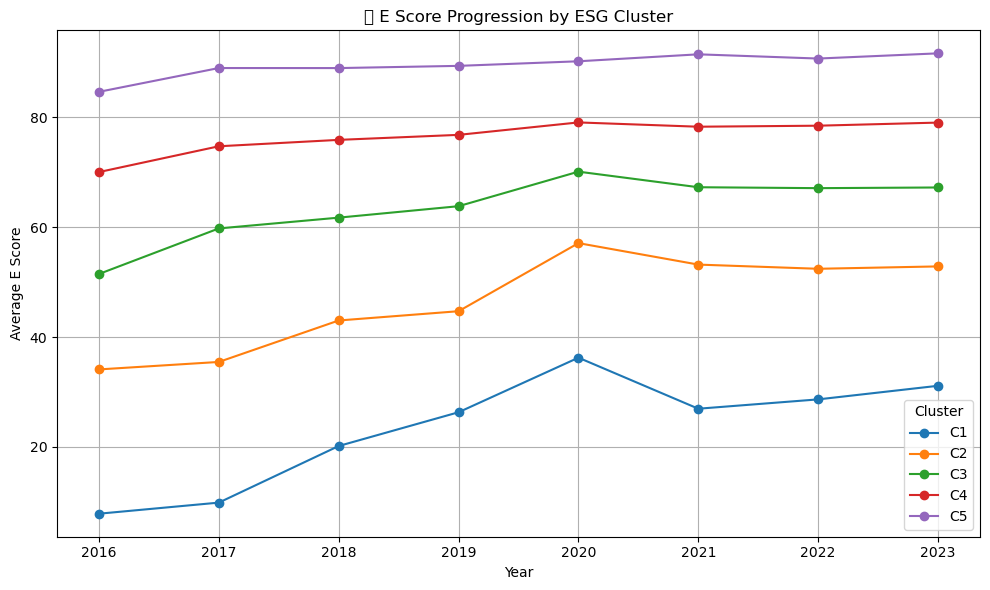

In [32]:
# -----------------------------------
# 📈 Line Plot: Cluster Trajectories Over Time
# -----------------------------------

cluster_scores = (
    df_final.groupby(['Year', 'Cluster'])['E Score']
    .mean()
    .reset_index()
)

plt.figure(figsize=(10, 6))
for cluster in sorted(df_final['Cluster'].unique()):
    subset = cluster_scores[cluster_scores['Cluster'] == cluster]
    plt.plot(subset['Year'], subset['E Score'], marker='o', label=cluster)

plt.title("📈 E Score Progression by ESG Cluster")
plt.xlabel("Year")
plt.ylabel("Average E Score")
plt.legend(title="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()


In [300]:
from scipy.stats import skew, kurtosis

# 🎯 Group by Year, Cluster, and Shade
summary_stats = (
    df_final
    .groupby(['Year', 'Cluster'])[['E Score', 'Centroid']]
    .agg(
        Count=('E Score', 'count'),
        Min=('E Score', 'min'),
        Max=('E Score', 'max'),
        Mean=('E Score', 'mean'),
        Std=('E Score', 'std'),
        Skew=('E Score', lambda x: skew(x, bias=False)),
        Kurtosis=('E Score', lambda x: kurtosis(x, bias=False)),
        Avg_Centroid=('Centroid', 'mean')  # Centroid already precomputed
    )
    .reset_index()
    .round(2)
)

# ✅ Preview
display(summary_stats)


Year Cluster  Count    Min    Max   Mean   Std  Skew  Kurtosis  \
0   2016      C1      4   4.05  13.57   7.83  4.08  1.29      2.12   
1   2016      C2     11  26.15  39.17  34.11  4.37 -0.67     -0.76   
2   2016      C3     15  44.59  58.26  51.49  4.54 -0.09     -1.28   
3   2016      C4     28  61.23  76.80  70.05  4.30 -0.22     -0.53   
4   2016      C5     29  77.52  97.26  84.66  5.49  0.81     -0.03   
5   2017      C1      4   1.89  17.81   9.85  6.84 -0.00     -1.15   
6   2017      C2     10  24.43  43.46  35.47  6.29 -0.38     -0.64   
7   2017      C3     17  48.36  66.67  59.78  5.80 -0.34     -0.85   
8   2017      C4     37  68.62  81.87  74.75  3.16  0.51     -0.04   
9   2017      C5     19  82.89  98.26  88.99  4.81  0.55     -0.83   
10  2018      C1      6   6.78  29.65  20.16  9.63 -0.37     -2.10   
11  2018      C2      7  36.27  48.93  43.02  5.33 -0.25     -1.94   
12  2018      C3     11  54.05  67.58  61.75  4.43 -0.33     -0.98   
13  2018      C4     42  69.13  81.55  75.91  3.50 -0.38     -0.83   
14  2018      C5     21  83.82  97.85  88.98  4.08  0.61     -0.54   
15  2019      C1      6  17.16  31.53  26.31  4.89 -1.56      3.29   
16  2019      C2      6  37.33  50.59  44.71  5.72 -0.71     -1.80   
17  2019      C3     15  56.05  68.36  63.83  3.99 -0.70     -0.63   
18  2019      C4     37  71.01  82.73  76.82  2.76 -0.13     -0.33   
19  2019      C5     23  83.82  98.06  89.39  3.97  0.66     -0.28   
20  2020      C1      5  25.62  44.35  36.25  7.97 -0.34     -1.70   
21  2020      C2     12  49.61  63.28  57.11  4.42 -0.41     -0.90   
22  2020      C3     19  64.60  74.33  70.12  3.29 -0.32     -1.17   
23  2020      C4     32  75.33  84.44  79.09  2.79  0.73     -0.77   
24  2020      C5     19  85.31  97.42  90.22  3.70  0.34     -0.88   
25  2021      C1      3  23.50  30.74  26.95  3.63  0.41     -1.50   
26  2021      C2     10  43.48  58.80  53.20  4.77 -0.73      0.51   
27  2021      C3     17  60.79  71.43  67.29  3.70 -0.71     -0.82   
28  2021      C4     40  73.22  84.47  78.31  3.21  0.25     -0.87   
29  2021      C5     17  85.37  97.87  91.49  3.79 -0.32     -0.81   
30  2022      C1      3  22.86  32.29  28.65  5.07 -1.57     -1.50   
31  2022      C2     10  41.68  58.62  52.44  5.29 -0.80      0.54   
32  2022      C3     16  60.94  71.21  67.12  2.85 -0.49     -0.02   
33  2022      C4     40  72.88  84.59  78.49  3.18  0.08     -0.75   
34  2022      C5     18  85.08  97.30  90.72  3.92  0.22     -1.14   
35  2023      C1      6  20.86  38.62  31.13  6.51 -0.44      0.01   
36  2023      C2     10  43.98  58.62  52.87  4.34 -0.62      0.76   
37  2023      C3     22  60.71  72.86  67.24  4.13 -0.14     -1.53   
38  2023      C4     35  73.67  85.34  79.06  3.05  0.30     -0.22   
39  2023      C5     14  86.07  96.76  91.67  2.99 -0.15     -0.19   

    Avg_Centroid  
0          -2.63  
1          -1.41  
2          -0.60  
3           0.27  
4           0.95  
5          -2.79  
6          -1.55  
7          -0.37  
8           0.35  
9           1.04  
10         -2.66  
11         -1.46  
12         -0.48  
13          0.27  
14          0.96  
15         -2.61  
16         -1.56  
17         -0.48  
18          0.26  
19          0.98  
20         -2.64  
21         -1.19  
22         -0.28  
23          0.35  
24          1.13  
25         -3.21  
26         -1.42  
27         -0.46  
28          0.29  
29          1.19  
30         -3.13  
31         -1.49  
32         -0.49  
33          0.29  
34          1.13  
35         -2.53  
36         -1.18  
37         -0.28  
38          0.45  
39          1.24

****Financials****

In [35]:
cluster_df=pd.read_csv('Clustering_Data.csv',index_col=[0])
cluster_df.head()

Ticker         Company    E Score            Industry  Year  \
Unnamed: 0                                                               
7            AAPL       Apple Inc  52.830211          Technology  2016   
16           MSFT  Microsoft Corp  79.751516          Technology  2016   
26           NVDA     NVIDIA Corp  71.277005          Technology  2016   
34          GOOGL    Alphabet Inc  76.465529          Technology  2016   
43           AMZN  Amazon.com Inc  33.807998  Consumer Cyclicals  2016   

           Cluster  Centroid  
Unnamed: 0                    
7               C3 -0.597672  
16              C5  0.948112  
26              C4  0.267216  
34              C4  0.267216  
43              C2 -1.407631

In [36]:
tickers = cluster_df['Ticker'].drop_duplicates().tolist()
print(f"Tickers before cleaning: {tickers}")

# Drop 'BRK' if it exists in the list
if 'BRK' in tickers:
    tickers.remove('BRK')
    print("Removed 'BRK' from tickers list.")

print(f"Tickers after cleaning: {tickers}")


Tickers before cleaning: ['AAPL', 'MSFT', 'NVDA', 'GOOGL', 'AMZN', 'META', 'AVGO', 'TSLA', 'WMT', 'LLY', 'V', 'JPM', 'UNH', 'MA', 'XOM', 'COST', 'PG', 'ORCL', 'HD', 'ABBV', 'TMUS', 'BAC', 'PM', 'CRM', 'CVX', 'ABT', 'CSCO', 'IBM', 'MCD', 'LIN', 'WFC', 'GE', 'T', 'MRK', 'PEP', 'VZ', 'ACN', 'AXP', 'MS', 'RTX', 'ISRG', 'TMO', 'INTU', 'PGR', 'GS', 'AMGN', 'QCOM', 'DIS', 'ADBE', 'AMD', 'SPGI', 'TJX', 'BSX', 'CAT', 'SCHW', 'DHR', 'NEE', 'BLK', 'TXN', 'SYK', 'GILD', 'UNP', 'CMCSA', 'PFE', 'VRTX', 'HON', 'DE', 'LOW', 'ADP', 'BA', 'C', 'CB', 'MMC', 'AMAT', 'LMT', 'COP', 'MDT', 'ETN', 'AMT', 'BMY', 'SO', 'ELV', 'MO', 'WELL', 'CME', 'DUK', 'PLD']
Tickers after cleaning: ['AAPL', 'MSFT', 'NVDA', 'GOOGL', 'AMZN', 'META', 'AVGO', 'TSLA', 'WMT', 'LLY', 'V', 'JPM', 'UNH', 'MA', 'XOM', 'COST', 'PG', 'ORCL', 'HD', 'ABBV', 'TMUS', 'BAC', 'PM', 'CRM', 'CVX', 'ABT', 'CSCO', 'IBM', 'MCD', 'LIN', 'WFC', 'GE', 'T', 'MRK', 'PEP', 'VZ', 'ACN', 'AXP', 'MS', 'RTX', 'ISRG', 'TMO', 'INTU', 'PGR', 'GS', 'AMGN', 'QCOM

In [37]:
cluster_df['Cluster'].nunique()

5

In [38]:
tickers = cluster_df['Ticker'].drop_duplicates().tolist()
print(f"Total unique tickers from clustering data: {len(tickers)}")
print(tickers)

# Dictionary to store all data
all_data = []

for ticker in tickers:
    data = yf.download(ticker, start='2016-01-01', end='2023-12-31', interval='1d', auto_adjust=True)['Close']
    data.index= pd.to_datetime(data.index)
    df = pd.DataFrame()
    df['Price']=data.fillna(method='ffill')
    df['Log Returns'] = np.log(df['Price']/df['Price'].shift(1))
    df['Ticker']=ticker
    
    df = df.dropna()  # Remove any rows with NaNs (from diff, pct_change)
    all_data.append(df)

results=pd.concat(all_data)


Total unique tickers from clustering data: 87
['AAPL', 'MSFT', 'NVDA', 'GOOGL', 'AMZN', 'META', 'AVGO', 'TSLA', 'WMT', 'LLY', 'V', 'JPM', 'UNH', 'MA', 'XOM', 'COST', 'PG', 'ORCL', 'HD', 'ABBV', 'TMUS', 'BAC', 'PM', 'CRM', 'CVX', 'ABT', 'CSCO', 'IBM', 'MCD', 'LIN', 'WFC', 'GE', 'T', 'MRK', 'PEP', 'VZ', 'ACN', 'AXP', 'MS', 'RTX', 'ISRG', 'TMO', 'INTU', 'PGR', 'GS', 'AMGN', 'QCOM', 'DIS', 'ADBE', 'AMD', 'SPGI', 'TJX', 'BSX', 'CAT', 'SCHW', 'DHR', 'NEE', 'BLK', 'TXN', 'SYK', 'GILD', 'UNP', 'CMCSA', 'PFE', 'VRTX', 'HON', 'DE', 'LOW', 'ADP', 'BA', 'C', 'CB', 'MMC', 'AMAT', 'LMT', 'COP', 'MDT', 'ETN', 'AMT', 'BMY', 'SO', 'ELV', 'MO', 'WELL', 'CME', 'DUK', 'PLD']


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Before cleaning: 174957 rows
After cleaning: 174957 rows


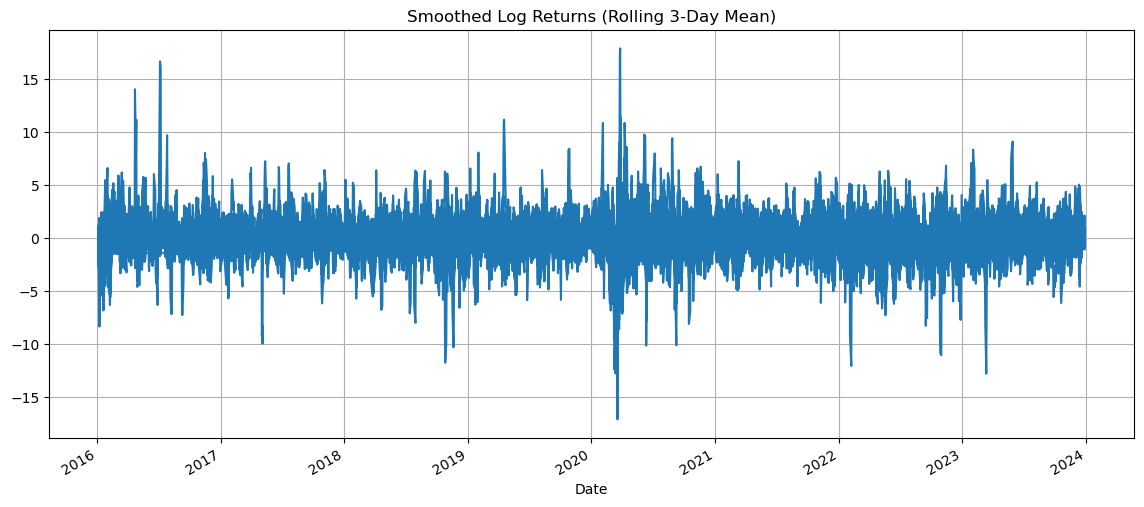

In [39]:
# ✅ CLEANING STEP: Remove extreme log returns
threshold = 1.5  # Set a threshold
print(f"Before cleaning: {results.shape[0]} rows")
results = results[(results['Log Returns'].abs() <= threshold)]  # Clean
print(f"After cleaning: {results.shape[0]} rows")

# 3. ✅ SMOOTHING STEP: Apply rolling mean
results['Log Returns Smoothed'] = results['Log Returns'].rolling(window=3, min_periods=1).mean()
results['Log Returns Smoothed'] = results['Log Returns Smoothed'] * 100  # Turn into percent returns

# 4. ✅ PLOT the smoothed returns
plt.figure(figsize=(14,6))
results['Log Returns Smoothed'].plot(title="Smoothed Log Returns (Rolling 3-Day Mean)")
plt.grid(True)
plt.show()

In [40]:
print(results.dtypes)
print(results.info())
print(results['Ticker'].nunique())

Price                   float64
Log Returns             float64
Ticker                   object
Log Returns Smoothed    float64
dtype: object
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 174957 entries, 2016-01-05 to 2023-12-29
Data columns (total 4 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Price                 174957 non-null  float64
 1   Log Returns           174957 non-null  float64
 2   Ticker                174957 non-null  object 
 3   Log Returns Smoothed  174957 non-null  float64
dtypes: float64(3), object(1)
memory usage: 6.7+ MB
None
87


In [41]:
results.to_csv('financials.csv')

In [42]:
results

Price  Log Returns Ticker  Log Returns Smoothed
Date                                                            
2016-01-05   23.237103    -0.025379   AAPL             -2.537856
2016-01-06   22.782362    -0.019764   AAPL             -2.257108
2016-01-07   21.820843    -0.043121   AAPL             -2.942107
2016-01-08   21.936224     0.005274   AAPL             -1.920364
2016-01-11   22.291430     0.016063   AAPL             -0.726145
...                ...          ...    ...                   ...
2023-12-22  127.092888     0.010936    PLD             -0.338159
2023-12-26  128.110397     0.007974    PLD              0.755283
2023-12-27  128.801529     0.005380    PLD              0.809672
2023-12-28  129.771057     0.007499    PLD              0.695119
2023-12-29  127.956825    -0.014079    PLD             -0.039982

[174957 rows x 4 columns]

In [43]:
print(results.dtypes)
print(results.info())
print(results['Ticker'].nunique())

Price                   float64
Log Returns             float64
Ticker                   object
Log Returns Smoothed    float64
dtype: object
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 174957 entries, 2016-01-05 to 2023-12-29
Data columns (total 4 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Price                 174957 non-null  float64
 1   Log Returns           174957 non-null  float64
 2   Ticker                174957 non-null  object 
 3   Log Returns Smoothed  174957 non-null  float64
dtypes: float64(3), object(1)
memory usage: 6.7+ MB
None
87


In [44]:
%matplotlib inline
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
sns.set(style="darkgrid", color_codes=True)
rcParams['figure.figsize'] = 8,4
def hurst(ts):
    """Returns the Hurst Exponent of the time series vector ts"""
    # Create the range of lag values
    lags = range(2, 100)
    
    # Calculate the array of the variances of the lagged differences
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    
    # Use a linear fit to estimate the Hurst Exponent
    poly = polyfit(log(lags), log(tau), 1)
    
    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0

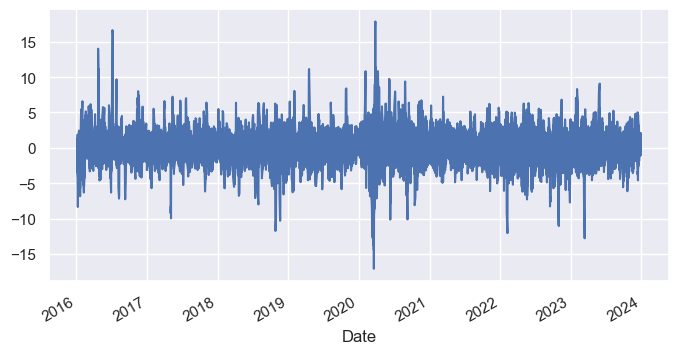

In [45]:
results['Log Returns Smoothed'].plot()
plt.show()

In [302]:
def plot_correlogram(x, lags=None, title=None):    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
    x.plot(ax=axes[0][0])
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f} \nHurst: {round(hurst(x.values),2)}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=20)
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

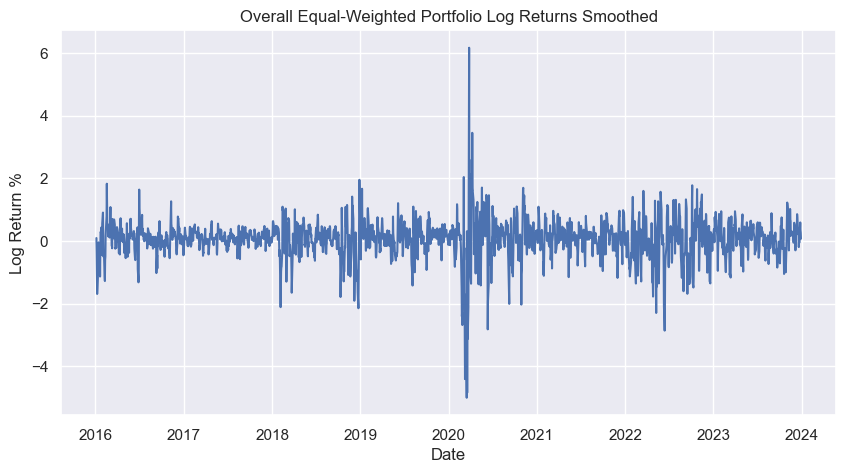

ADF Statistic for smoothed log returns: -9.700462
p-value for smoothed log returns: 0.000000


In [47]:
# Pivot so each stock becomes a column
pivot_logs = results.pivot_table(
    index='Date',
    columns='Ticker',
    values='Log Returns Smoothed'
)


# Equal-weighted portfolio: mean across tickers
spportfolio_logs = pivot_logs.mean(axis=1)

# Plot the portfolio log returns
plt.figure(figsize=(10,5))
plt.plot(spportfolio_logs)
plt.title("Overall Equal-Weighted Portfolio Log Returns Smoothed")
plt.xlabel("Date")
plt.ylabel("Log Return %")
plt.grid(True)
plt.show()


# ADF Test on portfolio returns
result = adfuller(spportfolio_logs.dropna())  # drop NaNs to be safe
print('ADF Statistic for smoothed log returns: %f' % result[0])
print('p-value for smoothed log returns: %f' % result[1])

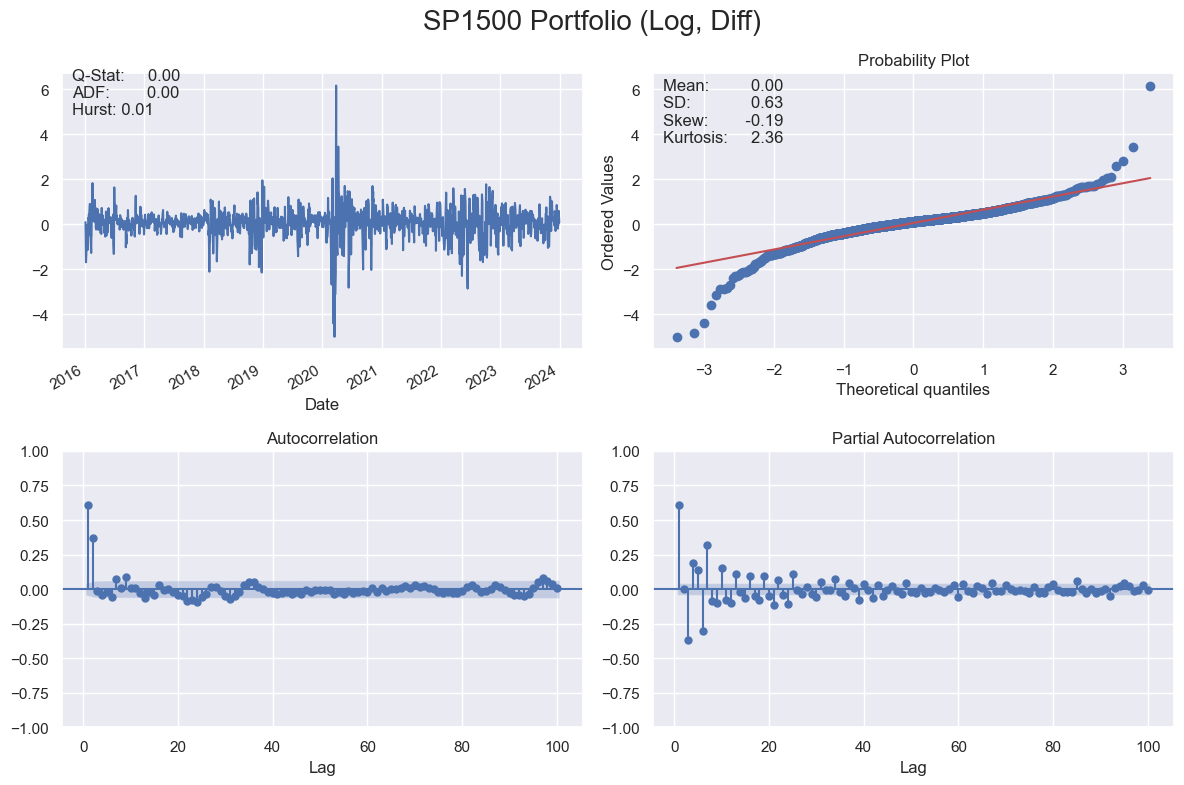

In [48]:
plot_correlogram(
        spportfolio_logs,
        lags=100,
        title=f'SP1500 Portfolio (Log, Diff)'
    )

In [49]:
results.head()

Price  Log Returns Ticker  Log Returns Smoothed
Date                                                           
2016-01-05  23.237103    -0.025379   AAPL             -2.537856
2016-01-06  22.782362    -0.019764   AAPL             -2.257108
2016-01-07  21.820843    -0.043121   AAPL             -2.942107
2016-01-08  21.936224     0.005274   AAPL             -1.920364
2016-01-11  22.291430     0.016063   AAPL             -0.726145

In [304]:
import warnings
import pandas as pd
import numpy as np
from arch import arch_model
from scipy.stats import t

# === Step 1: Setup ===
warnings.filterwarnings('ignore')

confidence_level = 0.95

# Correct function name to avoid conflicts
def compute_quantile_VaR(returns, confidence_level=0.95):
    quantile_value = np.quantile(returns, 1 - confidence_level)
    VaR = -quantile_value
    return VaR

tickers = results['Ticker'].unique()
var_results = []
skipped_tickers = []

# Counters
total = 0
success = 0
fail = 0

# === Step 2: Main loop ===
for ticker in tickers:
    df = results[results['Ticker'] == ticker].copy()
    returns = df['Log Returns Smoothed'].dropna()

    total += 1

    # Skip problematic series
    if len(returns) < 250:
        skipped_tickers.append((ticker, "Too few data points"))
        fail += 1
        continue

    if returns.std() < 0.005:
        skipped_tickers.append((ticker, "Too little volatility"))
        fail += 1
        continue

    try:
        # Fit GARCH(1,1) with skewed t-distribution
        model = arch_model(
            returns,
            mean='AR',
            lags=1,
            vol='Garch',
            p=1,
            q=1,
            dist='skewt'
        )
        res = model.fit(disp='off')

        # Forecast next-day volatility
        forecast = res.forecast(horizon=1)
        sigma_forecast = np.sqrt(forecast.variance.iloc[-1].values[0])
        mean_forecast = returns.mean()

        # GARCH VaR using skewed t-distribution
        nu = res.params['eta']
        skew = res.params['lambda']
        scale_param = sigma_forecast * np.sqrt((nu - 2) / nu)
        garch_VaR = -t.ppf(1 - confidence_level, df=nu, loc=mean_forecast, scale=scale_param)

        # Compute Quantile VaR separately
        quant_VaR = compute_quantile_VaR(returns, confidence_level)

        # Save results
        var_results.append({
            'Ticker': ticker,
            'quantile_VaR': quant_VaR,
            'GARCH_VaR': garch_VaR,
            'mean_return': mean_forecast,
            'aic': res.aic,
            'mu': res.params['Const'],
            'ar1': res.params.get('ar.L1', 0),
            'nu': nu,
            'skew': skew,
            'sigma_forecast': sigma_forecast
        })

        success += 1
        print(f"✅ Successfully fitted GARCH and calculated VaR for {ticker}.")

    except Exception as e:
        skipped_tickers.append((ticker, f"GARCH fitting error: {str(e)}"))
        fail += 1
        print(f"⚠️ Failed GARCH fitting for {ticker}: {e}")
        continue

# === Step 3: Summary ===
print("\n=== VaR Modeling Summary ===")
print(f"Total tickers attempted: {total}")
print(f"Successfully processed: {success}")
print(f"Skipped/failed: {fail}")

if skipped_tickers:
    print("\n--- Skipped tickers and reasons ---")
    for ticker, reason in skipped_tickers:
        print(f"{ticker}: {reason}")

# === Step 4: Save results to DataFrame ===
var_df = pd.DataFrame(var_results)

print("\nExample of VaR results:")
print(var_df)


✅ Successfully fitted GARCH and calculated VaR for AAPL.
✅ Successfully fitted GARCH and calculated VaR for MSFT.
✅ Successfully fitted GARCH and calculated VaR for NVDA.
✅ Successfully fitted GARCH and calculated VaR for GOOGL.
✅ Successfully fitted GARCH and calculated VaR for AMZN.
✅ Successfully fitted GARCH and calculated VaR for META.
✅ Successfully fitted GARCH and calculated VaR for AVGO.
✅ Successfully fitted GARCH and calculated VaR for TSLA.
✅ Successfully fitted GARCH and calculated VaR for WMT.
✅ Successfully fitted GARCH and calculated VaR for LLY.
✅ Successfully fitted GARCH and calculated VaR for V.
✅ Successfully fitted GARCH and calculated VaR for JPM.
✅ Successfully fitted GARCH and calculated VaR for UNH.
✅ Successfully fitted GARCH and calculated VaR for MA.
✅ Successfully fitted GARCH and calculated VaR for XOM.
✅ Successfully fitted GARCH and calculated VaR for COST.
✅ Successfully fitted GARCH and calculated VaR for PG.
✅ Successfully fitted GARCH and calculated

In [51]:
model=pd.DataFrame(var_results)
model

Ticker  quantile_VaR  GARCH_VaR  mean_return          aic        mu  ar1  \
0    AAPL      1.554056   0.566151     0.102515  4186.148109  0.052825    0   
1    MSFT      1.422092   0.473256     0.101379  3824.265791  0.049563    0   
2    NVDA      2.613207   1.083569     0.205859  6351.326065  0.076628    0   
3   GOOGL      1.629066   0.827077     0.064952  4160.043627  0.034263    0   
4    AMZN      1.957396   0.687008     0.077860  4695.099956  0.040770    0   
..    ...           ...        ...          ...          ...       ...  ...   
82     MO      1.485536   0.665372     0.008304  3172.484066  0.015718    0   
83   WELL      1.590685   0.806731     0.031168  4048.152138  0.013850    0   
84    CME      1.125391   0.613399     0.057877  3221.883789  0.027180    0   
85    DUK      1.055406   0.521626     0.031914  2504.334581  0.014875    0   
86    PLD      1.546538   1.119984     0.068972  3716.561251  0.031626    0   

          nu      skew  sigma_forecast  
0   6.632131 -0.026550        0.418790  
1   7.569266 -0.058045        0.357601  
2   6.707531 -0.064383        0.807072  
3   6.482130 -0.040738        0.559420  
4   6.696525 -0.024850        0.478785  
..       ...       ...             ...  
82  5.085863 -0.080534        0.430801  
83  9.044597 -0.092117        0.518218  
84  6.674034  0.071013        0.420277  
85  9.616728 -0.066384        0.341783  
86  8.840300 -0.076645        0.735832  

[87 rows x 10 columns]

In [52]:
# Custom skewed t-distribution function
def skewed_t_rvs(n, skew=0, nu=5):
    u = np.random.uniform(0, 1, n)
    z = t.rvs(df=nu, size=n)
    delta = np.clip(skew, -0.99, 0.99)  # Prevent invalid skewness
    return np.where(u < (1 + delta)/2, z / (1 + delta), z / (1 - delta))

In [53]:

n_simulations = 500
simulated_returns = {}

# CAREFUL: you should loop over var_df, not model
for _, row in model.iterrows():  
    ticker = row['Ticker']
    mu = row['mu']
    ar1 = row['ar1']
    nu = row['nu']
    skew = row['skew']
    sigma_forecast = row['sigma_forecast']

    # Simulate standardized skewed t residuals
    z = skewed_t_rvs(n_simulations, skew=skew, nu=nu)

    # Rescale
    scale_param = sigma_forecast * np.sqrt((nu - 2) / nu)

    # Get last actual return (IMPORTANT: Use 'Log Returns Smoothed' now)
    last_return = results[results['Ticker'] == ticker]['Log Returns Smoothed'].dropna().iloc[-1]

    # Generate simulated returns
    sim_returns_single = mu + ar1 * last_return + scale_param * z
    simulated_returns[ticker] = sim_returns_single

# Put all simulations into a DataFrame
sim_returns = pd.DataFrame(simulated_returns)

# Preview
print(sim_returns.head())

       AAPL      MSFT      NVDA     GOOGL      AMZN      META      AVGO  \
0  0.914900  0.119571  0.660928 -0.181431  0.152575 -0.423342  0.192304   
1 -0.309508 -0.699122 -0.842229  0.087456 -0.359615 -0.541052  0.030545   
2  0.614991  0.298725 -0.452159 -0.448102 -0.812040  0.053340  1.125201   
3  0.095554  0.218734  1.091913 -0.893331 -0.167531  0.145064 -0.240978   
4 -0.347110  0.168645 -0.284616  0.175980  0.290866  1.794788 -0.085861   

       TSLA       WMT       LLY         V       JPM       UNH        MA  \
0 -0.742372  0.281278  0.128646 -0.322449  0.356908  0.256790 -0.077193   
1  0.625484 -0.013964  0.113457  0.221375 -0.737834 -0.054600  0.396581   
2 -1.887667  0.141629 -0.652898 -0.145110  0.915190 -0.734379 -0.366395   
3  1.321548 -0.244427  0.324484  1.102753 -0.578193  0.102803  0.111852   
4  0.437342 -0.434235  0.152453  0.025812  0.089656 -0.063699 -0.052567   

        XOM      COST        PG      ORCL        HD      ABBV      TMUS  \
0 -0.024131 -0.059701 -

In [54]:
sim_returns=pd.DataFrame(simulated_returns)
sim_returns

AAPL      MSFT      NVDA     GOOGL      AMZN      META      AVGO  \
0    0.914900  0.119571  0.660928 -0.181431  0.152575 -0.423342  0.192304   
1   -0.309508 -0.699122 -0.842229  0.087456 -0.359615 -0.541052  0.030545   
2    0.614991  0.298725 -0.452159 -0.448102 -0.812040  0.053340  1.125201   
3    0.095554  0.218734  1.091913 -0.893331 -0.167531  0.145064 -0.240978   
4   -0.347110  0.168645 -0.284616  0.175980  0.290866  1.794788 -0.085861   
..        ...       ...       ...       ...       ...       ...       ...   
495  0.008830 -0.111215  0.153517 -1.622223 -0.098850 -0.686013 -0.490384   
496  0.487267  0.632730 -0.096722  0.660286 -0.431038  0.372487 -0.014025   
497 -0.247489  0.423711  0.020457  0.337916 -0.490690  0.004375  0.213206   
498  0.879209  0.138222 -1.093641  0.169396 -0.269007 -0.321467  0.699074   
499  0.028284 -0.577862 -0.313031  0.070443  0.661058 -0.223504  0.159724   

         TSLA       WMT       LLY         V       JPM       UNH        MA  \
0   -0.742372  0.281278  0.128646 -0.322449  0.356908  0.256790 -0.077193   
1    0.625484 -0.013964  0.113457  0.221375 -0.737834 -0.054600  0.396581   
2   -1.887667  0.141629 -0.652898 -0.145110  0.915190 -0.734379 -0.366395   
3    1.321548 -0.244427  0.324484  1.102753 -0.578193  0.102803  0.111852   
4    0.437342 -0.434235  0.152453  0.025812  0.089656 -0.063699 -0.052567   
..        ...       ...       ...       ...       ...       ...       ...   
495 -0.893949 -0.306323  0.191236  0.195826 -0.316603 -0.401630 -0.190412   
496 -0.104899 -0.144340  0.827042 -0.143722 -1.132409  0.218415  0.223731   
497 -0.506103 -0.011008 -0.406488 -0.064129 -0.007331 -0.262561 -0.162666   
498  1.748604 -0.002822 -0.304910  0.115625 -0.069855  0.172427  0.121725   
499 -1.923369 -0.008826 -0.179164  0.512295  0.057123 -0.203462 -0.068634   

          XOM      COST        PG      ORCL        HD      ABBV      TMUS  \
0   -0.024131 -0.059701 -0.126140 -0.181129  0.590486 -0.174518 -0.069883   
1    0.108727  0.658529 -0.021260 -0.477760  0.500575  0.215004  0.115201   
2   -0.454079 -0.206293  0.123845  0.596080 -0.096427 -0.148888  0.022965   
3    0.569347 -0.713609  0.558282 -0.010696 -0.867499  0.147009 -0.230419   
4   -0.529090 -0.163163  0.382675  1.695619 -0.022920  0.251019 -0.280282   
..        ...       ...       ...       ...       ...       ...       ...   
495  0.240342 -0.046165  0.701237  0.282813  0.291469 -0.103189  0.107752   
496  0.017939 -0.708548 -0.512904 -0.236979 -0.115092  0.210291 -0.180238   
497  0.132360  1.361166 -0.223533 -0.068679  1.332438 -0.095406  0.189180   
498  0.017118  0.864112  0.204416  0.392550 -0.668601 -0.234582 -0.092070   
499  0.018782 -1.002979  0.172185 -0.017923  0.209546  0.151967  0.433344   

          BAC        PM       CRM       CVX       ABT      CSCO       IBM  \
0    0.108400  0.075617  1.440384  0.340201  0.090167  0.154919  0.104092   
1    0.061280 -0.471857 -0.160481  0.367556  0.326984  0.033598  0.086533   
2   -0.200370  0.304363  0.026763  0.180896 -0.176631 -0.147236  0.593883   
3   -0.684975  0.178989 -0.245875  0.073802 -0.004048 -0.044201 -0.554211   
4   -1.428569  0.177111 -0.797182  0.370588  0.453123  0.304198 -0.094337   
..        ...       ...       ...       ...       ...       ...       ...   
495  0.264432  0.128382  2.559463  0.407201  0.373945  0.019238  0.305627   
496  0.683785  0.063374 -0.066337  0.041463 -0.902952 -0.374215 -0.743567   
497  0.762250  0.131701  0.229495  0.070487  0.477237 -0.486419 -0.436007   
498  1.166948  0.035036 -0.249686  0.512178  0.073791 -0.058843  0.122454   
499 -1.570976  0.255074 -0.597411  0.394151  0.241805  0.239623  0.006450   

          MCD       LIN       WFC        GE         T       MRK       PEP  \
0   -0.016452 -0.397776 -0.102129  0.226420  0.066131 -0.056424  0.378515   
1   -0.336870 -0.146650 -0.910122  0.342013 -0.145914  0.018778 -0.597764   
2    0.095843 -0.279621 -0.004794  0.423691  0.043089 -0.126250 -0.456814   
3

In [55]:

# Simulated returns
print("Simulated returns tickers (first 5):", sim_returns.columns.tolist()[:5])
print("Number of simulated returns tickers:", sim_returns.shape[1])

# Clustered tickers
print("Tickers in cluster_df (first 5):", cluster_df['Ticker'].unique()[:5])
print("Number of tickers in cluster_df:", cluster_df['Ticker'].nunique())


Simulated returns tickers (first 5): ['AAPL', 'MSFT', 'NVDA', 'GOOGL', 'AMZN']
Number of simulated returns tickers: 87
Tickers in cluster_df (first 5): ['AAPL' 'MSFT' 'NVDA' 'GOOGL' 'AMZN']
Number of tickers in cluster_df: 87


In [56]:
import cvxpy as cp
import numpy as np
import pandas as pd
from tqdm import tqdm

# Create the DataFrame of GARCH-simulated returns
sim_returns = pd.DataFrame(simulated_returns)

rebalance_dates = results[(results.index.year >= 2017)].index.normalize().unique()

optimized = []

# === Main loop ===
for date in tqdm(rebalance_dates):
    year = date.year  # Get the year from the date

    # Iterate over each cluster for that year
    for cluster in cluster_df[cluster_df['Year'] == year]['Cluster'].unique():
        
        cluster_subset = cluster_df[
            (cluster_df['Year'] == year) &
            (cluster_df['Cluster'] == cluster)
        ]
        tickers_in_cluster = cluster_subset['Ticker'].values

        # Filter available tickers (that have simulated returns)
        available_tickers = [t for t in tickers_in_cluster if t in sim_returns.columns]
        if len(available_tickers) < 2:
            continue  # Skip very small clusters

        # Build E_scores safely
        E_scores = []
        for ticker in available_tickers:
            score = cluster_df.loc[
                (cluster_df['Ticker'] == ticker) &
                (cluster_df['Year'] == year) &
                (cluster_df['Cluster'] == cluster),
                'E Score'
            ].values

            if len(score) > 0:
                E_scores.append(score[0])

        E_scores = np.array(E_scores)

        # Get simulated returns for available tickers
        sim_returns_day = sim_returns[available_tickers].values
        T = sim_returns_day.shape[0]
        target_return = sim_returns[available_tickers].mean().mean()
        E_target = np.mean(E_scores)

        # Optimization variables
        w = cp.Variable(len(available_tickers))
        VaR = cp.Variable()
        z = cp.Variable(T)

        alpha = 0.95
        cvar_penalty = 0.1  # Optional: penalize large weights (L1 regularization)
        
        # Define objective
        objective = cp.Minimize(
            VaR + (1 / ((1 - alpha) * T)) * cp.sum(z) + cvar_penalty * cp.norm(w, 1)
        )
        
        # Define constraints (with tiny slack -1e-4)
        constraints = [
            cp.sum(w) == 1,
            w >= 0,
            sim_returns_day @ w + VaR + z >= -1e-4,  # Tiny tolerance
            z >= 0,
            sim_returns[available_tickers].mean().values @ w >= target_return,
            cp.sum(cp.multiply(E_scores, w)) >= E_target
        ]

        # Solve with SCS inside try/except
        prob = cp.Problem(objective, constraints)

        try:
            prob.solve(
                solver=cp.SCS, 
                verbose=False, 
                warm_start=True, 
                max_iters=3000  # Allow more iterations if needed
            )
        except Exception as e:
            print(f"⚠️ Optimization failed for {date.date()} - Cluster {cluster}: {e}")
            continue

        # Save results if solution is valid
        if w.value is not None:
            weights = w.value
            for i, ticker in enumerate(available_tickers):
                optimized.append({
                    'Date': date,
                    'Cluster': cluster,
                    'Ticker': ticker,
                    'Weight': weights[i],
                    'CVaR': prob.value
                })


100%|██████████| 1760/1760 [44:46<00:00,  1.53s/it] 


In [66]:
# 📦 Save optimized results after the full loop -> changed prob.solve(solver=cp.scs, ==e)

optimized_df = pd.DataFrame(optimized)
optimized_df.to_csv("Optimized_Portfolio_Results.csv", index=False)
print("✅ Optimization results saved to Optimized_Portfolio_Results.csv")


✅ Optimization results saved to Optimized_Portfolio_Results.csv


In [67]:
# Step 0: Make sure 'Date' is datetime type
if not np.issubdtype(optimized_df['Date'].dtype, np.datetime64):
    optimized_df['Date'] = pd.to_datetime(optimized_df['Date'], errors='coerce')

# Step 1: Create Month and Year columns
if 'Month' not in optimized_df.columns:
    optimized_df['Month'] = optimized_df['Date'].dt.to_period('M')
if 'Year' not in optimized_df.columns:
    optimized_df['Year'] = optimized_df['Date'].dt.year

# Step 2: Group by Year, Cluster, Ticker and average weights
cluster_component_weights = optimized_df.groupby(['Year', 'Cluster', 'Ticker'])['Weight'].mean().reset_index()

# Step 3: Normalize inside each Year and Cluster
cluster_component_weights['Normalized_Weight'] = cluster_component_weights.groupby(['Year', 'Cluster'])['Weight'].transform(lambda x: x / x.sum())

# Step 4: Sort nicely
cluster_component_weights = cluster_component_weights.sort_values(['Year', 'Cluster', 'Normalized_Weight'], ascending=[True, True, False])

# Step 5: Show clean tables
years = cluster_component_weights['Year'].unique()

for year in years:
    clusters = cluster_component_weights[cluster_component_weights['Year'] == year]['Cluster'].unique()
    for cluster in clusters:
        print(f"\n🔵 Year {year} - Cluster {cluster} - Stocks and Normalized Weights:")
        cluster_table = cluster_component_weights[
            (cluster_component_weights['Year'] == year) & 
            (cluster_component_weights['Cluster'] == cluster)
        ]
        display(cluster_table[['Ticker', 'Normalized_Weight']])



🔵 Year 2017 - Cluster C1 - Stocks and Normalized Weights:


Ticker  Normalized_Weight
2    SYK           0.452798
0   AVGO           0.241704
1   ISRG           0.174980
3   VRTX           0.130519


🔵 Year 2017 - Cluster C2 - Stocks and Normalized Weights:


Ticker  Normalized_Weight
13      V           0.160147
9     MMC           0.140920
10    PGR           0.123941
4     ADP           0.108958
5   CMCSA           0.104333
12   TMUS           0.103171
8    META           0.083922
7     DHR           0.083154
6     CME           0.074742
11   SCHW           0.016712


🔵 Year 2017 - Cluster C3 - Stocks and Normalized Weights:


Ticker  Normalized_Weight
30     VZ           0.127788
15   ABBV           0.091099
18   AMZN           0.089925
23    CRM           0.084312
27     SO           0.077985
14   AAPL           0.076310
26   QCOM           0.069389
25   INTU           0.065228
19    BLK           0.056879
29    UNP           0.049667
24    DIS           0.043811
21    CAT           0.035475
28   TSLA           0.031182
17    AMT           0.027899
22    COP           0.027616
16    AMD           0.025573
20    BSX           0.019862


🔵 Year 2017 - Cluster C4 - Stocks and Normalized Weights:


Ticker  Normalized_Weight
51     MA           0.074401
58    PEP           0.059690
61    RTX           0.055194
63      T           0.053782
54   MSFT           0.053523
53    MRK           0.052615
49    LLY           0.048092
43    DUK           0.043279
37     BA           0.043120
64    TJX           0.037595
52    MDT           0.037331
35   AMGN           0.037028
66    UNH           0.034623
45   GILD           0.034000
41   CSCO           0.032639
46  GOOGL           0.028239
62   SPGI           0.026078
44    ELV           0.023586
57   ORCL           0.020988
50    LOW           0.020321
39     CB           0.019452
38    BMY           0.018634
48    IBM           0.018566
34   AMAT           0.016964
33   ADBE           0.016352
40   COST           0.015745
36    AXP           0.015514
60     PG           0.014094
59    PFE           0.013239
42     DE           0.012053
47    HON           0.011782
67    WMT           0.006526
56   NVDA           0.002489
65    TMO           0.002300
32    ACN           0.000172
31    ABT          -0.000003
55    NEE          -0.000004


🔵 Year 2017 - Cluster C5 - Stocks and Normalized Weights:


Ticker  Normalized_Weight
78    MCD       1.107314e-01
83    TXN       8.412724e-02
75    JPM       8.078265e-02
73     GS       7.544372e-02
69      C       7.473081e-02
74     HD       6.956986e-02
77    LMT       6.195204e-02
70    CVX       5.987268e-02
71    ETN       5.412987e-02
82     PM       5.120618e-02
84   WELL       5.117139e-02
79     MO       4.953903e-02
86    XOM       4.328033e-02
80     MS       3.795701e-02
72     GE       3.045760e-02
76    LIN       2.891204e-02
85    WFC       2.568600e-02
68    BAC       1.044965e-02
81    PLD       4.742023e-07


🔵 Year 2018 - Cluster C1 - Stocks and Normalized Weights:


Ticker  Normalized_Weight
91    SYK           0.274338
88    CME           0.267331
90    PGR           0.166676
87   AVGO           0.155733
89   ISRG           0.084475
92   VRTX           0.051446


🔵 Year 2018 - Cluster C2 - Stocks and Normalized Weights:


Ticker  Normalized_Weight
99      V           0.237779
93    ADP           0.188064
96    MMC           0.175079
95   META           0.152177
94  CMCSA           0.132320
98    UNP           0.089104
97   SCHW           0.025477


🔵 Year 2018 - Cluster C3 - Stocks and Normalized Weights:


Ticker  Normalized_Weight
107    DUK           0.148285
109     SO           0.128935
105    DHR           0.126575
100   AAPL           0.105899
101   ABBV           0.099041
108   QCOM           0.092109
104    CAT           0.091073
110   TMUS           0.086977
106    DIS           0.059193
102    AMD           0.036412
103    BSX           0.025501


🔵 Year 2018 - Cluster C4 - Stocks and Normalized Weights:


Ticker  Normalized_Weight
134     MA       7.584580e-02
147    TJX       7.258252e-02
146      T       5.241230e-02
144    RTX       5.188677e-02
137   MSFT       4.839633e-02
151     VZ       4.522884e-02
141    PEP       4.003874e-02
145   SPGI       3.969877e-02
136    MRK       3.733295e-02
150    UNH       3.559932e-02
115   AMGN       3.477358e-02
124   CSCO       3.464951e-02
128  GOOGL       3.050874e-02
148    TMO       2.829635e-02
129    HON       2.797407e-02
152    WMT       2.651052e-02
120    BMY       2.638407e-02
133    LOW       2.340842e-02
127   GILD       2.331815e-02
131   INTU       2.323883e-02
140   ORCL       2.323139e-02
118     BA       2.279999e-02
117    AXP       2.213635e-02
132    JPM       1.936311e-02
139   NVDA       1.755535e-02
113   ADBE       1.569469e-02
123    CRM       1.440128e-02
122    COP       1.227300e-02
121     CB       1.216937e-02
126    ELV       1.083942e-02
114   AMAT       1.066321e-02
135    MDT       1.003735e-02
116    AMT       1.000377e-02
138    NEE       8.710112e-03
130    IBM       3.819123e-03
149   TSLA       3.100857e-03
142    PFE       2.924466e-03
112    ACN       2.191127e-03
111    ABT       4.988188e-07
125     DE       4.482143e-07
143     PG       4.280047e-07
119    BLK       8.490723e-08


🔵 Year 2018 - Cluster C5 - Stocks and Normalized Weights:


Ticker  Normalized_Weight
165    MCD           0.154703
158    ETN           0.089646
169     PM           0.085590
171   WELL           0.061523
173    XOM           0.055598
166     MO           0.051303
157    CVX           0.048523
170    TXN           0.043673
163    LLY           0.042420
167     MS           0.042003
160     GS           0.041961
161     HD           0.041517
164    LMT           0.038191
155      C           0.036864
153   AMZN           0.035850
159     GE           0.034511
156   COST           0.034306
172    WFC           0.027641
162    LIN           0.016120
168    PLD           0.016084
154    BAC           0.001972


🔵 Year 2019 - Cluster C1 - Stocks and Normalized Weights:


Ticker  Normalized_Weight
179    SYK           0.196521
175    CME           0.192354
177    PGR           0.181309
178   SCHW           0.169518
174   AVGO           0.159320
176   ISRG           0.100978


🔵 Year 2019 - Cluster C2 - Stocks and Normalized Weights:


Ticker  Normalized_Weight
184      V           0.277996
180    ADP           0.216562
182    MMC           0.188746
181   META           0.166549
183    UNP           0.132529
185   VRTX           0.017617


🔵 Year 2019 - Cluster C3 - Stocks and Normalized Weights:


Ticker  Normalized_Weight
193   CSCO           0.170407
191  CMCSA           0.130965
196    DUK           0.108607
194    DHR           0.090722
190     CB           0.089026
186   AAPL           0.082436
198     SO           0.076442
192    COP           0.054438
199   TMUS           0.048655
197   QCOM           0.046603
188    BSX           0.041747
189    CAT           0.031494
187    AMD           0.015347
200   TSLA           0.013111
195    DIS           0.000003


🔵 Year 2019 - Cluster C4 - Stocks and Normalized Weights:


Ticker  Normalized_Weight
222     MA       6.328005e-02
235    UNH       5.894508e-02
224    MRK       5.054503e-02
201   ABBV       4.585112e-02
230    RTX       4.518402e-02
219    IBM       4.387928e-02
232      T       4.199683e-02
206   AMGN       4.154010e-02
231   SPGI       4.028679e-02
233    TJX       3.975285e-02
236     VZ       3.634711e-02
209     BA       3.530154e-02
216   GILD       3.494870e-02
211    BMY       3.303477e-02
215    ELV       3.232957e-02
220   INTU       3.134842e-02
217  GOOGL       3.080765e-02
228   ORCL       3.030633e-02
218    HON       2.857067e-02
225   MSFT       2.783272e-02
237    WMT       2.063816e-02
223    MDT       2.046742e-02
227   NVDA       2.022383e-02
207    AMT       1.709491e-02
221    LOW       1.675694e-02
229    PFE       1.673504e-02
234    TMO       1.672885e-02
226    NEE       1.584798e-02
203    ACN       1.305859e-02
208    AXP       1.052740e-02
204   ADBE       9.935380e-03
212    CRM       9.529731e-03
205   AMAT       8.044692e-03
210    BLK       7.136400e-03
214     DE       4.799360e-03
213    CVX       3.867088e-04
202    ABT      -2.821228e-08


🔵 Year 2019 - Cluster C5 - Stocks and Normalized Weights:


Ticker  Normalized_Weight
250    MCD           0.111788
246    JPM           0.091470
242    ETN           0.087375
256     PM           0.086648
249    LMT           0.083786
248    LLY           0.059145
245     HD           0.055054
253    PEP           0.046708
260    XOM           0.044698
251     MO           0.043630
247    LIN           0.038549
240      C           0.036105
241   COST           0.035068
244     GS           0.031202
243     GE           0.027573
254     PG           0.024039
252     MS           0.023188
255    PLD           0.021389
257    TXN           0.018866
258   WELL           0.015755
238   AMZN           0.012678
259    WFC           0.005294
239    BAC          -0.000007


🔵 Year 2020 - Cluster C1 - Stocks and Normalized Weights:


Ticker  Normalized_Weight
262    CME           0.267600
263   ISRG           0.188703
264    PGR           0.185363
265   SCHW           0.180476
261    ADP           0.177858


🔵 Year 2020 - Cluster C2 - Stocks and Normalized Weights:


Ticker  Normalized_Weight
272    MMC           0.137682
269  CMCSA           0.126169
274    SYK           0.123993
276      V           0.122891
266   AVGO           0.093070
273     SO           0.090920
275    UNP           0.087450
271   META           0.077711
267    BSX           0.047434
268    CAT           0.035830
270    DIS           0.029743
277   VRTX           0.027109


🔵 Year 2020 - Cluster C3 - Stocks and Normalized Weights:


Ticker  Normalized_Weight
284   CSCO           0.173593
296     VZ           0.086823
292    TJX           0.080822
278   AAPL           0.080734
282     CB           0.075123
291    RTX           0.060343
290   QCOM           0.057598
285    DHR           0.057154
289   NVDA           0.046545
286    DUK           0.045514
281    AXP           0.044080
294   TMUS           0.042834
279   ABBV           0.041725
288    LOW           0.025249
283    COP           0.024572
287   GILD           0.021115
293    TMO           0.019599
295   TSLA           0.016581
280    AMD          -0.000005


🔵 Year 2020 - Cluster C4 - Stocks and Normalized Weights:


Ticker  Normalized_Weight
327    UNH           0.076783
322    PEP           0.073547
319   MSFT           0.068036
314   INTU           0.058381
328    WMT           0.056045
325   SPGI           0.053985
317    MRK           0.046079
311  GOOGL           0.044105
313    IBM           0.043292
316    MDT           0.042650
326      T           0.042328
303     BA           0.036627
302    AMT           0.035637
315     MA           0.034442
321   ORCL           0.030642
301   AMGN           0.030542
309    ELV           0.030468
304    BMY           0.028031
299   ADBE           0.025348
297    ABT           0.024534
320    NEE           0.023636
324    PLD           0.013649
307    CVX           0.012683
323    PFE           0.012560
305   COST           0.012201
312    HON           0.009502
300   AMAT           0.008349
310     GE           0.006232
308     DE           0.006171
306    CRM           0.005457
318     MS           0.004237
298    ACN           0.003818


🔵 Year 2020 - Cluster C5 - Stocks and Normalized Weights:


Ticker  Normalized_Weight
343     PM           0.130708
336    JPM           0.089493
340    MCD           0.088651
339    LMT           0.085771
333    ETN           0.078727
347    XOM           0.073691
338    LLY           0.072103
342     PG           0.056898
341     MO           0.050705
337    LIN           0.050470
335     HD           0.047843
332      C           0.036722
344    TXN           0.035522
329   AMZN           0.026818
334     GS           0.023684
345   WELL           0.019441
346    WFC           0.018305
331    BLK           0.014293
330    BAC           0.000156


🔵 Year 2021 - Cluster C1 - Stocks and Normalized Weights:


Ticker  Normalized_Weight
349    PGR           0.333333
350   SCHW           0.333333
348    CME           0.333333


🔵 Year 2021 - Cluster C2 - Stocks and Normalized Weights:


Ticker  Normalized_Weight
357    SYK           0.188684
359      V           0.171642
354   META           0.138600
352    DIS           0.128447
356     SO           0.114150
358    UNP           0.094682
351    ADP           0.084814
353   ISRG           0.040026
360   VRTX           0.022338
355   ORCL           0.016618


🔵 Year 2021 - Cluster C3 - Stocks and Normalized Weights:


Ticker  Normalized_Weight
369   CSCO           0.202758
371    DHR           0.129756
361   AAPL           0.078234
376   QCOM           0.070549
375     PG           0.069637
367  CMCSA           0.065919
366     CB           0.051557
370    CVX           0.051084
368    COP           0.049654
363   AVGO           0.048227
373    MMC           0.040413
365    BSX           0.032016
372    LOW           0.030039
377    XOM           0.024877
364    AXP           0.021244
362    AMD           0.017709
374   NVDA           0.016327


🔵 Year 2021 - Cluster C4 - Stocks and Normalized Weights:


Ticker  Normalized_Weight
400    MCD           0.079669
399     MA           0.050054
384    AMT           0.048309
409    RTX           0.047606
417    WMT           0.046835
415    UNH           0.040839
391    DUK           0.040261
416     VZ           0.039970
383   AMGN           0.038189
404   MSFT           0.037577
411      T           0.035696
413   TMUS           0.034737
398    LLY           0.031009
397   INTU           0.030408
406    PEP           0.030101
410   SPGI           0.030001
388    CAT           0.029162
385   AMZN           0.028696
387    BMY           0.028641
401    MDT           0.027811
393   GILD           0.024818
381   ADBE           0.022003
394  GOOGL           0.020954
396    IBM           0.016432
412    TMO           0.016041
386     BA           0.015250
395    HON           0.014369
392     GE           0.013222
380    ACN           0.012084
390     DE           0.012067
379    ABT           0.012024
403     MS           0.010699
405    NEE           0.008403
407    PFE           0.007639
402    MRK           0.006484
389    CRM           0.005043
382   AMAT           0.004388
414   TSLA           0.002040
408    PLD           0.000465
378   ABBV           0.000002


🔵 Year 2021 - Cluster C5 - Stocks and Normalized Weights:


Ticker  Normalized_Weight
423    ETN           0.117330
426    JPM           0.108647
429     MO           0.098714
430     PM           0.089135
420      C           0.082734
427    LIN           0.076088
428    LMT           0.072800
433   WELL           0.062213
421   COST           0.062081
432    TXN           0.043016
431    TJX           0.037451
425     HD           0.037271
424     GS           0.036320
422    ELV           0.036025
419    BLK           0.023762
418    BAC           0.012678
434    WFC           0.003736


🔵 Year 2022 - Cluster C1 - Stocks and Normalized Weights:


Ticker  Normalized_Weight
437   SCHW           0.333334
436    PGR           0.333333
435    CME           0.333333


🔵 Year 2022 - Cluster C2 - Stocks and Normalized Weights:


Ticker  Normalized_Weight
445    SYK           0.164766
440    CVX           0.152753
447      V           0.152218
444     SO           0.117865
438    ADP           0.104801
446    UNP           0.092380
441    DIS           0.071217
439    BSX           0.063411
442   ISRG           0.054616
443   ORCL           0.025973


🔵 Year 2022 - Cluster C3 - Stocks and Normalized Weights:


Ticker  Normalized_Weight
455   CSCO           0.215772
456    DHR           0.149958
460     PG           0.098622
448   AAPL           0.089579
461   QCOM           0.072870
463    XOM           0.056605
452     CB           0.054379
457    LOW           0.051287
449   ABBV           0.047756
454    COP           0.037889
458    MMC           0.033575
453  CMCSA           0.028476
459   NVDA           0.024196
451    AXP           0.017303
450    AMD           0.013522
462   VRTX           0.008211


🔵 Year 2022 - Cluster C4 - Stocks and Normalized Weights:


Ticker  Normalized_Weight
485    MCD       6.505110e-02
484     MA       5.291736e-02
503    WMT       4.869698e-02
500    UNH       4.398058e-02
496      T       4.300381e-02
494    RTX       4.092622e-02
468   AMGN       3.865985e-02
492    PEP       3.712710e-02
477   GILD       3.696609e-02
475    DUK       3.615684e-02
495   SPGI       3.563255e-02
470   AMZN       3.250105e-02
488    MRK       3.140104e-02
479     HD       3.138021e-02
481    IBM       3.062376e-02
469    AMT       2.733056e-02
478  GOOGL       2.730540e-02
483    LLY       2.641884e-02
473    BMY       2.605224e-02
490   MSFT       2.589785e-02
498   TMUS       2.338853e-02
482   INTU       2.331869e-02
471   AVGO       2.253983e-02
472     BA       2.068018e-02
489     MS       1.795683e-02
497    TMO       1.761387e-02
474    CRM       1.751013e-02
487   META       1.689978e-02
491    NEE       1.531269e-02
465    ACN       1.264998e-02
502   WELL       1.258558e-02
464    ABT       1.153323e-02
480    HON       1.093067e-02
501     VZ       9.603919e-03
493    PLD       7.667682e-03
466   ADBE       7.448461e-03
486    MDT       6.306343e-03
476     GE       5.876397e-03
499   TSLA       2.148084e-03
467   AMAT      -3.086314e-07


🔵 Year 2022 - Cluster C5 - Stocks and Normalized Weights:


Ticker  Normalized_Weight
511    ETN       1.103886e-01
513    JPM       8.564742e-02
506      C       7.581304e-02
514    LIN       7.343074e-02
516     MO       7.254785e-02
518     PM       7.203598e-02
508   COST       6.159302e-02
512     GS       6.059007e-02
509     DE       5.998655e-02
520    TXN       5.958071e-02
510    ELV       5.658415e-02
515    LMT       5.115300e-02
505    BLK       5.056312e-02
507    CAT       4.771146e-02
504    BAC       2.534491e-02
519    TJX       2.181663e-02
521    WFC       1.521219e-02
517    PFE       5.194063e-07


🔵 Year 2023 - Cluster C1 - Stocks and Normalized Weights:


Ticker  Normalized_Weight
523    CME           0.231146
522    ADP           0.225939
526    PGR           0.178388
527   SCHW           0.145993
524   ISRG           0.128598
525     PG           0.089935


🔵 Year 2023 - Cluster C2 - Stocks and Normalized Weights:


Ticker  Normalized_Weight
533    PEP           0.271018
534    SYK           0.154403
537      V           0.108409
531    DIS           0.104765
532   ORCL           0.083689
530    CVX           0.072077
535    TXN           0.065943
529     CB           0.047738
528    BSX           0.046026
536    UNP           0.045932


🔵 Year 2023 - Cluster C3 - Stocks and Normalized Weights:


Ticker  Normalized_Weight
544   CSCO           0.156764
542  CMCSA           0.130382
545    DHR           0.085454
549    MMC           0.075452
557     VZ           0.067672
558   WELL           0.064224
548    MCD           0.054721
551    NEE           0.046231
554     SO           0.045036
553   QCOM           0.041295
547    LOW           0.040222
546    HON           0.036296
555    UNH           0.033601
539   ABBV           0.031768
543    COP           0.021902
550     MS           0.019674
541    AXP           0.015694
556   VRTX           0.014836
540    AMD           0.011635
559    XOM           0.004862
552   NVDA           0.002283
538   AAPL          -0.000004


🔵 Year 2023 - Cluster C4 - Stocks and Normalized Weights:


Ticker  Normalized_Weight
583    MRK       6.431364e-02
589      T       6.120050e-02
584   MSFT       5.624322e-02
590    TJX       4.751963e-02
588   SPGI       4.660244e-02
580     MA       4.655182e-02
576  GOOGL       4.611940e-02
571    DUK       4.565673e-02
592   TMUS       4.416503e-02
573    ETN       4.137646e-02
572    ELV       3.819695e-02
562   ADBE       3.698304e-02
587    RTX       3.497641e-02
594    WMT       3.470530e-02
560    ABT       3.447575e-02
575   GILD       3.287521e-02
582   META       3.074163e-02
569    CAT       2.894229e-02
578   INTU       2.716893e-02
581    MDT       2.344537e-02
567     BA       2.315605e-02
565    AMT       2.171520e-02
577    IBM       2.062220e-02
564   AMGN       1.953398e-02
561    ACN       1.915888e-02
579    LLY       1.580743e-02
585    PFE       1.385389e-02
568    BMY       1.232222e-02
574     GE       1.019513e-02
570    CRM       9.574407e-03
566   AVGO       5.925383e-03
593   TSLA       5.862860e-03
586    PLD       7.219930e-06
591    TMO       5.744616e-06
563   AMAT      -3.297547e-07


🔵 Year 2023 - Cluster C5 - Stocks and Normalized Weights:


Ticker  Normalized_Weight
606     MO           0.128109
595   AMZN           0.125640
607     PM           0.114668
603    JPM           0.101512
599   COST           0.068235
604    LIN           0.065711
605    LMT           0.063575
602     HD           0.060512
598      C           0.050085
596    BAC           0.047549
597    BLK           0.046582
600     DE           0.046214
608    WFC           0.043885
601     GS           0.037723

In [306]:
# Final portfolio weights DataFrame
portfolio_opt = pd.DataFrame(optimized)
portfolio_opt


Date Cluster Ticker    Weight      CVaR
0      2017-01-03      C3   AAPL  0.076310  0.314955
1      2017-01-03      C3   AMZN  0.089925  0.314955
2      2017-01-03      C3   TSLA  0.031182  0.314955
3      2017-01-03      C3   ABBV  0.091099  0.314955
4      2017-01-03      C3    CRM  0.084312  0.314955
...           ...     ...    ...       ...       ...
153115 2023-12-29      C1   ISRG  0.128598  0.497917
153116 2023-12-29      C1    PGR  0.178388  0.497917
153117 2023-12-29      C1   SCHW  0.145993  0.497917
153118 2023-12-29      C1    ADP  0.225939  0.497917
153119 2023-12-29      C1    CME  0.231146  0.497917

[153120 rows x 5 columns]

In [70]:
portfolio_opt['Cluster'].nunique()

5

*SHAPLEY*

In [72]:
print("✅ Optimized DF unique tickers:", optimized_df['Ticker'].nunique())
print("✅ Simulated returns columns:", sim_returns.shape[1])


✅ Optimized DF unique tickers: 87
✅ Simulated returns columns: 87


In [73]:
import itertools
import random
import numpy as np
import pandas as pd
from tqdm import tqdm



In [74]:

# --- Step 0: Utility functions ---

def compute_cvar(weights, returns, alpha=0.95):
    portfolio_returns = returns @ weights
    var_threshold = np.quantile(portfolio_returns, 1 - alpha)
    cvar = -portfolio_returns[portfolio_returns <= var_threshold].mean()
    return cvar

def compute_esg(weights, esg_scores):
    return np.dot(weights, esg_scores)

def normalize_weights(original_weights, included_indices):
    sub_weights = original_weights[included_indices]
    sub_weights /= np.sum(sub_weights)
    return sub_weights

def shapley_value_exact(players, returns, weights, esg_scores=None, alpha=0.95, mode='cvar'):
    n = len(players)
    shapley = dict.fromkeys(players, 0.0)
    player_loop = tqdm(players, desc="Exact Shapley Players", leave=False, position=1, dynamic_ncols=True, mininterval=1.0)

    for i, player in enumerate(player_loop):
        marginal_contributions = []
        others = [j for j in range(n) if j != i]
        
        for subset_size in range(n):
            subsets = itertools.combinations(others, subset_size)
            for subset in subsets:
                coalition = list(subset)
                coalition_with_player = list(subset) + [i]   # <-- 🛠️ FIXED here

                if mode == 'cvar':
                    w_coalition = normalize_weights(weights, coalition) if coalition else np.array([])
                    w_coalition_with_player = normalize_weights(weights, coalition_with_player)
                    ret_coalition = returns[:, coalition] if coalition else np.zeros((returns.shape[0], 0))
                    ret_coalition_with_player = returns[:, coalition_with_player]
                    v_with = compute_cvar(w_coalition_with_player, ret_coalition_with_player, alpha)
                    v_without = compute_cvar(w_coalition, ret_coalition, alpha) if coalition else 0

                elif mode == 'esg':
                    e_coalition = esg_scores[coalition] if coalition else np.zeros(0)
                    e_coalition_with_player = esg_scores[coalition_with_player]
                    w_coalition = normalize_weights(weights, coalition) if coalition else np.array([])
                    w_coalition_with_player = normalize_weights(weights, coalition_with_player)
                    v_with = compute_esg(w_coalition_with_player, e_coalition_with_player)
                    v_without = compute_esg(w_coalition, e_coalition) if coalition else 0

                weight_factor = np.math.factorial(len(subset)) * np.math.factorial(n - len(subset) - 1) / np.math.factorial(n)
                marginal_contributions.append(weight_factor * (v_with - v_without))

        shapley[players[i]] = np.sum(marginal_contributions)
    
    return pd.Series(shapley)


def shapley_value_montecarlo(players, returns, weights, esg_scores=None, alpha=0.95, mode='cvar', n_samples=300, random_state=42):
    np.random.seed(random_state)
    random.seed(random_state)
    n = len(players)
    shapley = dict.fromkeys(players, 0.0)
    player_loop = tqdm(players, desc="Monte Carlo Shapley Players", leave=False, position=1, dynamic_ncols=True, mininterval=1.0)

    for i, player in enumerate(player_loop):
        marginal_contributions = []
        others = [j for j in range(n) if j != i]
        for _ in range(n_samples):
            subset = random.sample(others, random.randint(0, len(others)))
            coalition = subset
            coalition_with_player = subset + [i]

            if mode == 'cvar':
                w_coalition = normalize_weights(weights, coalition) if coalition else np.array([])
                w_coalition_with_player = normalize_weights(weights, coalition_with_player)
                ret_coalition = returns[:, coalition] if coalition else np.zeros((returns.shape[0], 0))
                ret_coalition_with_player = returns[:, coalition_with_player]
                v_with = compute_cvar(w_coalition_with_player, ret_coalition_with_player, alpha)
                v_without = compute_cvar(w_coalition, ret_coalition, alpha) if coalition else 0

            elif mode == 'esg':
                e_coalition = esg_scores[coalition] if coalition else np.zeros(0)
                e_coalition_with_player = esg_scores[coalition_with_player]
                w_coalition = normalize_weights(weights, coalition) if coalition else np.array([])
                w_coalition_with_player = normalize_weights(weights, coalition_with_player)
                v_with = compute_esg(w_coalition_with_player, e_coalition_with_player)
                v_without = compute_esg(w_coalition, e_coalition) if coalition else 0

            marginal_contributions.append(v_with - v_without)

        shapley[players[i]] = np.mean(marginal_contributions)

    return pd.Series(shapley)


In [77]:
# 🛠 Repair Block: Ensure Ticker columns are properly aligned before merge

# 1. Strip spaces and ensure same type (string) for both 'Ticker' columns
optimized_df['Ticker'] = optimized_df['Ticker'].astype(str).str.strip()
cluster_df['Ticker'] = cluster_df['Ticker'].astype(str).str.strip()

# 2. Optional: Check overlap before merge (print or assert)
common_tickers = set(optimized_df['Ticker']).intersection(set(cluster_df['Ticker']))
if len(common_tickers) == 0:
    raise ValueError("❌ No overlapping tickers between optimized_df and cluster_df! Check your inputs.")

print(f"✅ {len(common_tickers)} common tickers between optimized_df and cluster_df before merge.")


✅ 87 common tickers between optimized_df and cluster_df before merge.


In [79]:
# --- REPAIR BLOCK ---
# Fix potential mismatch issues in Ticker columns
optimized_df['Ticker'] = optimized_df['Ticker'].astype(str).str.strip()
cluster_df['Ticker'] = cluster_df['Ticker'].astype(str).str.strip()

# Check overlap
common_tickers = set(optimized_df['Ticker']).intersection(set(cluster_df['Ticker']))
if len(common_tickers) == 0:
    raise ValueError("❌ No overlapping tickers between optimized_df and cluster_df! Check your inputs.")

print(f"✅ {len(common_tickers)} common tickers between optimized_df and cluster_df before merge.")

# --- YOUR MERGE CODE ---
optimized_df = optimized_df.merge(
    cluster_df[['Ticker', 'Cluster']].drop_duplicates(), 
    on='Ticker', 
    how='left'
)

# After merging
if 'Cluster' not in optimized_df.columns:
    raise ValueError("❌ Merge failed: 'Cluster' column missing after merging optimized_df!")

# Now safe to print
print("✅ After fixing clusters: Optimized DF tickers:", optimized_df['Ticker'].nunique())
print("✅ After fixing clusters: Unique Clusters:", optimized_df['Cluster'].nunique())
print("✅ Sim returns columns:", sim_returns.shape[1])


✅ 87 common tickers between optimized_df and cluster_df before merge.
✅ After fixing clusters: Optimized DF tickers: 87
✅ After fixing clusters: Unique Clusters: 5
✅ Sim returns columns: 87


In [81]:
# --- Check: How many tickers inside optimized_df right now?
print("✅ Optimized DF shape:", optimized_df.shape)
print("✅ Optimized DF unique tickers:", optimized_df['Ticker'].nunique())

# Check: Sample of tickers
print("✅ Sample tickers inside optimized_df:", optimized_df['Ticker'].unique()[:10])

# ✅ Corrected: Rows per Month/Cluster
group_sizes = optimized_df.groupby(['Month', 'Cluster']).size()
print(group_sizes.describe())
print(group_sizes)



✅ Optimized DF shape: (751520, 9)
✅ Optimized DF unique tickers: 87
✅ Sample tickers inside optimized_df: ['AAPL' 'AMZN' 'TSLA' 'ABBV' 'CRM' 'VZ' 'INTU' 'QCOM' 'DIS' 'AMD']
count     420.000000
mean     1789.333333
std       822.063321
min       437.000000
25%      1360.000000
50%      1869.000000
75%      2398.000000
max      3174.000000
dtype: float64
Month    Cluster
2017-01  C1          460
         C2         1360
         C3         2180
         C4         2760
         C5         1780
                    ... 
2023-12  C1          460
         C2         1360
         C3         2180
         C4         2760
         C5         1780
Length: 420, dtype: int64


In [82]:
# --- Step 1: Run Shapley Computation ---
shapley_results = []

for (month, cluster), group in tqdm(
    optimized_df.groupby(['Month', 'Cluster']), 
    desc="Running Shapley per Portfolio (Monthly)", 
    dynamic_ncols=True, 
    position=0
):

    # 🧹 Keep only one row per ticker (latest date inside the month)
    group = group.sort_values('Date').drop_duplicates('Ticker', keep='last')

    players = group['Ticker'].tolist()
    weights = group['Weight'].values

    # ✅ Extra Filter: only players that exist in sim_returns
    valid_indices = [i for i, p in enumerate(players) if p in sim_returns.columns]
    players = [players[i] for i in valid_indices]
    weights = weights[valid_indices]

    # 📢 Debug checkpoint
    print(f"🔍 Month={month}, Cluster={cluster}, Players after filtering: {len(players)}")

    if len(players) < 2:
        continue

    try:
        returns_sub = sim_returns[players].values
        esg_scores_sub = cluster_df.set_index('Ticker').loc[players]['E Score'].values
    except KeyError:
        continue

    # 🧠 Compute Shapley
    if len(players) <= 6:
        shapley_cvar = shapley_value_exact(players, returns_sub, weights, mode='cvar')
        shapley_esg = shapley_value_exact(players, returns_sub, weights, esg_scores=esg_scores_sub, mode='esg')
    else:
        shapley_cvar = shapley_value_montecarlo(players, returns_sub, weights, mode='cvar', n_samples=300)
        shapley_esg = shapley_value_montecarlo(players, returns_sub, weights, esg_scores=esg_scores_sub, n_samples=300, mode='esg')

    # ✍️ Save results
    for ticker in players:
        shapley_results.append({
            'Month': month.strftime('%Y-%m'),
            'Cluster': cluster,
            'Ticker': ticker,
            'Shapley_CVaR': shapley_cvar[ticker],
            'Shapley_ESG': shapley_esg[ticker]
        })

# --- Step 2: Save final Shapley results ---
shapley_df = pd.DataFrame(shapley_results)
shapley_df.to_csv('Shapley_Portfolio_Results.csv', index=False)
print("✅ Shapley results saved to Shapley_Portfolio_Results.csv")


Running Shapley per Portfolio (Monthly):   0%|          | 0/420 [00:00<?, ?it/s]

🔍 Month=2017-01, Cluster=C1, Players after filtering: 9



Monte Carlo Shapley Players:   0%|          | 0/9 [00:00<?, ?it/s]
                                                                  
Running Shapley per Portfolio (Monthly):   0%|          | 1/420 [00:01<08:17,  1.19s/it]

🔍 Month=2017-01, Cluster=C2, Players after filtering: 27



Monte Carlo Shapley Players:  52%|█████▏    | 14/27 [00:01<00:00, 13.49it/s]
                                                                            
Running Shapley per Portfolio (Monthly):   0%|          | 2/420 [00:03<12:53,  1.85s/it]

🔍 Month=2017-01, Cluster=C3, Players after filtering: 44



Monte Carlo Shapley Players:  82%|████████▏ | 36/44 [00:03<00:00, 11.00it/s]
                                                                            
Running Shapley per Portfolio (Monthly):   1%|          | 3/420 [00:08<21:27,  3.09s/it]

🔍 Month=2017-01, Cluster=C4, Players after filtering: 61



Monte Carlo Shapley Players:  98%|█████████▊| 60/61 [00:05<00:00, 11.67it/s]
                                                                            
Running Shapley per Portfolio (Monthly):   1%|          | 4/420 [00:14<29:33,  4.26s/it]

🔍 Month=2017-01, Cluster=C5, Players after filtering: 40



Monte Carlo Shapley Players:  98%|█████████▊| 39/40 [00:03<00:00, 12.59it/s]
                                                                            
Running Shapley per Portfolio (Monthly):   1%|          | 5/420 [00:17<28:05,  4.06s/it]

🔍 Month=2017-02, Cluster=C1, Players after filtering: 9



Monte Carlo Shapley Players:   0%|          | 0/9 [00:00<?, ?it/s]
                                                                  
Running Shapley per Portfolio (Monthly):   1%|▏         | 6/420 [00:18<20:12,  2.93s/it]

🔍 Month=2017-02, Cluster=C2, Players after filtering: 27



Monte Carlo Shapley Players:  52%|█████▏    | 14/27 [00:01<00:00, 13.57it/s]
                                                                            
Running Shapley per Portfolio (Monthly):   2%|▏         | 7/420 [00:20<18:45,  2.73s/it]

🔍 Month=2017-02, Cluster=C3, Players after filtering: 44



Monte Carlo Shapley Players:  84%|████████▍ | 37/44 [00:03<00:00, 11.57it/s]
                                                                            
Running Shapley per Portfolio (Monthly):   2%|▏         | 8/420 [00:25<22:16,  3.24s/it]

🔍 Month=2017-02, Cluster=C4, Players after filtering: 61



Monte Carlo Shapley Players:  85%|████████▌ | 52/61 [00:04<00:00, 12.21it/s]
                                                                            
Running Shapley per Portfolio (Monthly):   2%|▏         | 9/420 [00:31<27:53,  4.07s/it]

🔍 Month=2017-02, Cluster=C5, Players after filtering: 40



Monte Carlo Shapley Players:  68%|██████▊   | 27/40 [00:02<00:00, 13.09it/s]
                                                                            
Running Shapley per Portfolio (Monthly):   2%|▏         | 10/420 [00:34<26:33,  3.89s/it]

🔍 Month=2017-03, Cluster=C1, Players after filtering: 9



Monte Carlo Shapley Players:   0%|          | 0/9 [00:00<?, ?it/s]
                                                                  
Running Shapley per Portfolio (Monthly):   3%|▎         | 11/420 [00:35<19:50,  2.91s/it]

🔍 Month=2017-03, Cluster=C2, Players after filtering: 27



Monte Carlo Shapley Players:  52%|█████▏    | 14/27 [00:01<00:00, 13.41it/s]
                                                                            
Running Shapley per Portfolio (Monthly):   3%|▎         | 12/420 [00:37<18:36,  2.74s/it]

🔍 Month=2017-03, Cluster=C3, Players after filtering: 44



Monte Carlo Shapley Players:  89%|████████▊ | 39/44 [00:03<00:00, 12.72it/s]
                                                                            
Running Shapley per Portfolio (Monthly):   3%|▎         | 13/420 [00:41<21:03,  3.10s/it]

🔍 Month=2017-03, Cluster=C4, Players after filtering: 61



Monte Carlo Shapley Players:  84%|████████▎ | 51/61 [00:04<00:00, 12.18it/s]
                                                                            
Running Shapley per Portfolio (Monthly):   3%|▎         | 14/420 [00:47<26:34,  3.93s/it]

🔍 Month=2017-03, Cluster=C5, Players after filtering: 40



Monte Carlo Shapley Players:  98%|█████████▊| 39/40 [00:03<00:00, 12.15it/s]
                                                                            
Running Shapley per Portfolio (Monthly):   4%|▎         | 15/420 [00:51<26:14,  3.89s/it]

🔍 Month=2017-04, Cluster=C1, Players after filtering: 9



Monte Carlo Shapley Players:   0%|          | 0/9 [00:00<?, ?it/s]
                                                                  
Running Shapley per Portfolio (Monthly):   4%|▍         | 16/420 [00:51<19:39,  2.92s/it]

🔍 Month=2017-04, Cluster=C2, Players after filtering: 27



Monte Carlo Shapley Players:  52%|█████▏    | 14/27 [00:01<00:00, 13.51it/s]
                                                                            
Running Shapley per Portfolio (Monthly):   4%|▍         | 17/420 [00:54<18:41,  2.78s/it]

🔍 Month=2017-04, Cluster=C3, Players after filtering: 44



Monte Carlo Shapley Players:  82%|████████▏ | 36/44 [00:03<00:00, 11.63it/s]
                                                                            
Running Shapley per Portfolio (Monthly):   4%|▍         | 18/420 [00:58<21:47,  3.25s/it]

🔍 Month=2017-04, Cluster=C4, Players after filtering: 61



Monte Carlo Shapley Players:  82%|████████▏ | 50/61 [00:04<00:00, 12.56it/s]
                                                                            
Running Shapley per Portfolio (Monthly):   5%|▍         | 19/420 [01:04<26:42,  4.00s/it]

🔍 Month=2017-04, Cluster=C5, Players after filtering: 40



Monte Carlo Shapley Players:  70%|███████   | 28/40 [00:02<00:00, 13.17it/s]
                                                                            
Running Shapley per Portfolio (Monthly):   5%|▍         | 20/420 [01:07<25:41,  3.85s/it]

🔍 Month=2017-05, Cluster=C1, Players after filtering: 9



Monte Carlo Shapley Players:   0%|          | 0/9 [00:00<?, ?it/s]
                                                                  
Running Shapley per Portfolio (Monthly):   5%|▌         | 21/420 [01:08<19:19,  2.91s/it]

🔍 Month=2017-05, Cluster=C2, Players after filtering: 27



Monte Carlo Shapley Players:  96%|█████████▋| 26/27 [00:02<00:00, 12.41it/s]
                                                                            
Running Shapley per Portfolio (Monthly):   5%|▌         | 22/420 [01:11<18:29,  2.79s/it]

🔍 Month=2017-05, Cluster=C3, Players after filtering: 44



Monte Carlo Shapley Players:  91%|█████████ | 40/44 [00:03<00:00, 12.82it/s]
                                                                            
Running Shapley per Portfolio (Monthly):   5%|▌         | 23/420 [01:15<20:41,  3.13s/it]

🔍 Month=2017-05, Cluster=C4, Players after filtering: 61



Monte Carlo Shapley Players:  85%|████████▌ | 52/61 [00:04<00:00, 12.79it/s]
                                                                            
Running Shapley per Portfolio (Monthly):   6%|▌         | 24/420 [01:20<25:33,  3.87s/it]

🔍 Month=2017-05, Cluster=C5, Players after filtering: 40



Monte Carlo Shapley Players:  75%|███████▌  | 30/40 [00:02<00:00, 13.86it/s]
                                                                            
Running Shapley per Portfolio (Monthly):   6%|▌         | 25/420 [01:24<24:27,  3.71s/it]

🔍 Month=2017-06, Cluster=C1, Players after filtering: 9



Monte Carlo Shapley Players:   0%|          | 0/9 [00:00<?, ?it/s]
                                                                  
Running Shapley per Portfolio (Monthly):   6%|▌         | 26/420 [01:24<18:20,  2.79s/it]

🔍 Month=2017-06, Cluster=C2, Players after filtering: 27



Monte Carlo Shapley Players:  52%|█████▏    | 14/27 [00:01<00:00, 13.16it/s]
                                                                            
Running Shapley per Portfolio (Monthly):   6%|▋         | 27/420 [01:27<17:29,  2.67s/it]

🔍 Month=2017-06, Cluster=C3, Players after filtering: 44



Monte Carlo Shapley Players:  95%|█████████▌| 42/44 [00:03<00:00, 13.11it/s]
                                                                            
Running Shapley per Portfolio (Monthly):   7%|▋         | 28/420 [01:30<19:43,  3.02s/it]

🔍 Month=2017-06, Cluster=C4, Players after filtering: 61



Monte Carlo Shapley Players:  87%|████████▋ | 53/61 [00:04<00:00, 12.87it/s]
                                                                            
Running Shapley per Portfolio (Monthly):   7%|▋         | 29/420 [01:36<24:53,  3.82s/it]

🔍 Month=2017-06, Cluster=C5, Players after filtering: 40



Monte Carlo Shapley Players:  72%|███████▎  | 29/40 [00:02<00:00, 14.21it/s]
                                                                            
Running Shapley per Portfolio (Monthly):   7%|▋         | 30/420 [01:39<23:51,  3.67s/it]

🔍 Month=2017-07, Cluster=C1, Players after filtering: 9



Monte Carlo Shapley Players:   0%|          | 0/9 [00:00<?, ?it/s]
                                                                  
Running Shapley per Portfolio (Monthly):   7%|▋         | 31/420 [01:40<17:53,  2.76s/it]

🔍 Month=2017-07, Cluster=C2, Players after filtering: 27



Monte Carlo Shapley Players:  52%|█████▏    | 14/27 [00:01<00:00, 13.33it/s]
                                                                            
Running Shapley per Portfolio (Monthly):   8%|▊         | 32/420 [01:42<17:12,  2.66s/it]

🔍 Month=2017-07, Cluster=C3, Players after filtering: 44



Monte Carlo Shapley Players:  98%|█████████▊| 43/44 [00:03<00:00, 13.71it/s]
                                                                            
Running Shapley per Portfolio (Monthly):   8%|▊         | 33/420 [01:46<19:11,  2.98s/it]

🔍 Month=2017-07, Cluster=C4, Players after filtering: 61



Monte Carlo Shapley Players:  90%|█████████ | 55/61 [00:04<00:00, 12.66it/s]
                                                                            
Running Shapley per Portfolio (Monthly):   8%|▊         | 34/420 [01:52<24:04,  3.74s/it]

🔍 Month=2017-07, Cluster=C5, Players after filtering: 40



Monte Carlo Shapley Players:  72%|███████▎  | 29/40 [00:02<00:00, 14.27it/s]
                                                                            
Running Shapley per Portfolio (Monthly):   8%|▊         | 35/420 [01:55<23:08,  3.61s/it]

🔍 Month=2017-08, Cluster=C1, Players after filtering: 9



Monte Carlo Shapley Players:   0%|          | 0/9 [00:00<?, ?it/s]
                                                                  
Running Shapley per Portfolio (Monthly):   9%|▊         | 36/420 [01:56<17:24,  2.72s/it]

🔍 Month=2017-08, Cluster=C2, Players after filtering: 27



Monte Carlo Shapley Players:  52%|█████▏    | 14/27 [00:01<00:00, 13.55it/s]
                                                                            
Running Shapley per Portfolio (Monthly):   9%|▉         | 37/420 [01:58<16:47,  2.63s/it]

🔍 Month=2017-08, Cluster=C3, Players after filtering: 44



Monte Carlo Shapley Players:  89%|████████▊ | 39/44 [00:03<00:00, 12.82it/s]
                                                                            
Running Shapley per Portfolio (Monthly):   9%|▉         | 38/420 [02:02<19:14,  3.02s/it]

🔍 Month=2017-08, Cluster=C4, Players after filtering: 61



Monte Carlo Shapley Players:  89%|████████▊ | 54/61 [00:04<00:00, 12.78it/s]
                                                                            
Running Shapley per Portfolio (Monthly):   9%|▉         | 39/420 [02:07<23:52,  3.76s/it]

🔍 Month=2017-08, Cluster=C5, Players after filtering: 40



Monte Carlo Shapley Players:  70%|███████   | 28/40 [00:02<00:00, 13.39it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  10%|▉         | 40/420 [02:11<23:08,  3.65s/it]

🔍 Month=2017-09, Cluster=C1, Players after filtering: 9



Monte Carlo Shapley Players:   0%|          | 0/9 [00:00<?, ?it/s]
                                                                  
Running Shapley per Portfolio (Monthly):  10%|▉         | 41/420 [02:12<17:21,  2.75s/it]

🔍 Month=2017-09, Cluster=C2, Players after filtering: 27



Monte Carlo Shapley Players:  56%|█████▌    | 15/27 [00:01<00:00, 14.93it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  10%|█         | 42/420 [02:14<16:23,  2.60s/it]

🔍 Month=2017-09, Cluster=C3, Players after filtering: 44



Monte Carlo Shapley Players:  89%|████████▊ | 39/44 [00:03<00:00, 12.71it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  10%|█         | 43/420 [02:18<18:52,  3.01s/it]

🔍 Month=2017-09, Cluster=C4, Players after filtering: 61



Monte Carlo Shapley Players:  87%|████████▋ | 53/61 [00:04<00:00, 12.74it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  10%|█         | 44/420 [02:23<23:52,  3.81s/it]

🔍 Month=2017-09, Cluster=C5, Players after filtering: 40



Monte Carlo Shapley Players:  75%|███████▌  | 30/40 [00:02<00:00, 14.03it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  11%|█         | 45/420 [02:27<22:53,  3.66s/it]

🔍 Month=2017-10, Cluster=C1, Players after filtering: 9



Monte Carlo Shapley Players:   0%|          | 0/9 [00:00<?, ?it/s]
                                                                  
Running Shapley per Portfolio (Monthly):  11%|█         | 46/420 [02:27<17:15,  2.77s/it]

🔍 Month=2017-10, Cluster=C2, Players after filtering: 27



Monte Carlo Shapley Players:  56%|█████▌    | 15/27 [00:01<00:00, 14.81it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  11%|█         | 47/420 [02:30<16:19,  2.62s/it]

🔍 Month=2017-10, Cluster=C3, Players after filtering: 44



Monte Carlo Shapley Players:  91%|█████████ | 40/44 [00:03<00:00, 12.96it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  11%|█▏        | 48/420 [02:34<18:44,  3.02s/it]

🔍 Month=2017-10, Cluster=C4, Players after filtering: 61



Monte Carlo Shapley Players:  87%|████████▋ | 53/61 [00:04<00:00, 12.39it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  12%|█▏        | 49/420 [02:39<23:33,  3.81s/it]

🔍 Month=2017-10, Cluster=C5, Players after filtering: 40



Monte Carlo Shapley Players:  70%|███████   | 28/40 [00:02<00:00, 13.80it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  12%|█▏        | 50/420 [02:43<22:34,  3.66s/it]

🔍 Month=2017-11, Cluster=C1, Players after filtering: 9



Monte Carlo Shapley Players:   0%|          | 0/9 [00:00<?, ?it/s]
                                                                  
Running Shapley per Portfolio (Monthly):  12%|█▏        | 51/420 [02:43<16:59,  2.76s/it]

🔍 Month=2017-11, Cluster=C2, Players after filtering: 27



Monte Carlo Shapley Players:  59%|█████▉    | 16/27 [00:01<00:00, 15.11it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  12%|█▏        | 52/420 [02:46<15:56,  2.60s/it]

🔍 Month=2017-11, Cluster=C3, Players after filtering: 44



Monte Carlo Shapley Players:  89%|████████▊ | 39/44 [00:03<00:00, 12.67it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  13%|█▎        | 53/420 [02:50<18:29,  3.02s/it]

🔍 Month=2017-11, Cluster=C4, Players after filtering: 61



Monte Carlo Shapley Players:  89%|████████▊ | 54/61 [00:04<00:00, 12.87it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  13%|█▎        | 54/420 [02:55<23:06,  3.79s/it]

🔍 Month=2017-11, Cluster=C5, Players after filtering: 40



Monte Carlo Shapley Players:  70%|███████   | 28/40 [00:02<00:00, 13.07it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  13%|█▎        | 55/420 [02:59<22:24,  3.68s/it]

🔍 Month=2017-12, Cluster=C1, Players after filtering: 9



Monte Carlo Shapley Players:   0%|          | 0/9 [00:00<?, ?it/s]
                                                                  
Running Shapley per Portfolio (Monthly):  13%|█▎        | 56/420 [02:59<16:47,  2.77s/it]

🔍 Month=2017-12, Cluster=C2, Players after filtering: 27



Monte Carlo Shapley Players:  56%|█████▌    | 15/27 [00:01<00:00, 14.99it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  14%|█▎        | 57/420 [03:01<15:43,  2.60s/it]

🔍 Month=2017-12, Cluster=C3, Players after filtering: 44



Monte Carlo Shapley Players:  93%|█████████▎| 41/44 [00:03<00:00, 13.22it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  14%|█▍        | 58/420 [03:05<17:57,  2.98s/it]

🔍 Month=2017-12, Cluster=C4, Players after filtering: 61



Monte Carlo Shapley Players:  92%|█████████▏| 56/61 [00:04<00:00, 12.86it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  14%|█▍        | 59/420 [03:11<22:35,  3.75s/it]

🔍 Month=2017-12, Cluster=C5, Players after filtering: 40



Monte Carlo Shapley Players:  65%|██████▌   | 26/40 [00:02<00:01, 12.58it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  14%|█▍        | 60/420 [03:14<22:01,  3.67s/it]

🔍 Month=2018-01, Cluster=C1, Players after filtering: 9



Monte Carlo Shapley Players:   0%|          | 0/9 [00:00<?, ?it/s]
                                                                  
Running Shapley per Portfolio (Monthly):  15%|█▍        | 61/420 [03:15<16:33,  2.77s/it]

🔍 Month=2018-01, Cluster=C2, Players after filtering: 27



Monte Carlo Shapley Players:  59%|█████▉    | 16/27 [00:01<00:00, 15.32it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  15%|█▍        | 62/420 [03:17<15:20,  2.57s/it]

🔍 Month=2018-01, Cluster=C3, Players after filtering: 44



Monte Carlo Shapley Players:  86%|████████▋ | 38/44 [00:03<00:00, 12.51it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  15%|█▌        | 63/420 [03:21<17:57,  3.02s/it]

🔍 Month=2018-01, Cluster=C4, Players after filtering: 61



Monte Carlo Shapley Players:  89%|████████▊ | 54/61 [00:04<00:00, 13.00it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  15%|█▌        | 64/420 [03:27<22:35,  3.81s/it]

🔍 Month=2018-01, Cluster=C5, Players after filtering: 40



Monte Carlo Shapley Players:  70%|███████   | 28/40 [00:02<00:00, 13.42it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  15%|█▌        | 65/420 [03:30<21:40,  3.66s/it]

🔍 Month=2018-02, Cluster=C1, Players after filtering: 9



Monte Carlo Shapley Players:   0%|          | 0/9 [00:00<?, ?it/s]
                                                                  
Running Shapley per Portfolio (Monthly):  16%|█▌        | 66/420 [03:31<16:19,  2.77s/it]

🔍 Month=2018-02, Cluster=C2, Players after filtering: 27



Monte Carlo Shapley Players:  59%|█████▉    | 16/27 [00:01<00:00, 15.34it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  16%|█▌        | 67/420 [03:33<15:21,  2.61s/it]

🔍 Month=2018-02, Cluster=C3, Players after filtering: 44



Monte Carlo Shapley Players:  86%|████████▋ | 38/44 [00:03<00:00, 12.58it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  16%|█▌        | 68/420 [03:37<17:47,  3.03s/it]

🔍 Month=2018-02, Cluster=C4, Players after filtering: 61



Monte Carlo Shapley Players:  90%|█████████ | 55/61 [00:04<00:00, 12.86it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  16%|█▋        | 69/420 [03:42<22:00,  3.76s/it]

🔍 Month=2018-02, Cluster=C5, Players after filtering: 40



Monte Carlo Shapley Players:  70%|███████   | 28/40 [00:02<00:00, 13.48it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  17%|█▋        | 70/420 [03:46<21:14,  3.64s/it]

🔍 Month=2018-03, Cluster=C1, Players after filtering: 9



Monte Carlo Shapley Players:   0%|          | 0/9 [00:00<?, ?it/s]
                                                                  
Running Shapley per Portfolio (Monthly):  17%|█▋        | 71/420 [03:47<15:59,  2.75s/it]

🔍 Month=2018-03, Cluster=C2, Players after filtering: 27



Monte Carlo Shapley Players:  59%|█████▉    | 16/27 [00:01<00:00, 15.03it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  17%|█▋        | 72/420 [03:49<14:51,  2.56s/it]

🔍 Month=2018-03, Cluster=C3, Players after filtering: 44



Monte Carlo Shapley Players:  82%|████████▏ | 36/44 [00:03<00:00, 12.15it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  17%|█▋        | 73/420 [03:53<17:37,  3.05s/it]

🔍 Month=2018-03, Cluster=C4, Players after filtering: 61



Monte Carlo Shapley Players:  90%|█████████ | 55/61 [00:04<00:00, 12.58it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  18%|█▊        | 74/420 [03:58<21:53,  3.80s/it]

🔍 Month=2018-03, Cluster=C5, Players after filtering: 40



Monte Carlo Shapley Players:  75%|███████▌  | 30/40 [00:02<00:00, 14.28it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  18%|█▊        | 75/420 [04:02<20:54,  3.64s/it]

🔍 Month=2018-04, Cluster=C1, Players after filtering: 9



Monte Carlo Shapley Players:   0%|          | 0/9 [00:00<?, ?it/s]
                                                                  
Running Shapley per Portfolio (Monthly):  18%|█▊        | 76/420 [04:02<15:40,  2.73s/it]

🔍 Month=2018-04, Cluster=C2, Players after filtering: 27



Monte Carlo Shapley Players:  56%|█████▌    | 15/27 [00:01<00:00, 14.76it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  18%|█▊        | 77/420 [04:04<14:27,  2.53s/it]

🔍 Month=2018-04, Cluster=C3, Players after filtering: 44



Monte Carlo Shapley Players:  84%|████████▍ | 37/44 [00:03<00:00, 11.90it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  19%|█▊        | 78/420 [04:08<17:14,  3.02s/it]

🔍 Month=2018-04, Cluster=C4, Players after filtering: 61



Monte Carlo Shapley Players:  87%|████████▋ | 53/61 [00:04<00:00, 12.72it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  19%|█▉        | 79/420 [04:14<21:26,  3.77s/it]

🔍 Month=2018-04, Cluster=C5, Players after filtering: 40



Monte Carlo Shapley Players:  68%|██████▊   | 27/40 [00:02<00:00, 13.47it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  19%|█▉        | 80/420 [04:17<20:47,  3.67s/it]

🔍 Month=2018-05, Cluster=C1, Players after filtering: 9



Monte Carlo Shapley Players:   0%|          | 0/9 [00:00<?, ?it/s]
                                                                  
Running Shapley per Portfolio (Monthly):  19%|█▉        | 81/420 [04:18<15:36,  2.76s/it]

🔍 Month=2018-05, Cluster=C2, Players after filtering: 27



Monte Carlo Shapley Players:  59%|█████▉    | 16/27 [00:01<00:00, 15.44it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  20%|█▉        | 82/420 [04:20<14:23,  2.55s/it]

🔍 Month=2018-05, Cluster=C3, Players after filtering: 44



Monte Carlo Shapley Players:  84%|████████▍ | 37/44 [00:03<00:00, 11.97it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  20%|█▉        | 83/420 [04:24<17:07,  3.05s/it]

🔍 Month=2018-05, Cluster=C4, Players after filtering: 61



Monte Carlo Shapley Players:  89%|████████▊ | 54/61 [00:04<00:00, 12.64it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  20%|██        | 84/420 [04:30<21:13,  3.79s/it]

🔍 Month=2018-05, Cluster=C5, Players after filtering: 40



Monte Carlo Shapley Players:  70%|███████   | 28/40 [00:02<00:00, 13.90it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  20%|██        | 85/420 [04:33<20:17,  3.63s/it]

🔍 Month=2018-06, Cluster=C1, Players after filtering: 9



Monte Carlo Shapley Players:   0%|          | 0/9 [00:00<?, ?it/s]
                                                                  
Running Shapley per Portfolio (Monthly):  20%|██        | 86/420 [04:34<15:16,  2.75s/it]

🔍 Month=2018-06, Cluster=C2, Players after filtering: 27



Monte Carlo Shapley Players:  59%|█████▉    | 16/27 [00:01<00:00, 15.25it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  21%|██        | 87/420 [04:36<14:03,  2.53s/it]

🔍 Month=2018-06, Cluster=C3, Players after filtering: 44



Monte Carlo Shapley Players:  89%|████████▊ | 39/44 [00:03<00:00, 12.03it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  21%|██        | 88/420 [04:40<16:42,  3.02s/it]

🔍 Month=2018-06, Cluster=C4, Players after filtering: 61



Monte Carlo Shapley Players:  89%|████████▊ | 54/61 [00:04<00:00, 12.96it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  21%|██        | 89/420 [04:45<20:42,  3.75s/it]

🔍 Month=2018-06, Cluster=C5, Players after filtering: 40



Monte Carlo Shapley Players:  68%|██████▊   | 27/40 [00:02<00:00, 13.11it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  21%|██▏       | 90/420 [04:49<20:06,  3.66s/it]

🔍 Month=2018-07, Cluster=C1, Players after filtering: 9



Monte Carlo Shapley Players:   0%|          | 0/9 [00:00<?, ?it/s]
                                                                  
Running Shapley per Portfolio (Monthly):  22%|██▏       | 91/420 [04:50<15:08,  2.76s/it]

🔍 Month=2018-07, Cluster=C2, Players after filtering: 27



Monte Carlo Shapley Players:  59%|█████▉    | 16/27 [00:01<00:00, 15.11it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  22%|██▏       | 92/420 [04:52<13:57,  2.55s/it]

🔍 Month=2018-07, Cluster=C3, Players after filtering: 44



Monte Carlo Shapley Players:  89%|████████▊ | 39/44 [00:03<00:00, 12.16it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  22%|██▏       | 93/420 [04:56<16:22,  3.01s/it]

🔍 Month=2018-07, Cluster=C4, Players after filtering: 61



Monte Carlo Shapley Players:  92%|█████████▏| 56/61 [00:04<00:00, 12.82it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  22%|██▏       | 94/420 [05:01<20:19,  3.74s/it]

🔍 Month=2018-07, Cluster=C5, Players after filtering: 40



Monte Carlo Shapley Players:  75%|███████▌  | 30/40 [00:02<00:00, 13.89it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  23%|██▎       | 95/420 [05:04<19:37,  3.62s/it]

🔍 Month=2018-08, Cluster=C1, Players after filtering: 9



Monte Carlo Shapley Players:   0%|          | 0/9 [00:00<?, ?it/s]
                                                                  
Running Shapley per Portfolio (Monthly):  23%|██▎       | 96/420 [05:05<14:45,  2.73s/it]

🔍 Month=2018-08, Cluster=C2, Players after filtering: 27



Monte Carlo Shapley Players:  59%|█████▉    | 16/27 [00:01<00:00, 15.30it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  23%|██▎       | 97/420 [05:07<13:36,  2.53s/it]

🔍 Month=2018-08, Cluster=C3, Players after filtering: 44



Monte Carlo Shapley Players:  93%|█████████▎| 41/44 [00:03<00:00, 11.99it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  23%|██▎       | 98/420 [05:11<16:06,  3.00s/it]

🔍 Month=2018-08, Cluster=C4, Players after filtering: 61



Monte Carlo Shapley Players:  84%|████████▎ | 51/61 [00:04<00:00, 11.92it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  24%|██▎       | 99/420 [05:17<20:35,  3.85s/it]

🔍 Month=2018-08, Cluster=C5, Players after filtering: 40



Monte Carlo Shapley Players:  98%|█████████▊| 39/40 [00:03<00:00, 12.37it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  24%|██▍       | 100/420 [05:21<20:11,  3.79s/it]

🔍 Month=2018-09, Cluster=C1, Players after filtering: 9



Monte Carlo Shapley Players:   0%|          | 0/9 [00:00<?, ?it/s]
                                                                  
Running Shapley per Portfolio (Monthly):  24%|██▍       | 101/420 [05:21<15:08,  2.85s/it]

🔍 Month=2018-09, Cluster=C2, Players after filtering: 27



Monte Carlo Shapley Players:  56%|█████▌    | 15/27 [00:01<00:00, 14.95it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  24%|██▍       | 102/420 [05:23<13:48,  2.61s/it]

🔍 Month=2018-09, Cluster=C3, Players after filtering: 44



Monte Carlo Shapley Players:  91%|█████████ | 40/44 [00:03<00:00, 11.47it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  25%|██▍       | 103/420 [05:28<16:18,  3.09s/it]

🔍 Month=2018-09, Cluster=C4, Players after filtering: 61



Monte Carlo Shapley Players:  87%|████████▋ | 53/61 [00:04<00:00, 12.95it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  25%|██▍       | 104/420 [05:33<20:08,  3.82s/it]

🔍 Month=2018-09, Cluster=C5, Players after filtering: 40



Monte Carlo Shapley Players:  68%|██████▊   | 27/40 [00:02<00:00, 13.47it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  25%|██▌       | 105/420 [05:37<19:25,  3.70s/it]

🔍 Month=2018-10, Cluster=C1, Players after filtering: 9



Monte Carlo Shapley Players:   0%|          | 0/9 [00:00<?, ?it/s]
                                                                  
Running Shapley per Portfolio (Monthly):  25%|██▌       | 106/420 [05:37<14:37,  2.80s/it]

🔍 Month=2018-10, Cluster=C2, Players after filtering: 27



Monte Carlo Shapley Players:  59%|█████▉    | 16/27 [00:01<00:00, 15.32it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  25%|██▌       | 107/420 [05:39<13:28,  2.58s/it]

🔍 Month=2018-10, Cluster=C3, Players after filtering: 44



Monte Carlo Shapley Players:  89%|████████▊ | 39/44 [00:03<00:00, 12.12it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  26%|██▌       | 108/420 [05:44<15:47,  3.04s/it]

🔍 Month=2018-10, Cluster=C4, Players after filtering: 61



Monte Carlo Shapley Players:  89%|████████▊ | 54/61 [00:04<00:00, 12.91it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  26%|██▌       | 109/420 [05:49<19:34,  3.78s/it]

🔍 Month=2018-10, Cluster=C5, Players after filtering: 40



Monte Carlo Shapley Players:  75%|███████▌  | 30/40 [00:02<00:00, 14.29it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  26%|██▌       | 110/420 [05:52<18:42,  3.62s/it]

🔍 Month=2018-11, Cluster=C1, Players after filtering: 9



Monte Carlo Shapley Players:   0%|          | 0/9 [00:00<?, ?it/s]
                                                                  
Running Shapley per Portfolio (Monthly):  26%|██▋       | 111/420 [05:53<14:02,  2.73s/it]

🔍 Month=2018-11, Cluster=C2, Players after filtering: 27



Monte Carlo Shapley Players:  59%|█████▉    | 16/27 [00:01<00:00, 15.51it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  27%|██▋       | 112/420 [05:55<12:55,  2.52s/it]

🔍 Month=2018-11, Cluster=C3, Players after filtering: 44



Monte Carlo Shapley Players:  95%|█████████▌| 42/44 [00:03<00:00, 12.20it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  27%|██▋       | 113/420 [05:59<15:15,  2.98s/it]

🔍 Month=2018-11, Cluster=C4, Players after filtering: 61



Monte Carlo Shapley Players:  85%|████████▌ | 52/61 [00:04<00:00, 11.77it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  27%|██▋       | 114/420 [06:05<19:35,  3.84s/it]

🔍 Month=2018-11, Cluster=C5, Players after filtering: 40



Monte Carlo Shapley Players:  75%|███████▌  | 30/40 [00:02<00:00, 13.87it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  27%|██▋       | 115/420 [06:08<18:44,  3.69s/it]

🔍 Month=2018-12, Cluster=C1, Players after filtering: 9



Monte Carlo Shapley Players:   0%|          | 0/9 [00:00<?, ?it/s]
                                                                  
Running Shapley per Portfolio (Monthly):  28%|██▊       | 116/420 [06:09<14:01,  2.77s/it]

🔍 Month=2018-12, Cluster=C2, Players after filtering: 27



Monte Carlo Shapley Players:  56%|█████▌    | 15/27 [00:01<00:00, 14.76it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  28%|██▊       | 117/420 [06:11<12:57,  2.57s/it]

🔍 Month=2018-12, Cluster=C3, Players after filtering: 44



Monte Carlo Shapley Players:  98%|█████████▊| 43/44 [00:03<00:00, 11.71it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  28%|██▊       | 118/420 [06:15<15:21,  3.05s/it]

🔍 Month=2018-12, Cluster=C4, Players after filtering: 61



Monte Carlo Shapley Players:  87%|████████▋ | 53/61 [00:04<00:00, 12.35it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  28%|██▊       | 119/420 [06:21<19:17,  3.85s/it]

🔍 Month=2018-12, Cluster=C5, Players after filtering: 40



Monte Carlo Shapley Players:  70%|███████   | 28/40 [00:02<00:00, 13.04it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  29%|██▊       | 120/420 [06:24<18:35,  3.72s/it]

🔍 Month=2019-01, Cluster=C1, Players after filtering: 9



Monte Carlo Shapley Players:   0%|          | 0/9 [00:00<?, ?it/s]
                                                                  
Running Shapley per Portfolio (Monthly):  29%|██▉       | 121/420 [06:25<13:58,  2.80s/it]

🔍 Month=2019-01, Cluster=C2, Players after filtering: 27



Monte Carlo Shapley Players:  59%|█████▉    | 16/27 [00:01<00:00, 15.35it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  29%|██▉       | 122/420 [06:27<12:50,  2.59s/it]

🔍 Month=2019-01, Cluster=C3, Players after filtering: 44



Monte Carlo Shapley Players:  93%|█████████▎| 41/44 [00:03<00:00, 12.18it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  29%|██▉       | 123/420 [06:31<15:08,  3.06s/it]

🔍 Month=2019-01, Cluster=C4, Players after filtering: 61



Monte Carlo Shapley Players:  85%|████████▌ | 52/61 [00:04<00:00, 12.28it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  30%|██▉       | 124/420 [06:37<18:53,  3.83s/it]

🔍 Month=2019-01, Cluster=C5, Players after filtering: 40



Monte Carlo Shapley Players:  72%|███████▎  | 29/40 [00:02<00:00, 13.80it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  30%|██▉       | 125/420 [06:40<18:27,  3.75s/it]

🔍 Month=2019-02, Cluster=C1, Players after filtering: 9



Monte Carlo Shapley Players:   0%|          | 0/9 [00:00<?, ?it/s]
                                                                  
Running Shapley per Portfolio (Monthly):  30%|███       | 126/420 [06:41<14:00,  2.86s/it]

🔍 Month=2019-02, Cluster=C2, Players after filtering: 27



Monte Carlo Shapley Players:  56%|█████▌    | 15/27 [00:01<00:00, 14.42it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  30%|███       | 127/420 [06:43<12:53,  2.64s/it]

🔍 Month=2019-02, Cluster=C3, Players after filtering: 44



Monte Carlo Shapley Players:  98%|█████████▊| 43/44 [00:03<00:00, 11.93it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  30%|███       | 128/420 [06:47<15:03,  3.10s/it]

🔍 Month=2019-02, Cluster=C4, Players after filtering: 61



Monte Carlo Shapley Players:  89%|████████▊ | 54/61 [00:04<00:00, 12.30it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  31%|███       | 129/420 [06:53<18:40,  3.85s/it]

🔍 Month=2019-02, Cluster=C5, Players after filtering: 40



Monte Carlo Shapley Players:  70%|███████   | 28/40 [00:02<00:00, 12.97it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  31%|███       | 130/420 [06:57<18:08,  3.75s/it]

🔍 Month=2019-03, Cluster=C1, Players after filtering: 9



Monte Carlo Shapley Players:   0%|          | 0/9 [00:00<?, ?it/s]
                                                                  
Running Shapley per Portfolio (Monthly):  31%|███       | 131/420 [06:57<13:43,  2.85s/it]

🔍 Month=2019-03, Cluster=C2, Players after filtering: 27



Monte Carlo Shapley Players:  56%|█████▌    | 15/27 [00:01<00:00, 14.86it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  31%|███▏      | 132/420 [06:59<12:36,  2.63s/it]

🔍 Month=2019-03, Cluster=C3, Players after filtering: 44



Monte Carlo Shapley Players:  89%|████████▊ | 39/44 [00:03<00:00, 11.70it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  32%|███▏      | 133/420 [07:04<14:52,  3.11s/it]

🔍 Month=2019-03, Cluster=C4, Players after filtering: 61



Monte Carlo Shapley Players:  90%|█████████ | 55/61 [00:04<00:00, 12.57it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  32%|███▏      | 134/420 [07:09<18:20,  3.85s/it]

🔍 Month=2019-03, Cluster=C5, Players after filtering: 40



Monte Carlo Shapley Players:  68%|██████▊   | 27/40 [00:02<00:00, 13.35it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  32%|███▏      | 135/420 [07:13<17:48,  3.75s/it]

🔍 Month=2019-04, Cluster=C1, Players after filtering: 9



Monte Carlo Shapley Players:   0%|          | 0/9 [00:00<?, ?it/s]
                                                                  
Running Shapley per Portfolio (Monthly):  32%|███▏      | 136/420 [07:13<13:23,  2.83s/it]

🔍 Month=2019-04, Cluster=C2, Players after filtering: 27



Monte Carlo Shapley Players:  59%|█████▉    | 16/27 [00:01<00:00, 15.47it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  33%|███▎      | 137/420 [07:15<12:15,  2.60s/it]

🔍 Month=2019-04, Cluster=C3, Players after filtering: 44



Monte Carlo Shapley Players:  95%|█████████▌| 42/44 [00:03<00:00, 11.99it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  33%|███▎      | 138/420 [07:20<14:20,  3.05s/it]

🔍 Month=2019-04, Cluster=C4, Players after filtering: 61



Monte Carlo Shapley Players:  84%|████████▎ | 51/61 [00:04<00:00, 11.59it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  33%|███▎      | 139/420 [07:25<18:17,  3.90s/it]

🔍 Month=2019-04, Cluster=C5, Players after filtering: 40



Monte Carlo Shapley Players:  90%|█████████ | 36/40 [00:03<00:00, 11.74it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  33%|███▎      | 140/420 [07:29<18:13,  3.90s/it]

🔍 Month=2019-05, Cluster=C1, Players after filtering: 9



Monte Carlo Shapley Players:   0%|          | 0/9 [00:00<?, ?it/s]
                                                                  
Running Shapley per Portfolio (Monthly):  34%|███▎      | 141/420 [07:30<13:46,  2.96s/it]

🔍 Month=2019-05, Cluster=C2, Players after filtering: 27



Monte Carlo Shapley Players:  56%|█████▌    | 15/27 [00:01<00:00, 14.12it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  34%|███▍      | 142/420 [07:32<12:41,  2.74s/it]

🔍 Month=2019-05, Cluster=C3, Players after filtering: 44



Monte Carlo Shapley Players:  84%|████████▍ | 37/44 [00:03<00:00, 11.72it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  34%|███▍      | 143/420 [07:37<14:41,  3.18s/it]

🔍 Month=2019-05, Cluster=C4, Players after filtering: 61



Monte Carlo Shapley Players:  80%|████████  | 49/61 [00:04<00:01, 11.95it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  34%|███▍      | 144/420 [07:42<18:23,  4.00s/it]

🔍 Month=2019-05, Cluster=C5, Players after filtering: 40



Monte Carlo Shapley Players:  75%|███████▌  | 30/40 [00:02<00:00, 13.87it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  35%|███▍      | 145/420 [07:46<17:21,  3.79s/it]

🔍 Month=2019-06, Cluster=C1, Players after filtering: 9



Monte Carlo Shapley Players:   0%|          | 0/9 [00:00<?, ?it/s]
                                                                  
Running Shapley per Portfolio (Monthly):  35%|███▍      | 146/420 [07:46<13:03,  2.86s/it]

🔍 Month=2019-06, Cluster=C2, Players after filtering: 27



Monte Carlo Shapley Players:  56%|█████▌    | 15/27 [00:01<00:00, 14.48it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  35%|███▌      | 147/420 [07:49<11:58,  2.63s/it]

🔍 Month=2019-06, Cluster=C3, Players after filtering: 44



Monte Carlo Shapley Players:  86%|████████▋ | 38/44 [00:03<00:00, 12.10it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  35%|███▌      | 148/420 [07:53<13:59,  3.08s/it]

🔍 Month=2019-06, Cluster=C4, Players after filtering: 61



Monte Carlo Shapley Players:  87%|████████▋ | 53/61 [00:04<00:00, 12.44it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  35%|███▌      | 149/420 [07:58<17:17,  3.83s/it]

🔍 Month=2019-06, Cluster=C5, Players after filtering: 40



Monte Carlo Shapley Players:  65%|██████▌   | 26/40 [00:02<00:01, 12.87it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  36%|███▌      | 150/420 [08:02<16:43,  3.72s/it]

🔍 Month=2019-07, Cluster=C1, Players after filtering: 9



Monte Carlo Shapley Players:   0%|          | 0/9 [00:00<?, ?it/s]
                                                                  
Running Shapley per Portfolio (Monthly):  36%|███▌      | 151/420 [08:02<12:34,  2.80s/it]

🔍 Month=2019-07, Cluster=C2, Players after filtering: 27



Monte Carlo Shapley Players:  59%|█████▉    | 16/27 [00:01<00:00, 15.33it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  36%|███▌      | 152/420 [08:04<11:33,  2.59s/it]

🔍 Month=2019-07, Cluster=C3, Players after filtering: 44



Monte Carlo Shapley Players:  86%|████████▋ | 38/44 [00:03<00:00, 12.29it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  36%|███▋      | 153/420 [08:09<13:30,  3.03s/it]

🔍 Month=2019-07, Cluster=C4, Players after filtering: 61



Monte Carlo Shapley Players:  87%|████████▋ | 53/61 [00:04<00:00, 12.93it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  37%|███▋      | 154/420 [08:14<16:50,  3.80s/it]

🔍 Month=2019-07, Cluster=C5, Players after filtering: 40



Monte Carlo Shapley Players:  70%|███████   | 28/40 [00:02<00:00, 13.65it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  37%|███▋      | 155/420 [08:18<16:20,  3.70s/it]

🔍 Month=2019-08, Cluster=C1, Players after filtering: 9



Monte Carlo Shapley Players:   0%|          | 0/9 [00:00<?, ?it/s]
                                                                  
Running Shapley per Portfolio (Monthly):  37%|███▋      | 156/420 [08:18<12:15,  2.79s/it]

🔍 Month=2019-08, Cluster=C2, Players after filtering: 27



Monte Carlo Shapley Players:  56%|█████▌    | 15/27 [00:01<00:00, 14.87it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  37%|███▋      | 157/420 [08:20<11:16,  2.57s/it]

🔍 Month=2019-08, Cluster=C3, Players after filtering: 44



Monte Carlo Shapley Players:  82%|████████▏ | 36/44 [00:03<00:00, 11.72it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  38%|███▊      | 158/420 [08:24<13:19,  3.05s/it]

🔍 Month=2019-08, Cluster=C4, Players after filtering: 61



Monte Carlo Shapley Players:  89%|████████▊ | 54/61 [00:04<00:00, 12.91it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  38%|███▊      | 159/420 [08:30<16:31,  3.80s/it]

🔍 Month=2019-08, Cluster=C5, Players after filtering: 40



Monte Carlo Shapley Players:  75%|███████▌  | 30/40 [00:02<00:00, 14.34it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  38%|███▊      | 160/420 [08:33<15:46,  3.64s/it]

🔍 Month=2019-09, Cluster=C1, Players after filtering: 9



Monte Carlo Shapley Players:   0%|          | 0/9 [00:00<?, ?it/s]
                                                                  
Running Shapley per Portfolio (Monthly):  38%|███▊      | 161/420 [08:34<11:49,  2.74s/it]

🔍 Month=2019-09, Cluster=C2, Players after filtering: 27



Monte Carlo Shapley Players:  59%|█████▉    | 16/27 [00:01<00:00, 15.33it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  39%|███▊      | 162/420 [08:36<10:51,  2.53s/it]

🔍 Month=2019-09, Cluster=C3, Players after filtering: 44



Monte Carlo Shapley Players:  82%|████████▏ | 36/44 [00:03<00:00, 11.72it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  39%|███▉      | 163/420 [08:40<12:54,  3.01s/it]

🔍 Month=2019-09, Cluster=C4, Players after filtering: 61



Monte Carlo Shapley Players:  85%|████████▌ | 52/61 [00:04<00:00, 12.31it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  39%|███▉      | 164/420 [08:46<16:18,  3.82s/it]

🔍 Month=2019-09, Cluster=C5, Players after filtering: 40



Monte Carlo Shapley Players:  75%|███████▌  | 30/40 [00:02<00:00, 13.51it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  39%|███▉      | 165/420 [08:49<15:41,  3.69s/it]

🔍 Month=2019-10, Cluster=C1, Players after filtering: 9



Monte Carlo Shapley Players:   0%|          | 0/9 [00:00<?, ?it/s]
                                                                  
Running Shapley per Portfolio (Monthly):  40%|███▉      | 166/420 [08:50<11:44,  2.78s/it]

🔍 Month=2019-10, Cluster=C2, Players after filtering: 27



Monte Carlo Shapley Players:  56%|█████▌    | 15/27 [00:01<00:00, 14.94it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  40%|███▉      | 167/420 [08:52<10:48,  2.56s/it]

🔍 Month=2019-10, Cluster=C3, Players after filtering: 44



Monte Carlo Shapley Players:  86%|████████▋ | 38/44 [00:03<00:00, 11.32it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  40%|████      | 168/420 [08:56<12:55,  3.08s/it]

🔍 Month=2019-10, Cluster=C4, Players after filtering: 61



Monte Carlo Shapley Players:  85%|████████▌ | 52/61 [00:04<00:00, 12.47it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  40%|████      | 169/420 [09:02<16:04,  3.84s/it]

🔍 Month=2019-10, Cluster=C5, Players after filtering: 40



Monte Carlo Shapley Players:  75%|███████▌  | 30/40 [00:02<00:00, 13.91it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  40%|████      | 170/420 [09:05<15:20,  3.68s/it]

🔍 Month=2019-11, Cluster=C1, Players after filtering: 9



Monte Carlo Shapley Players:   0%|          | 0/9 [00:00<?, ?it/s]
                                                                  
Running Shapley per Portfolio (Monthly):  41%|████      | 171/420 [09:06<11:29,  2.77s/it]

🔍 Month=2019-11, Cluster=C2, Players after filtering: 27



Monte Carlo Shapley Players:  56%|█████▌    | 15/27 [00:01<00:00, 14.87it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  41%|████      | 172/420 [09:08<10:38,  2.57s/it]

🔍 Month=2019-11, Cluster=C3, Players after filtering: 44



Monte Carlo Shapley Players:  86%|████████▋ | 38/44 [00:03<00:00, 11.56it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  41%|████      | 173/420 [09:12<12:35,  3.06s/it]

🔍 Month=2019-11, Cluster=C4, Players after filtering: 61



Monte Carlo Shapley Players:  85%|████████▌ | 52/61 [00:04<00:00, 12.82it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  41%|████▏     | 174/420 [09:18<15:41,  3.83s/it]

🔍 Month=2019-11, Cluster=C5, Players after filtering: 40



Monte Carlo Shapley Players:  72%|███████▎  | 29/40 [00:02<00:00, 13.72it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  42%|████▏     | 175/420 [09:21<15:06,  3.70s/it]

🔍 Month=2019-12, Cluster=C1, Players after filtering: 9



Monte Carlo Shapley Players:   0%|          | 0/9 [00:00<?, ?it/s]
                                                                  
Running Shapley per Portfolio (Monthly):  42%|████▏     | 176/420 [09:22<11:18,  2.78s/it]

🔍 Month=2019-12, Cluster=C2, Players after filtering: 27



Monte Carlo Shapley Players:  56%|█████▌    | 15/27 [00:01<00:00, 14.60it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  42%|████▏     | 177/420 [09:24<10:26,  2.58s/it]

🔍 Month=2019-12, Cluster=C3, Players after filtering: 44



Monte Carlo Shapley Players:  86%|████████▋ | 38/44 [00:03<00:00, 11.25it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  42%|████▏     | 178/420 [09:28<12:27,  3.09s/it]

🔍 Month=2019-12, Cluster=C4, Players after filtering: 61



Monte Carlo Shapley Players:  90%|█████████ | 55/61 [00:04<00:00, 12.90it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  43%|████▎     | 179/420 [09:34<15:16,  3.80s/it]

🔍 Month=2019-12, Cluster=C5, Players after filtering: 40



Monte Carlo Shapley Players:  70%|███████   | 28/40 [00:02<00:00, 13.47it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  43%|████▎     | 180/420 [09:37<14:54,  3.73s/it]

🔍 Month=2020-01, Cluster=C1, Players after filtering: 9



Monte Carlo Shapley Players:   0%|          | 0/9 [00:00<?, ?it/s]
                                                                  
Running Shapley per Portfolio (Monthly):  43%|████▎     | 181/420 [09:38<11:10,  2.80s/it]

🔍 Month=2020-01, Cluster=C2, Players after filtering: 27



Monte Carlo Shapley Players:  59%|█████▉    | 16/27 [00:01<00:00, 15.22it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  43%|████▎     | 182/420 [09:40<10:17,  2.59s/it]

🔍 Month=2020-01, Cluster=C3, Players after filtering: 44



Monte Carlo Shapley Players:  89%|████████▊ | 39/44 [00:03<00:00, 12.10it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  44%|████▎     | 183/420 [09:44<12:03,  3.05s/it]

🔍 Month=2020-01, Cluster=C4, Players after filtering: 61



Monte Carlo Shapley Players:  85%|████████▌ | 52/61 [00:04<00:00, 12.54it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  44%|████▍     | 184/420 [09:50<14:58,  3.81s/it]

🔍 Month=2020-01, Cluster=C5, Players after filtering: 40



Monte Carlo Shapley Players:  70%|███████   | 28/40 [00:02<00:00, 13.24it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  44%|████▍     | 185/420 [09:53<14:28,  3.70s/it]

🔍 Month=2020-02, Cluster=C1, Players after filtering: 9



Monte Carlo Shapley Players:   0%|          | 0/9 [00:00<?, ?it/s]
                                                                  
Running Shapley per Portfolio (Monthly):  44%|████▍     | 186/420 [09:54<10:50,  2.78s/it]

🔍 Month=2020-02, Cluster=C2, Players after filtering: 27



Monte Carlo Shapley Players:  56%|█████▌    | 15/27 [00:01<00:00, 14.81it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  45%|████▍     | 187/420 [09:56<10:01,  2.58s/it]

🔍 Month=2020-02, Cluster=C3, Players after filtering: 44



Monte Carlo Shapley Players:  89%|████████▊ | 39/44 [00:03<00:00, 11.78it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  45%|████▍     | 188/420 [10:00<11:46,  3.04s/it]

🔍 Month=2020-02, Cluster=C4, Players after filtering: 61



Monte Carlo Shapley Players:  89%|████████▊ | 54/61 [00:04<00:00, 12.89it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  45%|████▌     | 189/420 [10:05<14:32,  3.78s/it]

🔍 Month=2020-02, Cluster=C5, Players after filtering: 40



Monte Carlo Shapley Players: 100%|██████████| 40/40 [00:03<00:00, 13.02it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  45%|████▌     | 190/420 [10:09<14:15,  3.72s/it]

🔍 Month=2020-03, Cluster=C1, Players after filtering: 9



Monte Carlo Shapley Players:   0%|          | 0/9 [00:00<?, ?it/s]
                                                                  
Running Shapley per Portfolio (Monthly):  45%|████▌     | 191/420 [10:10<10:41,  2.80s/it]

🔍 Month=2020-03, Cluster=C2, Players after filtering: 27



Monte Carlo Shapley Players:  56%|█████▌    | 15/27 [00:01<00:00, 14.70it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  46%|████▌     | 192/420 [10:12<09:52,  2.60s/it]

🔍 Month=2020-03, Cluster=C3, Players after filtering: 44



Monte Carlo Shapley Players:  86%|████████▋ | 38/44 [00:03<00:00, 11.77it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  46%|████▌     | 193/420 [10:16<11:41,  3.09s/it]

🔍 Month=2020-03, Cluster=C4, Players after filtering: 61



Monte Carlo Shapley Players:  89%|████████▊ | 54/61 [00:04<00:00, 12.88it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  46%|████▌     | 194/420 [10:21<14:20,  3.81s/it]

🔍 Month=2020-03, Cluster=C5, Players after filtering: 40



Monte Carlo Shapley Players:  68%|██████▊   | 27/40 [00:02<00:00, 13.31it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  46%|████▋     | 195/420 [10:25<13:49,  3.69s/it]

🔍 Month=2020-04, Cluster=C1, Players after filtering: 9



Monte Carlo Shapley Players:   0%|          | 0/9 [00:00<?, ?it/s]
                                                                  
Running Shapley per Portfolio (Monthly):  47%|████▋     | 196/420 [10:26<10:23,  2.78s/it]

🔍 Month=2020-04, Cluster=C2, Players after filtering: 27



Monte Carlo Shapley Players:  59%|█████▉    | 16/27 [00:01<00:00, 15.12it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  47%|████▋     | 197/420 [10:28<09:36,  2.58s/it]

🔍 Month=2020-04, Cluster=C3, Players after filtering: 44



Monte Carlo Shapley Players:  89%|████████▊ | 39/44 [00:03<00:00, 12.06it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  47%|████▋     | 198/420 [10:32<11:11,  3.02s/it]

🔍 Month=2020-04, Cluster=C4, Players after filtering: 61



Monte Carlo Shapley Players:  87%|████████▋ | 53/61 [00:04<00:00, 12.90it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  47%|████▋     | 199/420 [10:37<13:54,  3.78s/it]

🔍 Month=2020-04, Cluster=C5, Players after filtering: 40



Monte Carlo Shapley Players:  70%|███████   | 28/40 [00:02<00:00, 12.68it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  48%|████▊     | 200/420 [10:41<13:30,  3.69s/it]

🔍 Month=2020-05, Cluster=C1, Players after filtering: 9



Monte Carlo Shapley Players:   0%|          | 0/9 [00:00<?, ?it/s]
                                                                  
Running Shapley per Portfolio (Monthly):  48%|████▊     | 201/420 [10:41<10:09,  2.78s/it]

🔍 Month=2020-05, Cluster=C2, Players after filtering: 27



Monte Carlo Shapley Players:  59%|█████▉    | 16/27 [00:01<00:00, 15.58it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  48%|████▊     | 202/420 [10:43<09:18,  2.56s/it]

🔍 Month=2020-05, Cluster=C3, Players after filtering: 44



Monte Carlo Shapley Players:  84%|████████▍ | 37/44 [00:03<00:00, 10.82it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  48%|████▊     | 203/420 [10:48<11:25,  3.16s/it]

🔍 Month=2020-05, Cluster=C4, Players after filtering: 61



Monte Carlo Shapley Players:  98%|█████████▊| 60/61 [00:05<00:00, 11.34it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  49%|████▊     | 204/420 [10:54<14:39,  4.07s/it]

🔍 Month=2020-05, Cluster=C5, Players after filtering: 40



Monte Carlo Shapley Players:  98%|█████████▊| 39/40 [00:03<00:00, 12.90it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  49%|████▉     | 205/420 [10:58<14:19,  4.00s/it]

🔍 Month=2020-06, Cluster=C1, Players after filtering: 9



Monte Carlo Shapley Players:   0%|          | 0/9 [00:00<?, ?it/s]
                                                                  
Running Shapley per Portfolio (Monthly):  49%|████▉     | 206/420 [10:59<10:44,  3.01s/it]

🔍 Month=2020-06, Cluster=C2, Players after filtering: 27



Monte Carlo Shapley Players:  56%|█████▌    | 15/27 [00:01<00:00, 14.63it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  49%|████▉     | 207/420 [11:01<09:54,  2.79s/it]

🔍 Month=2020-06, Cluster=C3, Players after filtering: 44



Monte Carlo Shapley Players: 100%|██████████| 44/44 [00:04<00:00, 10.92it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  50%|████▉     | 208/420 [11:06<11:52,  3.36s/it]

🔍 Month=2020-06, Cluster=C4, Players after filtering: 61



Monte Carlo Shapley Players:  97%|█████████▋| 59/61 [00:05<00:00, 11.69it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  50%|████▉     | 209/420 [11:12<14:45,  4.20s/it]

🔍 Month=2020-06, Cluster=C5, Players after filtering: 40



Monte Carlo Shapley Players:  70%|███████   | 28/40 [00:02<00:00, 12.84it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  50%|█████     | 210/420 [11:16<14:07,  4.04s/it]

🔍 Month=2020-07, Cluster=C1, Players after filtering: 9



Monte Carlo Shapley Players:   0%|          | 0/9 [00:00<?, ?it/s]
                                                                  
Running Shapley per Portfolio (Monthly):  50%|█████     | 211/420 [11:16<10:34,  3.04s/it]

🔍 Month=2020-07, Cluster=C2, Players after filtering: 27



Monte Carlo Shapley Players:  89%|████████▉ | 24/27 [00:02<00:00, 10.83it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  50%|█████     | 212/420 [11:19<10:16,  2.96s/it]

🔍 Month=2020-07, Cluster=C3, Players after filtering: 44



Monte Carlo Shapley Players:  91%|█████████ | 40/44 [00:03<00:00, 12.97it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  51%|█████     | 213/420 [11:23<11:11,  3.24s/it]

🔍 Month=2020-07, Cluster=C4, Players after filtering: 61



Monte Carlo Shapley Players:  89%|████████▊ | 54/61 [00:04<00:00, 12.63it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  51%|█████     | 214/420 [11:29<13:35,  3.96s/it]

🔍 Month=2020-07, Cluster=C5, Players after filtering: 40



Monte Carlo Shapley Players:  70%|███████   | 28/40 [00:02<00:00, 13.29it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  51%|█████     | 215/420 [11:32<13:02,  3.82s/it]

🔍 Month=2020-08, Cluster=C1, Players after filtering: 9



Monte Carlo Shapley Players:   0%|          | 0/9 [00:00<?, ?it/s]
                                                                  
Running Shapley per Portfolio (Monthly):  51%|█████▏    | 216/420 [11:33<09:47,  2.88s/it]

🔍 Month=2020-08, Cluster=C2, Players after filtering: 27



Monte Carlo Shapley Players: 100%|██████████| 27/27 [00:02<00:00, 12.96it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  52%|█████▏    | 217/420 [11:35<09:13,  2.73s/it]

🔍 Month=2020-08, Cluster=C3, Players after filtering: 44



Monte Carlo Shapley Players:  95%|█████████▌| 42/44 [00:03<00:00, 13.54it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  52%|█████▏    | 218/420 [11:39<10:15,  3.05s/it]

🔍 Month=2020-08, Cluster=C4, Players after filtering: 61



Monte Carlo Shapley Players:  87%|████████▋ | 53/61 [00:04<00:00, 12.40it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  52%|█████▏    | 219/420 [11:45<12:50,  3.83s/it]

🔍 Month=2020-08, Cluster=C5, Players after filtering: 40



Monte Carlo Shapley Players:  72%|███████▎  | 29/40 [00:02<00:00, 13.33it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  52%|█████▏    | 220/420 [11:48<12:22,  3.71s/it]

🔍 Month=2020-09, Cluster=C1, Players after filtering: 9



Monte Carlo Shapley Players:   0%|          | 0/9 [00:00<?, ?it/s]
                                                                  
Running Shapley per Portfolio (Monthly):  53%|█████▎    | 221/420 [11:49<09:17,  2.80s/it]

🔍 Month=2020-09, Cluster=C2, Players after filtering: 27



Monte Carlo Shapley Players: 100%|██████████| 27/27 [00:02<00:00, 12.86it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  53%|█████▎    | 222/420 [11:51<08:51,  2.69s/it]

🔍 Month=2020-09, Cluster=C3, Players after filtering: 44



Monte Carlo Shapley Players:  93%|█████████▎| 41/44 [00:03<00:00, 12.38it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  53%|█████▎    | 223/420 [11:55<10:10,  3.10s/it]

🔍 Month=2020-09, Cluster=C4, Players after filtering: 61



Monte Carlo Shapley Players:  85%|████████▌ | 52/61 [00:04<00:00, 12.63it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  53%|█████▎    | 224/420 [12:01<12:41,  3.88s/it]

🔍 Month=2020-09, Cluster=C5, Players after filtering: 40



Monte Carlo Shapley Players:  70%|███████   | 28/40 [00:02<00:00, 13.70it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  54%|█████▎    | 225/420 [12:04<12:07,  3.73s/it]

🔍 Month=2020-10, Cluster=C1, Players after filtering: 9



Monte Carlo Shapley Players:   0%|          | 0/9 [00:00<?, ?it/s]
                                                                  
Running Shapley per Portfolio (Monthly):  54%|█████▍    | 226/420 [12:05<09:10,  2.84s/it]

🔍 Month=2020-10, Cluster=C2, Players after filtering: 27



Monte Carlo Shapley Players:  96%|█████████▋| 26/27 [00:02<00:00, 11.57it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  54%|█████▍    | 227/420 [12:08<08:51,  2.75s/it]

🔍 Month=2020-10, Cluster=C3, Players after filtering: 44



Monte Carlo Shapley Players:  91%|█████████ | 40/44 [00:03<00:00, 12.57it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  54%|█████▍    | 228/420 [12:12<09:59,  3.12s/it]

🔍 Month=2020-10, Cluster=C4, Players after filtering: 61



Monte Carlo Shapley Players:  87%|████████▋ | 53/61 [00:04<00:00, 12.67it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  55%|█████▍    | 229/420 [12:17<12:15,  3.85s/it]

🔍 Month=2020-10, Cluster=C5, Players after filtering: 40



Monte Carlo Shapley Players:  72%|███████▎  | 29/40 [00:02<00:00, 13.95it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  55%|█████▍    | 230/420 [12:20<11:42,  3.70s/it]

🔍 Month=2020-11, Cluster=C1, Players after filtering: 9



Monte Carlo Shapley Players:   0%|          | 0/9 [00:00<?, ?it/s]
                                                                  
Running Shapley per Portfolio (Monthly):  55%|█████▌    | 231/420 [12:21<08:56,  2.84s/it]

🔍 Month=2020-11, Cluster=C2, Players after filtering: 27



Monte Carlo Shapley Players:  96%|█████████▋| 26/27 [00:02<00:00, 12.55it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  55%|█████▌    | 232/420 [12:24<08:31,  2.72s/it]

🔍 Month=2020-11, Cluster=C3, Players after filtering: 44



Monte Carlo Shapley Players:  93%|█████████▎| 41/44 [00:03<00:00, 13.31it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  55%|█████▌    | 233/420 [12:28<09:32,  3.06s/it]

🔍 Month=2020-11, Cluster=C4, Players after filtering: 61



Monte Carlo Shapley Players:  87%|████████▋ | 53/61 [00:04<00:00, 12.82it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  56%|█████▌    | 234/420 [12:33<11:50,  3.82s/it]

🔍 Month=2020-11, Cluster=C5, Players after filtering: 40



Monte Carlo Shapley Players:  68%|██████▊   | 27/40 [00:02<00:00, 13.15it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  56%|█████▌    | 235/420 [12:37<11:33,  3.75s/it]

🔍 Month=2020-12, Cluster=C1, Players after filtering: 9



Monte Carlo Shapley Players:   0%|          | 0/9 [00:00<?, ?it/s]
                                                                  
Running Shapley per Portfolio (Monthly):  56%|█████▌    | 236/420 [12:38<08:46,  2.86s/it]

🔍 Month=2020-12, Cluster=C2, Players after filtering: 27



Monte Carlo Shapley Players: 100%|██████████| 27/27 [00:02<00:00, 13.34it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  56%|█████▋    | 237/420 [12:40<08:14,  2.70s/it]

🔍 Month=2020-12, Cluster=C3, Players after filtering: 44



Monte Carlo Shapley Players:  93%|█████████▎| 41/44 [00:03<00:00, 13.26it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  57%|█████▋    | 238/420 [12:44<09:14,  3.05s/it]

🔍 Month=2020-12, Cluster=C4, Players after filtering: 61



Monte Carlo Shapley Players:  85%|████████▌ | 52/61 [00:04<00:00, 12.21it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  57%|█████▋    | 239/420 [12:49<11:39,  3.87s/it]

🔍 Month=2020-12, Cluster=C5, Players after filtering: 40



Monte Carlo Shapley Players:  72%|███████▎  | 29/40 [00:02<00:00, 13.69it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  57%|█████▋    | 240/420 [12:53<11:15,  3.75s/it]

🔍 Month=2021-01, Cluster=C1, Players after filtering: 9



Monte Carlo Shapley Players:   0%|          | 0/9 [00:00<?, ?it/s]
                                                                  
Running Shapley per Portfolio (Monthly):  57%|█████▋    | 241/420 [12:54<08:28,  2.84s/it]

🔍 Month=2021-01, Cluster=C2, Players after filtering: 27



Monte Carlo Shapley Players:  44%|████▍     | 12/27 [00:01<00:01, 11.61it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  58%|█████▊    | 242/420 [12:56<07:57,  2.68s/it]

🔍 Month=2021-01, Cluster=C3, Players after filtering: 44



Monte Carlo Shapley Players:  89%|████████▊ | 39/44 [00:03<00:00, 12.60it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  58%|█████▊    | 243/420 [13:00<09:04,  3.08s/it]

🔍 Month=2021-01, Cluster=C4, Players after filtering: 61



Monte Carlo Shapley Players:  85%|████████▌ | 52/61 [00:04<00:00, 12.28it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  58%|█████▊    | 244/420 [13:06<11:26,  3.90s/it]

🔍 Month=2021-01, Cluster=C5, Players after filtering: 40



Monte Carlo Shapley Players:  75%|███████▌  | 30/40 [00:02<00:00, 13.58it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  58%|█████▊    | 245/420 [13:09<11:04,  3.80s/it]

🔍 Month=2021-02, Cluster=C1, Players after filtering: 9



Monte Carlo Shapley Players:   0%|          | 0/9 [00:00<?, ?it/s]
                                                                  
Running Shapley per Portfolio (Monthly):  59%|█████▊    | 246/420 [13:10<08:28,  2.92s/it]

🔍 Month=2021-02, Cluster=C2, Players after filtering: 27



Monte Carlo Shapley Players:  52%|█████▏    | 14/27 [00:01<00:00, 13.45it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  59%|█████▉    | 247/420 [13:12<07:46,  2.70s/it]

🔍 Month=2021-02, Cluster=C3, Players after filtering: 44



Monte Carlo Shapley Players:  93%|█████████▎| 41/44 [00:03<00:00, 12.79it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  59%|█████▉    | 248/420 [13:16<08:47,  3.07s/it]

🔍 Month=2021-02, Cluster=C4, Players after filtering: 61



Monte Carlo Shapley Players: 100%|██████████| 61/61 [00:05<00:00, 10.97it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  59%|█████▉    | 249/420 [13:23<11:30,  4.04s/it]

🔍 Month=2021-02, Cluster=C5, Players after filtering: 40



Monte Carlo Shapley Players:  98%|█████████▊| 39/40 [00:03<00:00, 11.90it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  60%|█████▉    | 250/420 [13:27<11:21,  4.01s/it]

🔍 Month=2021-03, Cluster=C1, Players after filtering: 9



Monte Carlo Shapley Players:   0%|          | 0/9 [00:00<?, ?it/s]
                                                                  
Running Shapley per Portfolio (Monthly):  60%|█████▉    | 251/420 [13:27<08:33,  3.04s/it]

🔍 Month=2021-03, Cluster=C2, Players after filtering: 27



Monte Carlo Shapley Players:  56%|█████▌    | 15/27 [00:01<00:00, 14.15it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  60%|██████    | 252/420 [13:30<07:46,  2.78s/it]

🔍 Month=2021-03, Cluster=C3, Players after filtering: 44



Monte Carlo Shapley Players:  89%|████████▊ | 39/44 [00:03<00:00, 12.84it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  60%|██████    | 253/420 [13:33<08:41,  3.12s/it]

🔍 Month=2021-03, Cluster=C4, Players after filtering: 61



Monte Carlo Shapley Players:  85%|████████▌ | 52/61 [00:04<00:00, 12.53it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  60%|██████    | 254/420 [13:39<10:41,  3.87s/it]

🔍 Month=2021-03, Cluster=C5, Players after filtering: 40



Monte Carlo Shapley Players:  70%|███████   | 28/40 [00:02<00:00, 12.83it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  61%|██████    | 255/420 [13:43<10:33,  3.84s/it]

🔍 Month=2021-04, Cluster=C1, Players after filtering: 9



Monte Carlo Shapley Players:   0%|          | 0/9 [00:00<?, ?it/s]
                                                                  
Running Shapley per Portfolio (Monthly):  61%|██████    | 256/420 [13:43<07:52,  2.88s/it]

🔍 Month=2021-04, Cluster=C2, Players after filtering: 27



Monte Carlo Shapley Players:  56%|█████▌    | 15/27 [00:01<00:00, 14.67it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  61%|██████    | 257/420 [13:46<07:10,  2.64s/it]

🔍 Month=2021-04, Cluster=C3, Players after filtering: 44



Monte Carlo Shapley Players:  95%|█████████▌| 42/44 [00:03<00:00, 13.25it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  61%|██████▏   | 258/420 [13:49<08:05,  2.99s/it]

🔍 Month=2021-04, Cluster=C4, Players after filtering: 61



Monte Carlo Shapley Players:  85%|████████▌ | 52/61 [00:04<00:00, 12.86it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  62%|██████▏   | 259/420 [13:55<10:07,  3.78s/it]

🔍 Month=2021-04, Cluster=C5, Players after filtering: 40



Monte Carlo Shapley Players:  70%|███████   | 28/40 [00:02<00:00, 12.73it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  62%|██████▏   | 260/420 [13:59<10:07,  3.80s/it]

🔍 Month=2021-05, Cluster=C1, Players after filtering: 9



Monte Carlo Shapley Players:   0%|          | 0/9 [00:00<?, ?it/s]
                                                                  
Running Shapley per Portfolio (Monthly):  62%|██████▏   | 261/420 [13:59<07:33,  2.85s/it]

🔍 Month=2021-05, Cluster=C2, Players after filtering: 27



Monte Carlo Shapley Players:  56%|█████▌    | 15/27 [00:01<00:00, 14.33it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  62%|██████▏   | 262/420 [14:02<06:55,  2.63s/it]

🔍 Month=2021-05, Cluster=C3, Players after filtering: 44



Monte Carlo Shapley Players:  93%|█████████▎| 41/44 [00:03<00:00, 12.80it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  63%|██████▎   | 263/420 [14:05<07:51,  3.01s/it]

🔍 Month=2021-05, Cluster=C4, Players after filtering: 61



Monte Carlo Shapley Players:  85%|████████▌ | 52/61 [00:04<00:00, 12.59it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  63%|██████▎   | 264/420 [14:11<09:56,  3.82s/it]

🔍 Month=2021-05, Cluster=C5, Players after filtering: 40



Monte Carlo Shapley Players:  75%|███████▌  | 30/40 [00:02<00:00, 12.91it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  63%|██████▎   | 265/420 [14:15<09:42,  3.76s/it]

🔍 Month=2021-06, Cluster=C1, Players after filtering: 9



Monte Carlo Shapley Players:   0%|          | 0/9 [00:00<?, ?it/s]
                                                                  
Running Shapley per Portfolio (Monthly):  63%|██████▎   | 266/420 [14:15<07:16,  2.83s/it]

🔍 Month=2021-06, Cluster=C2, Players after filtering: 27



Monte Carlo Shapley Players:  56%|█████▌    | 15/27 [00:01<00:00, 14.59it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  64%|██████▎   | 267/420 [14:18<06:41,  2.62s/it]

🔍 Month=2021-06, Cluster=C3, Players after filtering: 44



Monte Carlo Shapley Players:  95%|█████████▌| 42/44 [00:03<00:00, 13.51it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  64%|██████▍   | 268/420 [14:21<07:30,  2.97s/it]

🔍 Month=2021-06, Cluster=C4, Players after filtering: 61



Monte Carlo Shapley Players:  89%|████████▊ | 54/61 [00:04<00:00, 12.53it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  64%|██████▍   | 269/420 [14:27<09:30,  3.78s/it]

🔍 Month=2021-06, Cluster=C5, Players after filtering: 40



Monte Carlo Shapley Players:  70%|███████   | 28/40 [00:02<00:00, 12.79it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  64%|██████▍   | 270/420 [14:31<09:22,  3.75s/it]

🔍 Month=2021-07, Cluster=C1, Players after filtering: 9



Monte Carlo Shapley Players:   0%|          | 0/9 [00:00<?, ?it/s]
                                                                  
Running Shapley per Portfolio (Monthly):  65%|██████▍   | 271/420 [14:31<07:00,  2.82s/it]

🔍 Month=2021-07, Cluster=C2, Players after filtering: 27



Monte Carlo Shapley Players:  56%|█████▌    | 15/27 [00:01<00:00, 14.68it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  65%|██████▍   | 272/420 [14:33<06:24,  2.60s/it]

🔍 Month=2021-07, Cluster=C3, Players after filtering: 44



Monte Carlo Shapley Players:  95%|█████████▌| 42/44 [00:03<00:00, 12.99it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  65%|██████▌   | 273/420 [14:37<07:16,  2.97s/it]

🔍 Month=2021-07, Cluster=C4, Players after filtering: 61



Monte Carlo Shapley Players:  84%|████████▎ | 51/61 [00:04<00:00, 12.36it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  65%|██████▌   | 274/420 [14:43<09:12,  3.78s/it]

🔍 Month=2021-07, Cluster=C5, Players after filtering: 40



Monte Carlo Shapley Players:  70%|███████   | 28/40 [00:02<00:00, 12.43it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  65%|██████▌   | 275/420 [14:47<09:08,  3.78s/it]

🔍 Month=2021-08, Cluster=C1, Players after filtering: 9



Monte Carlo Shapley Players:   0%|          | 0/9 [00:00<?, ?it/s]
                                                                  
Running Shapley per Portfolio (Monthly):  66%|██████▌   | 276/420 [14:47<06:51,  2.86s/it]

🔍 Month=2021-08, Cluster=C2, Players after filtering: 27



Monte Carlo Shapley Players:  56%|█████▌    | 15/27 [00:01<00:00, 14.20it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  66%|██████▌   | 277/420 [14:50<06:17,  2.64s/it]

🔍 Month=2021-08, Cluster=C3, Players after filtering: 44



Monte Carlo Shapley Players:  95%|█████████▌| 42/44 [00:03<00:00, 12.89it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  66%|██████▌   | 278/420 [14:54<07:09,  3.03s/it]

🔍 Month=2021-08, Cluster=C4, Players after filtering: 61



Monte Carlo Shapley Players: 100%|██████████| 61/61 [00:05<00:00, 11.67it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  66%|██████▋   | 279/420 [15:00<09:12,  3.92s/it]

🔍 Month=2021-08, Cluster=C5, Players after filtering: 40



Monte Carlo Shapley Players:  70%|███████   | 28/40 [00:02<00:00, 12.57it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  67%|██████▋   | 280/420 [15:03<09:06,  3.90s/it]

🔍 Month=2021-09, Cluster=C1, Players after filtering: 9



Monte Carlo Shapley Players:   0%|          | 0/9 [00:00<?, ?it/s]
                                                                  
Running Shapley per Portfolio (Monthly):  67%|██████▋   | 281/420 [15:04<06:51,  2.96s/it]

🔍 Month=2021-09, Cluster=C2, Players after filtering: 27



Monte Carlo Shapley Players:  93%|█████████▎| 25/27 [00:02<00:00, 10.49it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  67%|██████▋   | 282/420 [15:07<06:45,  2.94s/it]

🔍 Month=2021-09, Cluster=C3, Players after filtering: 44



Monte Carlo Shapley Players:  89%|████████▊ | 39/44 [00:03<00:00, 12.54it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  67%|██████▋   | 283/420 [15:11<07:31,  3.30s/it]

🔍 Month=2021-09, Cluster=C4, Players after filtering: 61



Monte Carlo Shapley Players:  85%|████████▌ | 52/61 [00:04<00:00, 12.48it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  68%|██████▊   | 284/420 [15:17<09:08,  4.03s/it]

🔍 Month=2021-09, Cluster=C5, Players after filtering: 40



Monte Carlo Shapley Players:  98%|█████████▊| 39/40 [00:03<00:00, 12.95it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  68%|██████▊   | 285/420 [15:21<08:50,  3.93s/it]

🔍 Month=2021-10, Cluster=C1, Players after filtering: 9



Monte Carlo Shapley Players:   0%|          | 0/9 [00:00<?, ?it/s]
                                                                  
Running Shapley per Portfolio (Monthly):  68%|██████▊   | 286/420 [15:21<06:35,  2.95s/it]

🔍 Month=2021-10, Cluster=C2, Players after filtering: 27



Monte Carlo Shapley Players:  59%|█████▉    | 16/27 [00:01<00:00, 15.18it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  68%|██████▊   | 287/420 [15:23<05:56,  2.68s/it]

🔍 Month=2021-10, Cluster=C3, Players after filtering: 44



Monte Carlo Shapley Players:  91%|█████████ | 40/44 [00:03<00:00, 12.61it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  69%|██████▊   | 288/420 [15:27<06:49,  3.10s/it]

🔍 Month=2021-10, Cluster=C4, Players after filtering: 61



Monte Carlo Shapley Players:  95%|█████████▌| 58/61 [00:05<00:00, 10.98it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  69%|██████▉   | 289/420 [15:34<09:01,  4.14s/it]

🔍 Month=2021-10, Cluster=C5, Players after filtering: 40



Monte Carlo Shapley Players:  68%|██████▊   | 27/40 [00:02<00:00, 13.22it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  69%|██████▉   | 290/420 [15:37<08:33,  3.95s/it]

🔍 Month=2021-11, Cluster=C1, Players after filtering: 9



Monte Carlo Shapley Players:   0%|          | 0/9 [00:00<?, ?it/s]
                                                                  
Running Shapley per Portfolio (Monthly):  69%|██████▉   | 291/420 [15:38<06:21,  2.96s/it]

🔍 Month=2021-11, Cluster=C2, Players after filtering: 27



Monte Carlo Shapley Players:  59%|█████▉    | 16/27 [00:01<00:00, 15.03it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  70%|██████▉   | 292/420 [15:40<05:45,  2.70s/it]

🔍 Month=2021-11, Cluster=C3, Players after filtering: 44



Monte Carlo Shapley Players:  95%|█████████▌| 42/44 [00:03<00:00, 12.90it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  70%|██████▉   | 293/420 [15:44<06:27,  3.05s/it]

🔍 Month=2021-11, Cluster=C4, Players after filtering: 61



Monte Carlo Shapley Players:  85%|████████▌ | 52/61 [00:04<00:00, 12.41it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  70%|███████   | 294/420 [15:50<08:13,  3.91s/it]

🔍 Month=2021-11, Cluster=C5, Players after filtering: 40



Monte Carlo Shapley Players:  68%|██████▊   | 27/40 [00:02<00:00, 13.33it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  70%|███████   | 295/420 [15:54<07:56,  3.81s/it]

🔍 Month=2021-12, Cluster=C1, Players after filtering: 9



Monte Carlo Shapley Players:   0%|          | 0/9 [00:00<?, ?it/s]
                                                                  
Running Shapley per Portfolio (Monthly):  70%|███████   | 296/420 [15:54<05:54,  2.86s/it]

🔍 Month=2021-12, Cluster=C2, Players after filtering: 27



Monte Carlo Shapley Players:  56%|█████▌    | 15/27 [00:01<00:00, 14.61it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  71%|███████   | 297/420 [15:56<05:22,  2.62s/it]

🔍 Month=2021-12, Cluster=C3, Players after filtering: 44



Monte Carlo Shapley Players:  95%|█████████▌| 42/44 [00:03<00:00, 13.13it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  71%|███████   | 298/420 [16:00<06:05,  2.99s/it]

🔍 Month=2021-12, Cluster=C4, Players after filtering: 61



Monte Carlo Shapley Players:  90%|█████████ | 55/61 [00:04<00:00, 12.91it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  71%|███████   | 299/420 [16:06<07:41,  3.82s/it]

🔍 Month=2021-12, Cluster=C5, Players after filtering: 40



Monte Carlo Shapley Players:  65%|██████▌   | 26/40 [00:02<00:01, 12.74it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  71%|███████▏  | 300/420 [16:09<07:26,  3.72s/it]

🔍 Month=2022-01, Cluster=C1, Players after filtering: 9



Monte Carlo Shapley Players:   0%|          | 0/9 [00:00<?, ?it/s]
                                                                  
Running Shapley per Portfolio (Monthly):  72%|███████▏  | 301/420 [16:10<05:33,  2.80s/it]

🔍 Month=2022-01, Cluster=C2, Players after filtering: 27



Monte Carlo Shapley Players:  56%|█████▌    | 15/27 [00:01<00:00, 14.56it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  72%|███████▏  | 302/420 [16:12<05:05,  2.59s/it]

🔍 Month=2022-01, Cluster=C3, Players after filtering: 44



Monte Carlo Shapley Players:  93%|█████████▎| 41/44 [00:03<00:00, 13.01it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  72%|███████▏  | 303/420 [16:16<05:48,  2.97s/it]

🔍 Month=2022-01, Cluster=C4, Players after filtering: 61



Monte Carlo Shapley Players:  98%|█████████▊| 60/61 [00:05<00:00, 11.47it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  72%|███████▏  | 304/420 [16:22<07:37,  3.94s/it]

🔍 Month=2022-01, Cluster=C5, Players after filtering: 40



Monte Carlo Shapley Players:  98%|█████████▊| 39/40 [00:03<00:00, 12.52it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  73%|███████▎  | 305/420 [16:26<07:24,  3.87s/it]

🔍 Month=2022-02, Cluster=C1, Players after filtering: 9



Monte Carlo Shapley Players:   0%|          | 0/9 [00:00<?, ?it/s]
                                                                  
Running Shapley per Portfolio (Monthly):  73%|███████▎  | 306/420 [16:27<05:31,  2.91s/it]

🔍 Month=2022-02, Cluster=C2, Players after filtering: 27



Monte Carlo Shapley Players:  52%|█████▏    | 14/27 [00:01<00:00, 13.81it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  73%|███████▎  | 307/420 [16:29<05:03,  2.68s/it]

🔍 Month=2022-02, Cluster=C3, Players after filtering: 44



Monte Carlo Shapley Players:  95%|█████████▌| 42/44 [00:03<00:00, 13.13it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  73%|███████▎  | 308/420 [16:33<05:41,  3.05s/it]

🔍 Month=2022-02, Cluster=C4, Players after filtering: 61



Monte Carlo Shapley Players:  85%|████████▌ | 52/61 [00:04<00:00, 12.33it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  74%|███████▎  | 309/420 [16:39<07:15,  3.92s/it]

🔍 Month=2022-02, Cluster=C5, Players after filtering: 40



Monte Carlo Shapley Players: 100%|██████████| 40/40 [00:03<00:00, 13.02it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  74%|███████▍  | 310/420 [16:42<06:59,  3.81s/it]

🔍 Month=2022-03, Cluster=C1, Players after filtering: 9



Monte Carlo Shapley Players:   0%|          | 0/9 [00:00<?, ?it/s]
                                                                  
Running Shapley per Portfolio (Monthly):  74%|███████▍  | 311/420 [16:43<05:12,  2.87s/it]

🔍 Month=2022-03, Cluster=C2, Players after filtering: 27



Monte Carlo Shapley Players:  59%|█████▉    | 16/27 [00:01<00:00, 15.11it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  74%|███████▍  | 312/420 [16:45<04:44,  2.63s/it]

🔍 Month=2022-03, Cluster=C3, Players after filtering: 44



Monte Carlo Shapley Players:  93%|█████████▎| 41/44 [00:03<00:00, 12.85it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  75%|███████▍  | 313/420 [16:49<05:22,  3.02s/it]

🔍 Month=2022-03, Cluster=C4, Players after filtering: 61



Monte Carlo Shapley Players:  87%|████████▋ | 53/61 [00:04<00:00, 12.22it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  75%|███████▍  | 314/420 [16:55<06:53,  3.90s/it]

🔍 Month=2022-03, Cluster=C5, Players after filtering: 40



Monte Carlo Shapley Players:  70%|███████   | 28/40 [00:02<00:00, 13.76it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  75%|███████▌  | 315/420 [16:58<06:32,  3.74s/it]

🔍 Month=2022-04, Cluster=C1, Players after filtering: 9



Monte Carlo Shapley Players:   0%|          | 0/9 [00:00<?, ?it/s]
                                                                  
Running Shapley per Portfolio (Monthly):  75%|███████▌  | 316/420 [16:59<04:52,  2.81s/it]

🔍 Month=2022-04, Cluster=C2, Players after filtering: 27



Monte Carlo Shapley Players:  56%|█████▌    | 15/27 [00:01<00:00, 14.62it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  75%|███████▌  | 317/420 [17:01<04:27,  2.60s/it]

🔍 Month=2022-04, Cluster=C3, Players after filtering: 44



Monte Carlo Shapley Players:  95%|█████████▌| 42/44 [00:03<00:00, 13.03it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  76%|███████▌  | 318/420 [17:05<05:02,  2.97s/it]

🔍 Month=2022-04, Cluster=C4, Players after filtering: 61



Monte Carlo Shapley Players:  85%|████████▌ | 52/61 [00:04<00:00, 12.11it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  76%|███████▌  | 319/420 [17:11<06:30,  3.87s/it]

🔍 Month=2022-04, Cluster=C5, Players after filtering: 40



Monte Carlo Shapley Players:  65%|██████▌   | 26/40 [00:02<00:01, 12.61it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  76%|███████▌  | 320/420 [17:14<06:17,  3.77s/it]

🔍 Month=2022-05, Cluster=C1, Players after filtering: 9



Monte Carlo Shapley Players:   0%|          | 0/9 [00:00<?, ?it/s]
                                                                  
Running Shapley per Portfolio (Monthly):  76%|███████▋  | 321/420 [17:15<04:40,  2.83s/it]

🔍 Month=2022-05, Cluster=C2, Players after filtering: 27



Monte Carlo Shapley Players:  56%|█████▌    | 15/27 [00:01<00:00, 14.84it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  77%|███████▋  | 322/420 [17:17<04:15,  2.61s/it]

🔍 Month=2022-05, Cluster=C3, Players after filtering: 44



Monte Carlo Shapley Players:  95%|█████████▌| 42/44 [00:03<00:00, 13.14it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  77%|███████▋  | 323/420 [17:21<04:50,  2.99s/it]

🔍 Month=2022-05, Cluster=C4, Players after filtering: 61



Monte Carlo Shapley Players:  85%|████████▌ | 52/61 [00:04<00:00, 11.87it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  77%|███████▋  | 324/420 [17:27<06:16,  3.92s/it]

🔍 Month=2022-05, Cluster=C5, Players after filtering: 40



Monte Carlo Shapley Players:  68%|██████▊   | 27/40 [00:02<00:00, 13.18it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  77%|███████▋  | 325/420 [17:30<05:58,  3.77s/it]

🔍 Month=2022-06, Cluster=C1, Players after filtering: 9



Monte Carlo Shapley Players:   0%|          | 0/9 [00:00<?, ?it/s]
                                                                  
Running Shapley per Portfolio (Monthly):  78%|███████▊  | 326/420 [17:31<04:26,  2.83s/it]

🔍 Month=2022-06, Cluster=C2, Players after filtering: 27



Monte Carlo Shapley Players:  56%|█████▌    | 15/27 [00:01<00:00, 14.67it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  78%|███████▊  | 327/420 [17:33<04:02,  2.61s/it]

🔍 Month=2022-06, Cluster=C3, Players after filtering: 44



Monte Carlo Shapley Players:  91%|█████████ | 40/44 [00:03<00:00, 12.89it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  78%|███████▊  | 328/420 [17:37<04:37,  3.01s/it]

🔍 Month=2022-06, Cluster=C4, Players after filtering: 61



Monte Carlo Shapley Players:  84%|████████▎ | 51/61 [00:04<00:00, 11.91it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  78%|███████▊  | 329/420 [17:43<05:58,  3.94s/it]

🔍 Month=2022-06, Cluster=C5, Players after filtering: 40



Monte Carlo Shapley Players:  72%|███████▎  | 29/40 [00:02<00:00, 14.20it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  79%|███████▊  | 330/420 [17:46<05:38,  3.76s/it]

🔍 Month=2022-07, Cluster=C1, Players after filtering: 9



Monte Carlo Shapley Players:   0%|          | 0/9 [00:00<?, ?it/s]
                                                                  
Running Shapley per Portfolio (Monthly):  79%|███████▉  | 331/420 [17:47<04:11,  2.83s/it]

🔍 Month=2022-07, Cluster=C2, Players after filtering: 27



Monte Carlo Shapley Players:  56%|█████▌    | 15/27 [00:01<00:00, 14.50it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  79%|███████▉  | 332/420 [17:49<03:49,  2.61s/it]

🔍 Month=2022-07, Cluster=C3, Players after filtering: 44



Monte Carlo Shapley Players:  95%|█████████▌| 42/44 [00:03<00:00, 12.83it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  79%|███████▉  | 333/420 [17:53<04:19,  2.98s/it]

🔍 Month=2022-07, Cluster=C4, Players after filtering: 61



Monte Carlo Shapley Players:  87%|████████▋ | 53/61 [00:04<00:00, 12.19it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  80%|███████▉  | 334/420 [17:59<05:31,  3.86s/it]

🔍 Month=2022-07, Cluster=C5, Players after filtering: 40



Monte Carlo Shapley Players:  70%|███████   | 28/40 [00:02<00:00, 13.74it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  80%|███████▉  | 335/420 [18:02<05:14,  3.70s/it]

🔍 Month=2022-08, Cluster=C1, Players after filtering: 9



Monte Carlo Shapley Players:   0%|          | 0/9 [00:00<?, ?it/s]
                                                                  
Running Shapley per Portfolio (Monthly):  80%|████████  | 336/420 [18:03<03:54,  2.79s/it]

🔍 Month=2022-08, Cluster=C2, Players after filtering: 27



Monte Carlo Shapley Players:  56%|█████▌    | 15/27 [00:01<00:00, 14.71it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  80%|████████  | 337/420 [18:05<03:33,  2.57s/it]

🔍 Month=2022-08, Cluster=C3, Players after filtering: 44



Monte Carlo Shapley Players: 100%|██████████| 44/44 [00:03<00:00, 12.92it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  80%|████████  | 338/420 [18:09<04:03,  2.96s/it]

🔍 Month=2022-08, Cluster=C4, Players after filtering: 61



Monte Carlo Shapley Players:  90%|█████████ | 55/61 [00:04<00:00, 11.90it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  81%|████████  | 339/420 [18:15<05:11,  3.85s/it]

🔍 Month=2022-08, Cluster=C5, Players after filtering: 40



Monte Carlo Shapley Players:  68%|██████▊   | 27/40 [00:02<00:00, 13.19it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  81%|████████  | 340/420 [18:18<04:59,  3.74s/it]

🔍 Month=2022-09, Cluster=C1, Players after filtering: 9



Monte Carlo Shapley Players:   0%|          | 0/9 [00:00<?, ?it/s]
                                                                  
Running Shapley per Portfolio (Monthly):  81%|████████  | 341/420 [18:19<03:42,  2.82s/it]

🔍 Month=2022-09, Cluster=C2, Players after filtering: 27



Monte Carlo Shapley Players:  59%|█████▉    | 16/27 [00:01<00:00, 15.21it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  81%|████████▏ | 342/420 [18:21<03:22,  2.60s/it]

🔍 Month=2022-09, Cluster=C3, Players after filtering: 44



Monte Carlo Shapley Players:  93%|█████████▎| 41/44 [00:03<00:00, 12.86it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  82%|████████▏ | 343/420 [18:25<03:51,  3.00s/it]

🔍 Month=2022-09, Cluster=C4, Players after filtering: 61



Monte Carlo Shapley Players:  85%|████████▌ | 52/61 [00:04<00:00, 12.28it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  82%|████████▏ | 344/420 [18:31<04:54,  3.87s/it]

🔍 Month=2022-09, Cluster=C5, Players after filtering: 40



Monte Carlo Shapley Players:  70%|███████   | 28/40 [00:02<00:00, 13.37it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  82%|████████▏ | 345/420 [18:34<04:42,  3.77s/it]

🔍 Month=2022-10, Cluster=C1, Players after filtering: 9



Monte Carlo Shapley Players:   0%|          | 0/9 [00:00<?, ?it/s]
                                                                  
Running Shapley per Portfolio (Monthly):  82%|████████▏ | 346/420 [18:35<03:29,  2.83s/it]

🔍 Month=2022-10, Cluster=C2, Players after filtering: 27



Monte Carlo Shapley Players:  56%|█████▌    | 15/27 [00:01<00:00, 14.91it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  83%|████████▎ | 347/420 [18:37<03:09,  2.60s/it]

🔍 Month=2022-10, Cluster=C3, Players after filtering: 44



Monte Carlo Shapley Players:  95%|█████████▌| 42/44 [00:03<00:00, 13.17it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  83%|████████▎ | 348/420 [18:41<03:33,  2.97s/it]

🔍 Month=2022-10, Cluster=C4, Players after filtering: 61



Monte Carlo Shapley Players:  85%|████████▌ | 52/61 [00:04<00:00, 12.23it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  83%|████████▎ | 349/420 [18:47<04:32,  3.83s/it]

🔍 Month=2022-10, Cluster=C5, Players after filtering: 40



Monte Carlo Shapley Players:  70%|███████   | 28/40 [00:02<00:00, 13.65it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  83%|████████▎ | 350/420 [18:50<04:18,  3.69s/it]

🔍 Month=2022-11, Cluster=C1, Players after filtering: 9



Monte Carlo Shapley Players:   0%|          | 0/9 [00:00<?, ?it/s]
                                                                  
Running Shapley per Portfolio (Monthly):  84%|████████▎ | 351/420 [18:51<03:11,  2.78s/it]

🔍 Month=2022-11, Cluster=C2, Players after filtering: 27



Monte Carlo Shapley Players:  56%|█████▌    | 15/27 [00:01<00:00, 14.96it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  84%|████████▍ | 352/420 [18:53<02:54,  2.57s/it]

🔍 Month=2022-11, Cluster=C3, Players after filtering: 44



Monte Carlo Shapley Players:  89%|████████▊ | 39/44 [00:03<00:00, 11.78it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  84%|████████▍ | 353/420 [18:57<03:24,  3.05s/it]

🔍 Month=2022-11, Cluster=C4, Players after filtering: 61



Monte Carlo Shapley Players:  85%|████████▌ | 52/61 [00:04<00:00, 12.42it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  84%|████████▍ | 354/420 [19:03<04:16,  3.89s/it]

🔍 Month=2022-11, Cluster=C5, Players after filtering: 40



Monte Carlo Shapley Players:  70%|███████   | 28/40 [00:02<00:00, 13.43it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  85%|████████▍ | 355/420 [19:06<04:04,  3.75s/it]

🔍 Month=2022-12, Cluster=C1, Players after filtering: 9



Monte Carlo Shapley Players:   0%|          | 0/9 [00:00<?, ?it/s]
                                                                  
Running Shapley per Portfolio (Monthly):  85%|████████▍ | 356/420 [19:07<03:00,  2.82s/it]

🔍 Month=2022-12, Cluster=C2, Players after filtering: 27



Monte Carlo Shapley Players:  56%|█████▌    | 15/27 [00:01<00:00, 14.82it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  85%|████████▌ | 357/420 [19:09<02:44,  2.61s/it]

🔍 Month=2022-12, Cluster=C3, Players after filtering: 44



Monte Carlo Shapley Players:  89%|████████▊ | 39/44 [00:03<00:00, 12.51it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  85%|████████▌ | 358/420 [19:13<03:07,  3.03s/it]

🔍 Month=2022-12, Cluster=C4, Players after filtering: 61



Monte Carlo Shapley Players:  84%|████████▎ | 51/61 [00:04<00:00, 12.07it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  85%|████████▌ | 359/420 [19:19<04:00,  3.94s/it]

🔍 Month=2022-12, Cluster=C5, Players after filtering: 40



Monte Carlo Shapley Players:  98%|█████████▊| 39/40 [00:03<00:00, 11.98it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  86%|████████▌ | 360/420 [19:23<03:54,  3.90s/it]

🔍 Month=2023-01, Cluster=C1, Players after filtering: 9



Monte Carlo Shapley Players:   0%|          | 0/9 [00:00<?, ?it/s]
                                                                  
Running Shapley per Portfolio (Monthly):  86%|████████▌ | 361/420 [19:24<02:53,  2.95s/it]

🔍 Month=2023-01, Cluster=C2, Players after filtering: 27



Monte Carlo Shapley Players:  52%|█████▏    | 14/27 [00:01<00:00, 13.02it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  86%|████████▌ | 362/420 [19:26<02:40,  2.77s/it]

🔍 Month=2023-01, Cluster=C3, Players after filtering: 44



Monte Carlo Shapley Players:  82%|████████▏ | 36/44 [00:03<00:00, 11.41it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  86%|████████▋ | 363/420 [19:30<03:03,  3.23s/it]

🔍 Month=2023-01, Cluster=C4, Players after filtering: 61



Monte Carlo Shapley Players:  98%|█████████▊| 60/61 [00:05<00:00, 11.26it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  87%|████████▋ | 364/420 [19:37<03:50,  4.12s/it]

🔍 Month=2023-01, Cluster=C5, Players after filtering: 40



Monte Carlo Shapley Players:  70%|███████   | 28/40 [00:02<00:00, 13.70it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  87%|████████▋ | 365/420 [19:40<03:33,  3.88s/it]

🔍 Month=2023-02, Cluster=C1, Players after filtering: 9



Monte Carlo Shapley Players:   0%|          | 0/9 [00:00<?, ?it/s]
                                                                  
Running Shapley per Portfolio (Monthly):  87%|████████▋ | 366/420 [19:41<02:37,  2.91s/it]

🔍 Month=2023-02, Cluster=C2, Players after filtering: 27



Monte Carlo Shapley Players:  56%|█████▌    | 15/27 [00:01<00:00, 14.91it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  87%|████████▋ | 367/420 [19:43<02:20,  2.66s/it]

🔍 Month=2023-02, Cluster=C3, Players after filtering: 44



Monte Carlo Shapley Players:  95%|█████████▌| 42/44 [00:03<00:00, 13.12it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  88%|████████▊ | 368/420 [19:46<02:36,  3.01s/it]

🔍 Month=2023-02, Cluster=C4, Players after filtering: 61



Monte Carlo Shapley Players:  85%|████████▌ | 52/61 [00:04<00:00, 11.40it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  88%|████████▊ | 369/420 [19:52<03:19,  3.91s/it]

🔍 Month=2023-02, Cluster=C5, Players after filtering: 40



Monte Carlo Shapley Players:  75%|███████▌  | 30/40 [00:02<00:00, 13.88it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  88%|████████▊ | 370/420 [19:56<03:06,  3.73s/it]

🔍 Month=2023-03, Cluster=C1, Players after filtering: 9



Monte Carlo Shapley Players:   0%|          | 0/9 [00:00<?, ?it/s]
                                                                  
Running Shapley per Portfolio (Monthly):  88%|████████▊ | 371/420 [19:56<02:17,  2.80s/it]

🔍 Month=2023-03, Cluster=C2, Players after filtering: 27



Monte Carlo Shapley Players:  56%|█████▌    | 15/27 [00:01<00:00, 14.35it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  89%|████████▊ | 372/420 [19:59<02:04,  2.60s/it]

🔍 Month=2023-03, Cluster=C3, Players after filtering: 44



Monte Carlo Shapley Players:  98%|█████████▊| 43/44 [00:03<00:00, 13.68it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  89%|████████▉ | 373/420 [20:02<02:17,  2.94s/it]

🔍 Month=2023-03, Cluster=C4, Players after filtering: 61



Monte Carlo Shapley Players:  87%|████████▋ | 53/61 [00:04<00:00, 11.13it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  89%|████████▉ | 374/420 [20:08<02:57,  3.87s/it]

🔍 Month=2023-03, Cluster=C5, Players after filtering: 40



Monte Carlo Shapley Players:  72%|███████▎  | 29/40 [00:02<00:00, 13.76it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  89%|████████▉ | 375/420 [20:12<02:48,  3.74s/it]

🔍 Month=2023-04, Cluster=C1, Players after filtering: 9



Monte Carlo Shapley Players:   0%|          | 0/9 [00:00<?, ?it/s]
                                                                  
Running Shapley per Portfolio (Monthly):  90%|████████▉ | 376/420 [20:12<02:03,  2.81s/it]

🔍 Month=2023-04, Cluster=C2, Players after filtering: 27



Monte Carlo Shapley Players:  59%|█████▉    | 16/27 [00:01<00:00, 14.94it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  90%|████████▉ | 377/420 [20:14<01:51,  2.59s/it]

🔍 Month=2023-04, Cluster=C3, Players after filtering: 44



Monte Carlo Shapley Players:  95%|█████████▌| 42/44 [00:03<00:00, 12.89it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  90%|█████████ | 378/420 [20:18<02:05,  2.98s/it]

🔍 Month=2023-04, Cluster=C4, Players after filtering: 61



Monte Carlo Shapley Players:  84%|████████▎ | 51/61 [00:04<00:00, 11.26it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  90%|█████████ | 379/420 [20:24<02:38,  3.88s/it]

🔍 Month=2023-04, Cluster=C5, Players after filtering: 40



Monte Carlo Shapley Players:  68%|██████▊   | 27/40 [00:02<00:01, 12.71it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  90%|█████████ | 380/420 [20:28<02:30,  3.77s/it]

🔍 Month=2023-05, Cluster=C1, Players after filtering: 9



Monte Carlo Shapley Players:   0%|          | 0/9 [00:00<?, ?it/s]
                                                                  
Running Shapley per Portfolio (Monthly):  91%|█████████ | 381/420 [20:29<01:51,  2.85s/it]

🔍 Month=2023-05, Cluster=C2, Players after filtering: 27



Monte Carlo Shapley Players:  59%|█████▉    | 16/27 [00:01<00:00, 15.18it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  91%|█████████ | 382/420 [20:31<01:39,  2.61s/it]

🔍 Month=2023-05, Cluster=C3, Players after filtering: 44



Monte Carlo Shapley Players:  95%|█████████▌| 42/44 [00:03<00:00, 12.74it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  91%|█████████ | 383/420 [20:35<01:50,  3.00s/it]

🔍 Month=2023-05, Cluster=C4, Players after filtering: 61



Monte Carlo Shapley Players: 100%|██████████| 61/61 [00:05<00:00, 11.54it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  91%|█████████▏| 384/420 [20:41<02:21,  3.92s/it]

🔍 Month=2023-05, Cluster=C5, Players after filtering: 40



Monte Carlo Shapley Players:  70%|███████   | 28/40 [00:02<00:00, 13.68it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  92%|█████████▏| 385/420 [20:44<02:11,  3.76s/it]

🔍 Month=2023-06, Cluster=C1, Players after filtering: 9



Monte Carlo Shapley Players:   0%|          | 0/9 [00:00<?, ?it/s]
                                                                  
Running Shapley per Portfolio (Monthly):  92%|█████████▏| 386/420 [20:45<01:35,  2.82s/it]

🔍 Month=2023-06, Cluster=C2, Players after filtering: 27



Monte Carlo Shapley Players:  56%|█████▌    | 15/27 [00:01<00:00, 14.51it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  92%|█████████▏| 387/420 [20:47<01:25,  2.60s/it]

🔍 Month=2023-06, Cluster=C3, Players after filtering: 44



Monte Carlo Shapley Players:  95%|█████████▌| 42/44 [00:03<00:00, 13.04it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  92%|█████████▏| 388/420 [20:51<01:35,  2.98s/it]

🔍 Month=2023-06, Cluster=C4, Players after filtering: 61



Monte Carlo Shapley Players:  84%|████████▎ | 51/61 [00:04<00:00, 11.44it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  93%|█████████▎| 389/420 [20:56<01:59,  3.86s/it]

🔍 Month=2023-06, Cluster=C5, Players after filtering: 40



Monte Carlo Shapley Players:  70%|███████   | 28/40 [00:02<00:00, 13.40it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  93%|█████████▎| 390/420 [21:00<01:51,  3.73s/it]

🔍 Month=2023-07, Cluster=C1, Players after filtering: 9



Monte Carlo Shapley Players:   0%|          | 0/9 [00:00<?, ?it/s]
                                                                  
Running Shapley per Portfolio (Monthly):  93%|█████████▎| 391/420 [21:01<01:21,  2.80s/it]

🔍 Month=2023-07, Cluster=C2, Players after filtering: 27



Monte Carlo Shapley Players:  56%|█████▌    | 15/27 [00:01<00:00, 14.71it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  93%|█████████▎| 392/420 [21:03<01:12,  2.58s/it]

🔍 Month=2023-07, Cluster=C3, Players after filtering: 44



Monte Carlo Shapley Players:  93%|█████████▎| 41/44 [00:03<00:00, 12.47it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  94%|█████████▎| 393/420 [21:07<01:21,  3.00s/it]

🔍 Month=2023-07, Cluster=C4, Players after filtering: 61



Monte Carlo Shapley Players:  95%|█████████▌| 58/61 [00:05<00:00, 11.08it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  94%|█████████▍| 394/420 [21:13<01:43,  4.00s/it]

🔍 Month=2023-07, Cluster=C5, Players after filtering: 40



Monte Carlo Shapley Players:  70%|███████   | 28/40 [00:02<00:00, 13.88it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  94%|█████████▍| 395/420 [21:16<01:35,  3.81s/it]

🔍 Month=2023-08, Cluster=C1, Players after filtering: 9



Monte Carlo Shapley Players:   0%|          | 0/9 [00:00<?, ?it/s]
                                                                  
Running Shapley per Portfolio (Monthly):  94%|█████████▍| 396/420 [21:17<01:08,  2.86s/it]

🔍 Month=2023-08, Cluster=C2, Players after filtering: 27



Monte Carlo Shapley Players:  56%|█████▌    | 15/27 [00:01<00:00, 14.69it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  95%|█████████▍| 397/420 [21:19<01:00,  2.64s/it]

🔍 Month=2023-08, Cluster=C3, Players after filtering: 44



Monte Carlo Shapley Players:  95%|█████████▌| 42/44 [00:03<00:00, 13.14it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  95%|█████████▍| 398/420 [21:23<01:05,  3.00s/it]

🔍 Month=2023-08, Cluster=C4, Players after filtering: 61



Monte Carlo Shapley Players:  84%|████████▎ | 51/61 [00:04<00:00, 11.50it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  95%|█████████▌| 399/420 [21:29<01:21,  3.87s/it]

🔍 Month=2023-08, Cluster=C5, Players after filtering: 40



Monte Carlo Shapley Players:  70%|███████   | 28/40 [00:02<00:00, 13.17it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  95%|█████████▌| 400/420 [21:32<01:15,  3.76s/it]

🔍 Month=2023-09, Cluster=C1, Players after filtering: 9



Monte Carlo Shapley Players:   0%|          | 0/9 [00:00<?, ?it/s]
                                                                  
Running Shapley per Portfolio (Monthly):  95%|█████████▌| 401/420 [21:33<00:53,  2.83s/it]

🔍 Month=2023-09, Cluster=C2, Players after filtering: 27



Monte Carlo Shapley Players:  56%|█████▌    | 15/27 [00:01<00:00, 14.83it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  96%|█████████▌| 402/420 [21:35<00:46,  2.60s/it]

🔍 Month=2023-09, Cluster=C3, Players after filtering: 44



Monte Carlo Shapley Players:  93%|█████████▎| 41/44 [00:03<00:00, 12.33it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  96%|█████████▌| 403/420 [21:39<00:51,  3.02s/it]

🔍 Month=2023-09, Cluster=C4, Players after filtering: 61



Monte Carlo Shapley Players:  84%|████████▎ | 51/61 [00:04<00:00, 11.55it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  96%|█████████▌| 404/420 [21:45<01:02,  3.89s/it]

🔍 Month=2023-09, Cluster=C5, Players after filtering: 40



Monte Carlo Shapley Players:  98%|█████████▊| 39/40 [00:03<00:00, 12.67it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  96%|█████████▋| 405/420 [21:49<00:57,  3.82s/it]

🔍 Month=2023-10, Cluster=C1, Players after filtering: 9



Monte Carlo Shapley Players:   0%|          | 0/9 [00:00<?, ?it/s]
                                                                  
Running Shapley per Portfolio (Monthly):  97%|█████████▋| 406/420 [21:49<00:40,  2.88s/it]

🔍 Month=2023-10, Cluster=C2, Players after filtering: 27



Monte Carlo Shapley Players:  56%|█████▌    | 15/27 [00:01<00:00, 13.96it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  97%|█████████▋| 407/420 [21:52<00:34,  2.68s/it]

🔍 Month=2023-10, Cluster=C3, Players after filtering: 44



Monte Carlo Shapley Players:  89%|████████▊ | 39/44 [00:03<00:00, 12.01it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  97%|█████████▋| 408/420 [21:56<00:37,  3.15s/it]

🔍 Month=2023-10, Cluster=C4, Players after filtering: 61



Monte Carlo Shapley Players:  98%|█████████▊| 60/61 [00:05<00:00, 10.89it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  97%|█████████▋| 409/420 [22:02<00:45,  4.11s/it]

🔍 Month=2023-10, Cluster=C5, Players after filtering: 40



Monte Carlo Shapley Players:  72%|███████▎  | 29/40 [00:02<00:00, 13.95it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  98%|█████████▊| 410/420 [22:06<00:39,  3.91s/it]

🔍 Month=2023-11, Cluster=C1, Players after filtering: 9



Monte Carlo Shapley Players:   0%|          | 0/9 [00:00<?, ?it/s]
                                                                  
Running Shapley per Portfolio (Monthly):  98%|█████████▊| 411/420 [22:06<00:26,  2.94s/it]

🔍 Month=2023-11, Cluster=C2, Players after filtering: 27



Monte Carlo Shapley Players:  59%|█████▉    | 16/27 [00:01<00:00, 15.39it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  98%|█████████▊| 412/420 [22:08<00:21,  2.69s/it]

🔍 Month=2023-11, Cluster=C3, Players after filtering: 44



Monte Carlo Shapley Players:  95%|█████████▌| 42/44 [00:03<00:00, 12.97it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  98%|█████████▊| 413/420 [22:12<00:21,  3.06s/it]

🔍 Month=2023-11, Cluster=C4, Players after filtering: 61



Monte Carlo Shapley Players: 100%|██████████| 61/61 [00:05<00:00, 11.95it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  99%|█████████▊| 414/420 [22:18<00:23,  3.97s/it]

🔍 Month=2023-11, Cluster=C5, Players after filtering: 40



Monte Carlo Shapley Players:  70%|███████   | 28/40 [00:02<00:00, 13.36it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  99%|█████████▉| 415/420 [22:22<00:19,  3.80s/it]

🔍 Month=2023-12, Cluster=C1, Players after filtering: 9



Monte Carlo Shapley Players:   0%|          | 0/9 [00:00<?, ?it/s]
                                                                  
Running Shapley per Portfolio (Monthly):  99%|█████████▉| 416/420 [22:22<00:11,  2.86s/it]

🔍 Month=2023-12, Cluster=C2, Players after filtering: 27



Monte Carlo Shapley Players: 100%|██████████| 27/27 [00:02<00:00, 12.92it/s]
                                                                            
Running Shapley per Portfolio (Monthly):  99%|█████████▉| 417/420 [22:25<00:08,  2.72s/it]

🔍 Month=2023-12, Cluster=C3, Players after filtering: 44



Monte Carlo Shapley Players:  82%|████████▏ | 36/44 [00:03<00:00, 11.34it/s]
                                                                            
Running Shapley per Portfolio (Monthly): 100%|█████████▉| 418/420 [22:29<00:06,  3.29s/it]

🔍 Month=2023-12, Cluster=C4, Players after filtering: 61



Monte Carlo Shapley Players:  90%|█████████ | 55/61 [00:05<00:00, 10.77it/s]
                                                                            
Running Shapley per Portfolio (Monthly): 100%|█████████▉| 419/420 [22:36<00:04,  4.25s/it]

🔍 Month=2023-12, Cluster=C5, Players after filtering: 40



Monte Carlo Shapley Players:  92%|█████████▎| 37/40 [00:03<00:00, 11.73it/s]
                                                                            
Running Shapley per Portfolio (Monthly): 100%|██████████| 420/420 [22:40<00:00,  3.24s/it]

✅ Shapley results saved to Shapley_Portfolio_Results.csv


In [308]:
shapley_df = pd.read_csv('Shapley_Portfolio_Results.csv')
print(shapley_df)
print(shapley_df['Ticker'].nunique())
print(shapley_df['Month'].unique())


         Month Cluster Ticker  Shapley_CVaR  Shapley_ESG
0      2017-01      C1    SYK     -0.113562   -12.053072
1      2017-01      C1   AVGO      0.020730    -4.416976
2      2017-01      C1   ISRG      0.108770    -3.255519
3      2017-01      C1    ADP     -0.069001     1.839109
4      2017-01      C1   SCHW      0.125553     6.000463
...        ...     ...    ...           ...          ...
15199  2023-12      C5   AMGN      0.009210     3.122143
15200  2023-12      C5      T     -0.028812     1.708410
15201  2023-12      C5     GE      0.020066     1.896667
15202  2023-12      C5    IBM     -0.011180     1.692750
15203  2023-12      C5     PG     -0.012749     2.523058

[15204 rows x 5 columns]
87
['2017-01' '2017-02' '2017-03' '2017-04' '2017-05' '2017-06' '2017-07'
 '2017-08' '2017-09' '2017-10' '2017-11' '2017-12' '2018-01' '2018-02'
 '2018-03' '2018-04' '2018-05' '2018-06' '2018-07' '2018-08' '2018-09'
 '2018-10' '2018-11' '2018-12' '2019-01' '2019-02' '2019-03' '2019-04'
 '2

In [84]:
# --- 📦 After Shapley Computation is Done ---

# Convert list of dicts into DataFrame
shapley_df = pd.DataFrame(shapley_results)

# Save the DataFrame to CSV
shapley_df.to_csv('Shapley_Values_Per_Portfolio.csv', index=False)

# Confirmation
print("✅ Final Shapley Values saved to 'Shapley_Values_Per_Portfolio.csv'!")


✅ Final Shapley Values saved to 'Shapley_Values_Per_Portfolio.csv'!


In [85]:
# Quick Reload to check
shapley_df_check = pd.read_csv('Shapley_Values_Per_Portfolio.csv')
print(shapley_df_check)
print("✅ Shapley file reloaded. Rows:", shapley_df_check.shape[0])


         Month Cluster Ticker  Shapley_CVaR  Shapley_ESG
0      2017-01      C1    SYK     -0.113562   -12.053072
1      2017-01      C1   AVGO      0.020730    -4.416976
2      2017-01      C1   ISRG      0.108770    -3.255519
3      2017-01      C1    ADP     -0.069001     1.839109
4      2017-01      C1   SCHW      0.125553     6.000463
...        ...     ...    ...           ...          ...
15199  2023-12      C5   AMGN      0.009210     3.122143
15200  2023-12      C5      T     -0.028812     1.708410
15201  2023-12      C5     GE      0.020066     1.896667
15202  2023-12      C5    IBM     -0.011180     1.692750
15203  2023-12      C5     PG     -0.012749     2.523058

[15204 rows x 5 columns]
✅ Shapley file reloaded. Rows: 15204


In [86]:
import pandas as pd
import json

# --- 📦 1. Save Shapley DataFrame
shapley_df = pd.DataFrame(shapley_results)
shapley_df.to_csv('Shapley_Values_Per_Portfolio.csv', index=False)
print("✅ Shapley Values saved to 'Shapley_Values_Per_Portfolio.csv'!")

# --- 📊 2. Create Summary Table
summary_df = shapley_df.groupby(['Month', 'Cluster']).agg({
    'Shapley_CVaR': ['mean', 'min', 'max', 'std'],
    'Shapley_ESG': ['mean', 'min', 'max', 'std'],
    'Ticker': 'count'
})

summary_df.columns = ['_'.join(col).strip() for col in summary_df.columns.values]
summary_df = summary_df.reset_index()

summary_df.to_csv('Shapley_Summary_Statistics.csv', index=False)
print("✅ Shapley Summary Statistics saved to 'Shapley_Summary_Statistics.csv'!")

# --- 🧠 3. Save Metadata (Monte Carlo Parameters)
metadata = {
    'method': 'Monte Carlo' if shapley_df['Ticker'].nunique() > 6 else 'Exact',
    'n_samples': 300,
    'confidence_level_alpha': 0.95,
    'note': 'Shapley computed per month × cluster after CVaR optimization'
}

with open('Shapley_Metadata.json', 'w') as f:
    json.dump(metadata, f, indent=4)

print("✅ Metadata saved to 'Shapley_Metadata.json'!")


✅ Shapley Values saved to 'Shapley_Values_Per_Portfolio.csv'!
✅ Shapley Summary Statistics saved to 'Shapley_Summary_Statistics.csv'!
✅ Metadata saved to 'Shapley_Metadata.json'!


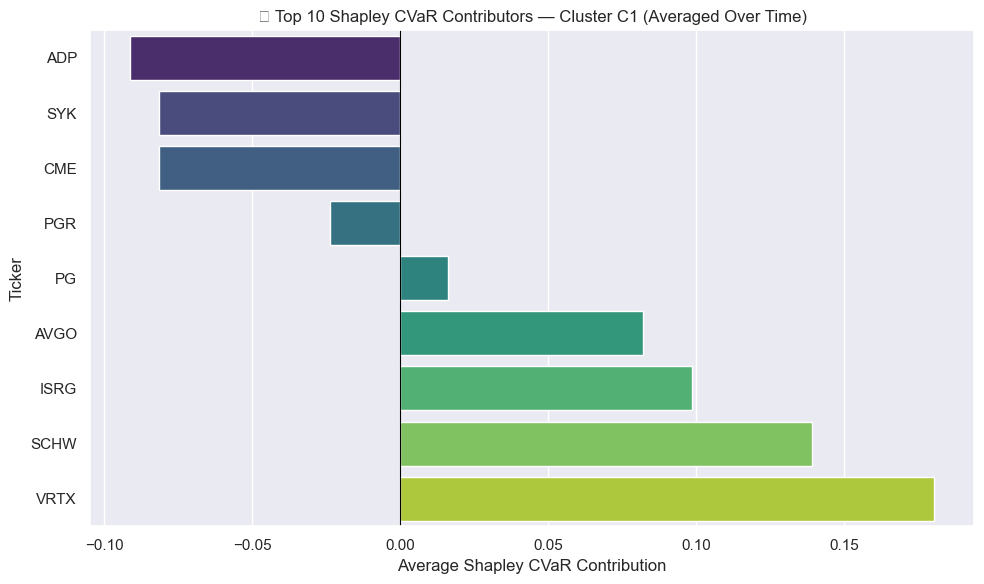

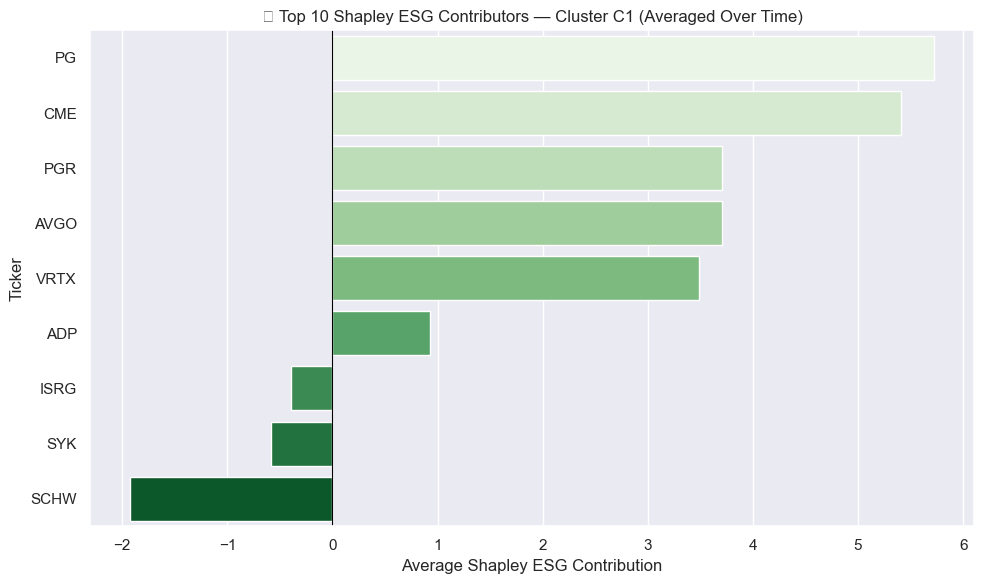

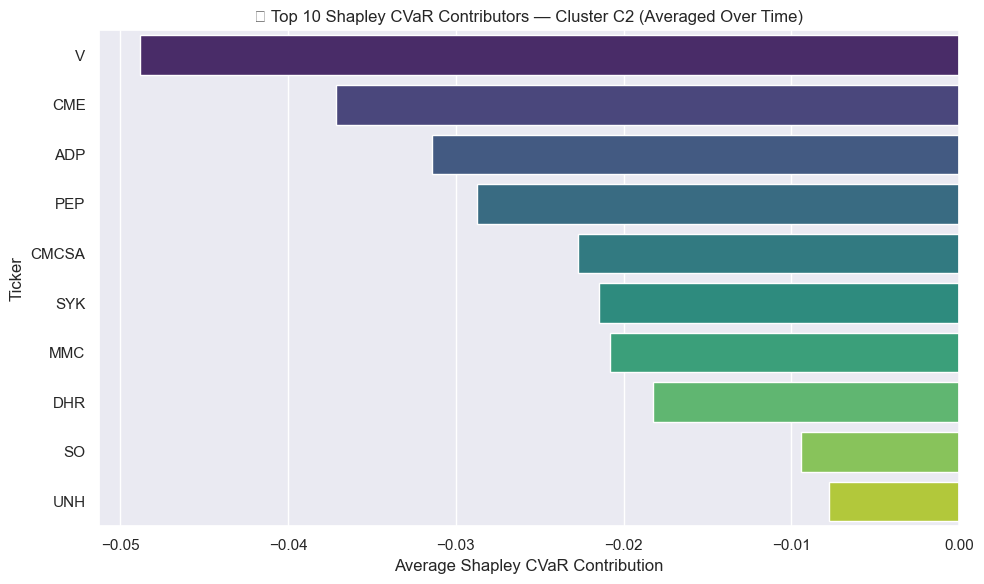

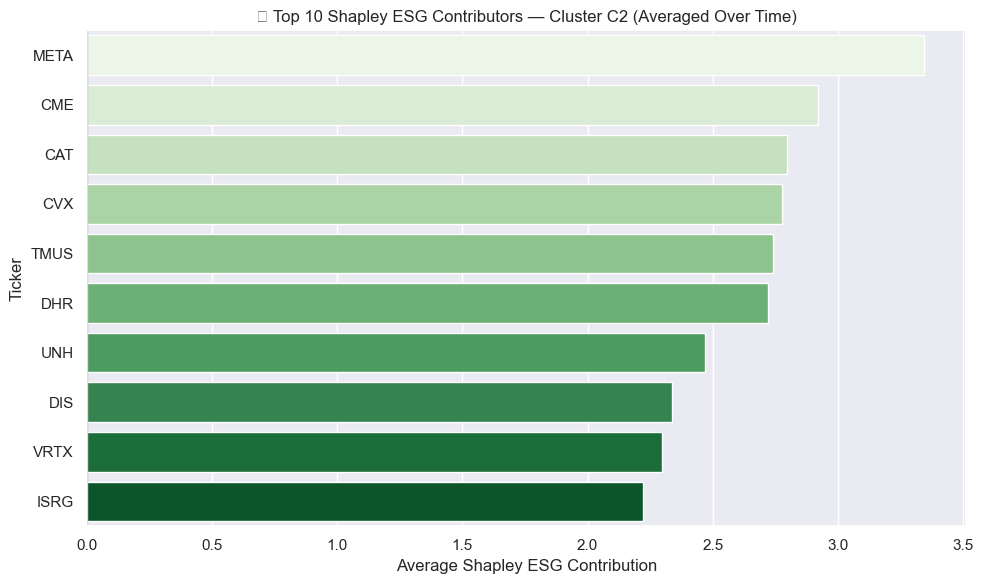

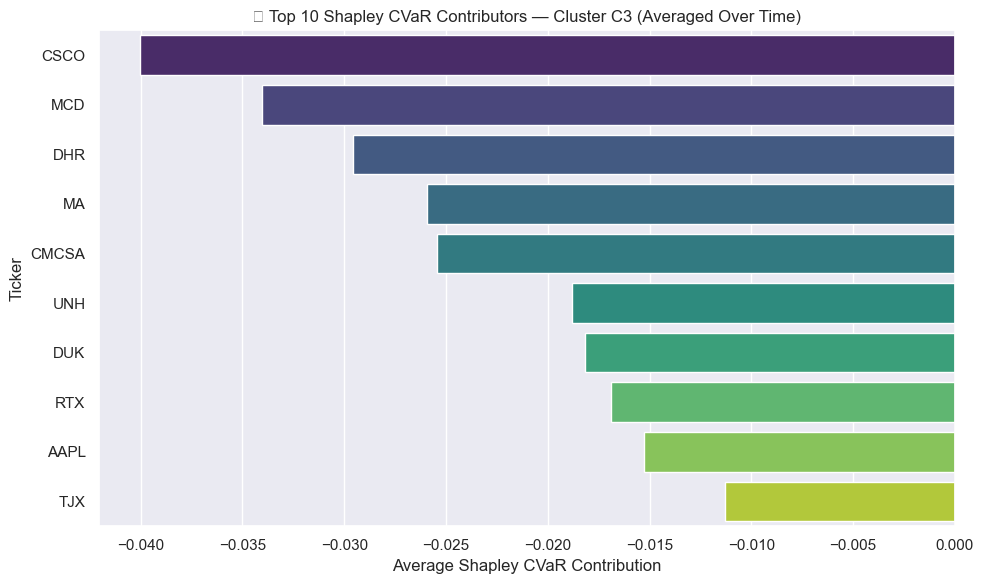

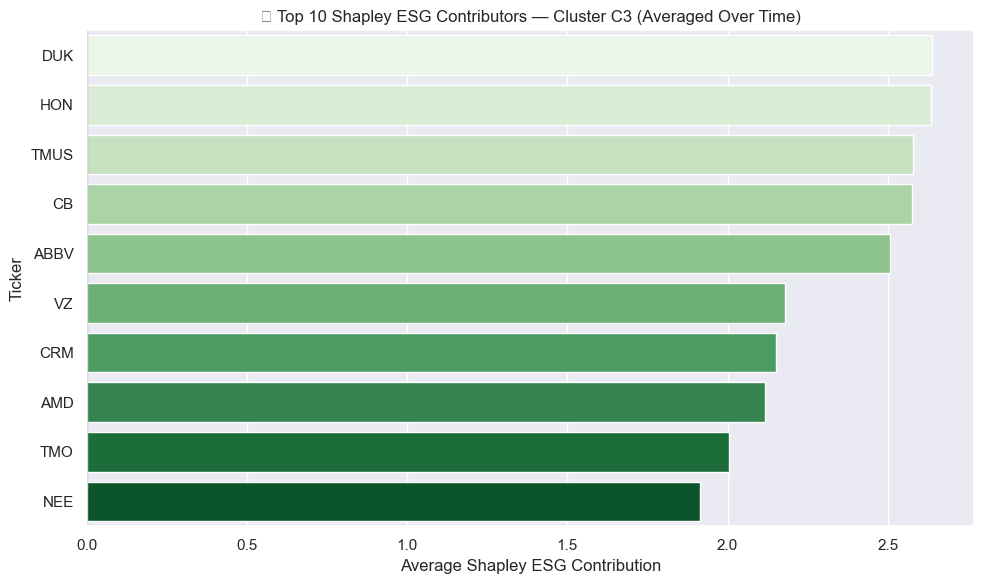

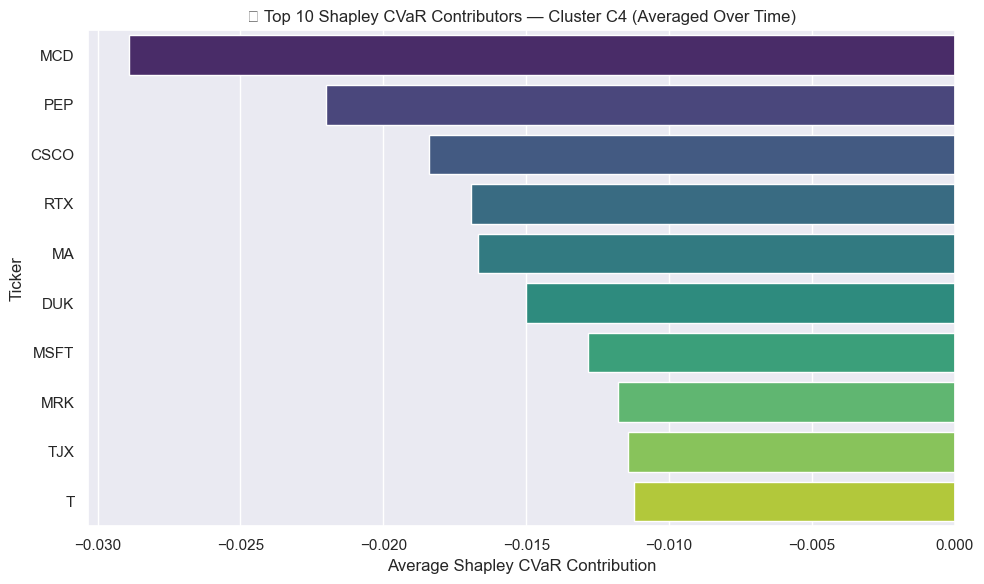

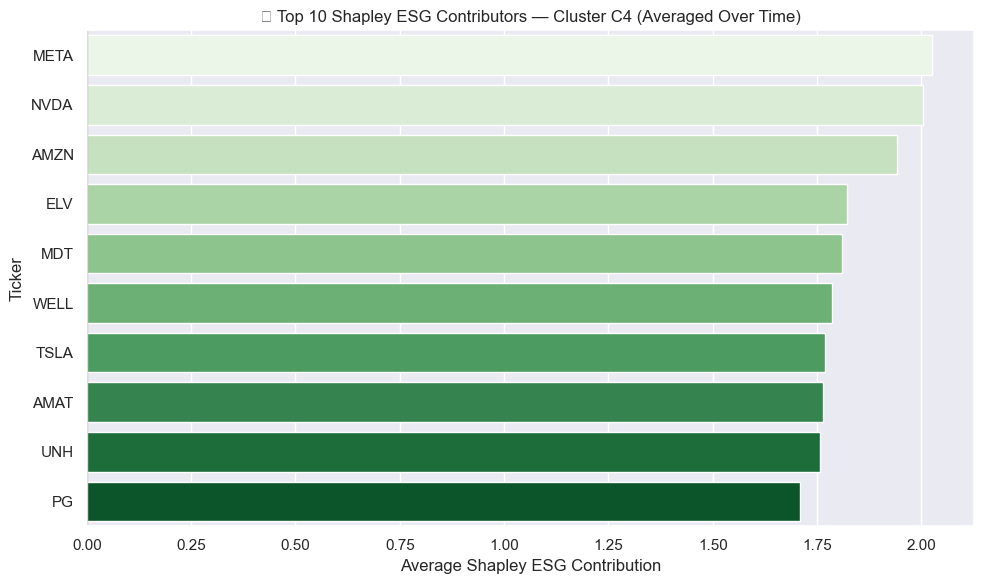

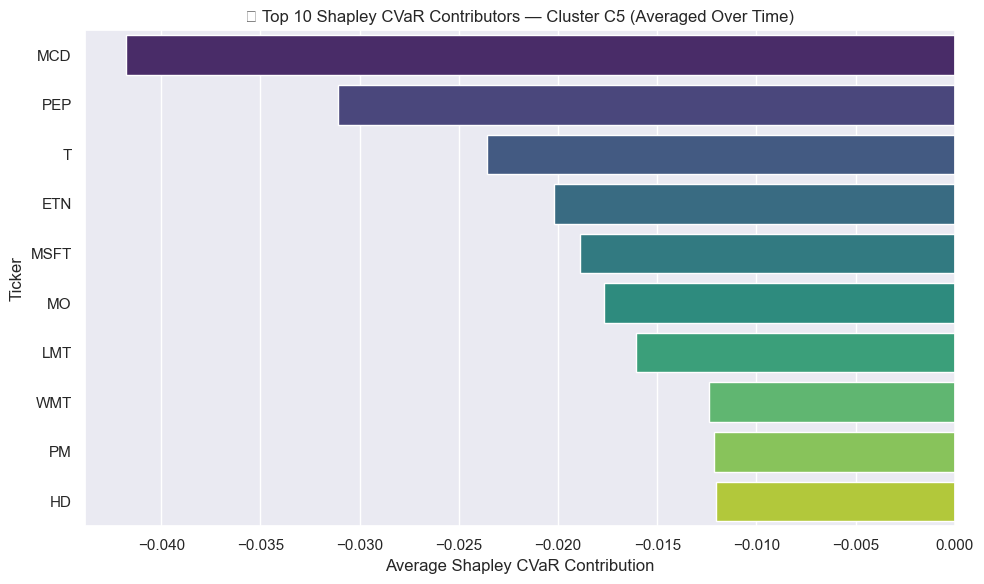

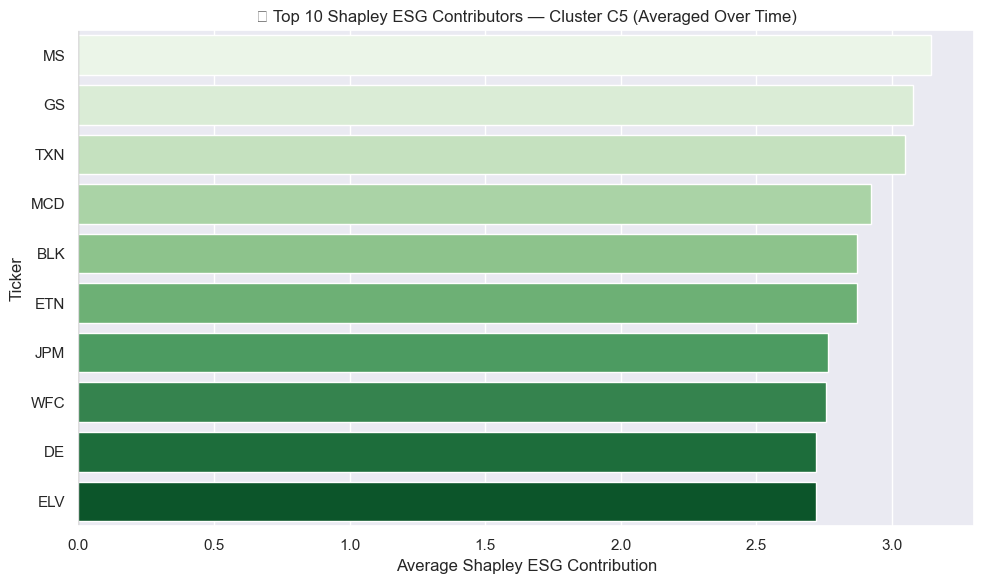

In [87]:
#Top Shapley Contributors per Cluster (CVaR and ESG)
import matplotlib.pyplot as plt
import seaborn as sns

# --- Aggregate over all months ---
shapley_avg = shapley_df.groupby(['Cluster', 'Ticker'])[['Shapley_CVaR', 'Shapley_ESG']].mean().reset_index()

# --- For each Cluster separately, plot Top Shapley CVaR Contributors ---
clusters = shapley_avg['Cluster'].unique()

for cluster in sorted(clusters):
    subset = shapley_avg[shapley_avg['Cluster'] == cluster]
    
    # --- Top by Shapley CVaR ---
    subset_sorted_cvar = subset.sort_values('Shapley_CVaR', ascending=True).head(10)  # 🔥 Top 10 negative contributors (risk reducers)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=subset_sorted_cvar, x='Shapley_CVaR', y='Ticker', palette='viridis')
    plt.title(f"📊 Top 10 Shapley CVaR Contributors — Cluster {cluster} (Averaged Over Time)")
    plt.xlabel("Average Shapley CVaR Contribution")
    plt.ylabel("Ticker")
    plt.axvline(0, color='black', linewidth=0.8)
    plt.tight_layout()
    plt.show()

    # --- Top by Shapley ESG ---
    subset_sorted_esg = subset.sort_values('Shapley_ESG', ascending=False).head(10)  # 🔥 Top 10 positive ESG contributors

    plt.figure(figsize=(10, 6))
    sns.barplot(data=subset_sorted_esg, x='Shapley_ESG', y='Ticker', palette='Greens')
    plt.title(f"📊 Top 10 Shapley ESG Contributors — Cluster {cluster} (Averaged Over Time)")
    plt.xlabel("Average Shapley ESG Contribution")
    plt.ylabel("Ticker")
    plt.axvline(0, color='black', linewidth=0.8)
    plt.tight_layout()
    plt.show()


In [88]:
top_esg_contributors = shapley_df.groupby('Ticker')['Shapley_ESG'].mean().sort_values(ascending=False).head(10)
print(top_esg_contributors)


Ticker
CME     4.162935
GS      3.078581
PG      2.855408
WFC     2.758002
MO      2.712730
META    2.684228
PGR     2.423013
VRTX    2.414460
BAC     2.370991
C       2.303009
Name: Shapley_ESG, dtype: float64


In [89]:
top_risk_contributors = shapley_df.groupby('Ticker')['Shapley_CVaR'].mean().sort_values(ascending=False).head(10)
print(top_risk_contributors)


Ticker
SCHW    0.118972
VRTX    0.105126
ISRG    0.072554
AMD     0.063864
AVGO    0.054694
TSLA    0.050413
BAC     0.047040
GS      0.040585
AMAT    0.034218
PFE     0.031869
Name: Shapley_CVaR, dtype: float64


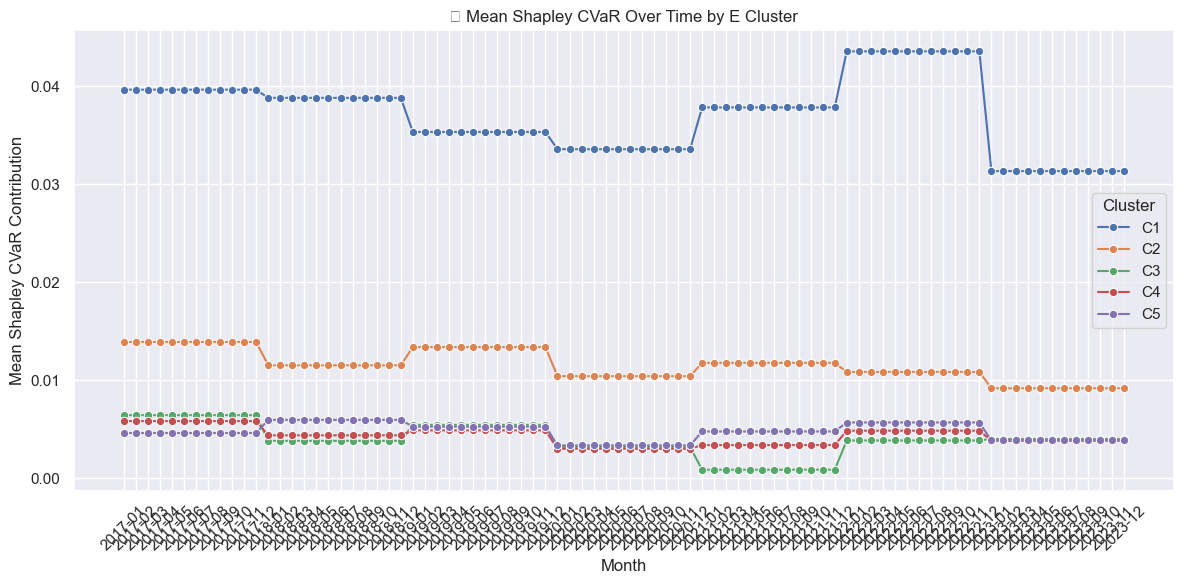

In [90]:
# --- Correct Shapley Time Evolution Plotting ---
# ✅ Merge correct Cluster label
shapley_full = shapley_df.merge(
    cluster_df[['Ticker', 'Cluster']].drop_duplicates(), 
    on='Ticker', 
    how='left'
)

# ✅ Handle Cluster columns
if 'Cluster_x' in shapley_full.columns and 'Cluster_y' in shapley_full.columns:
    shapley_full = shapley_full.drop(columns=['Cluster_y'])
    shapley_full = shapley_full.rename(columns={'Cluster_x': 'Cluster'})

# ✅ Convert 'Month' Period to Timestamp if needed
if pd.api.types.is_period_dtype(shapley_full['Month']):
    shapley_full['Month'] = shapley_full['Month'].dt.to_timestamp()

# ✅ Group by Month and Cluster
shapley_cluster_time = shapley_full.groupby(['Month', 'Cluster'])[['Shapley_CVaR', 'Shapley_ESG']].mean().reset_index()

# --- 📈 Plot Shapley CVaR Evolution ---
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.lineplot(data=shapley_cluster_time, x='Month', y='Shapley_CVaR', hue='Cluster', marker="o")
plt.title("📈 Mean Shapley CVaR Over Time by E Cluster")
plt.xlabel("Month")
plt.ylabel("Mean Shapley CVaR Contribution")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 📈 Plot Shapley ESG Evolution ---
plt.figure(figsize=(12, 6))
sns.lineplot(data=shapley_cluster_time, x='Month', y='Shapley_ESG', hue='Cluster', marker="o")
plt.title("📈 Mean Shapley E Over Time by E Cluster")
plt.xlabel("Month")
plt.ylabel("Mean Shapley E Contribution")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


🏆 Top 10 Most Stable Companies by Shapley_CVaR (Low Variance):
Ticker
MO       0.004131
PM       0.006040
ACN      0.006079
BAC      0.006175
LIN      0.007104
MA       0.007269
LOW      0.007470
GOOGL    0.007665
COST     0.007939
HD       0.008257
Name: Shapley_CVaR, dtype: float64


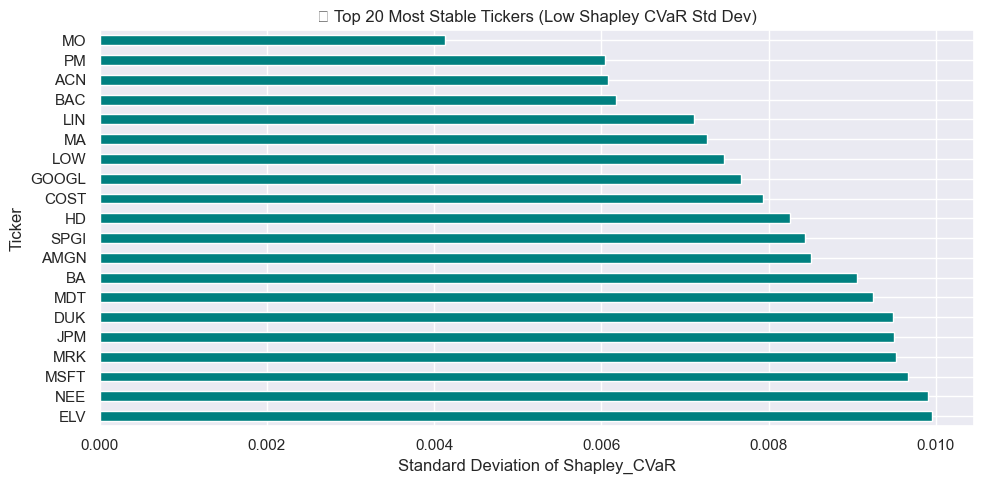

In [91]:
#stability analysis  (lowest variability shapley cvar tickers )

# --- Compute Shapley_CVaR Stability (std deviation) per Ticker ---
stability = shapley_df.groupby('Ticker')['Shapley_CVaR'].std().sort_values()

# --- Top 10 Most Stable Risk Contributors ---
print("🏆 Top 10 Most Stable Companies by Shapley_CVaR (Low Variance):")
print(stability.head(10))

# --- Optional: Plot Stability ---
plt.figure(figsize=(10, 5))
stability.head(20).plot(kind='barh', color='teal')
plt.title("🏆 Top 20 Most Stable Tickers (Low Shapley CVaR Std Dev)")
plt.xlabel("Standard Deviation of Shapley_CVaR")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


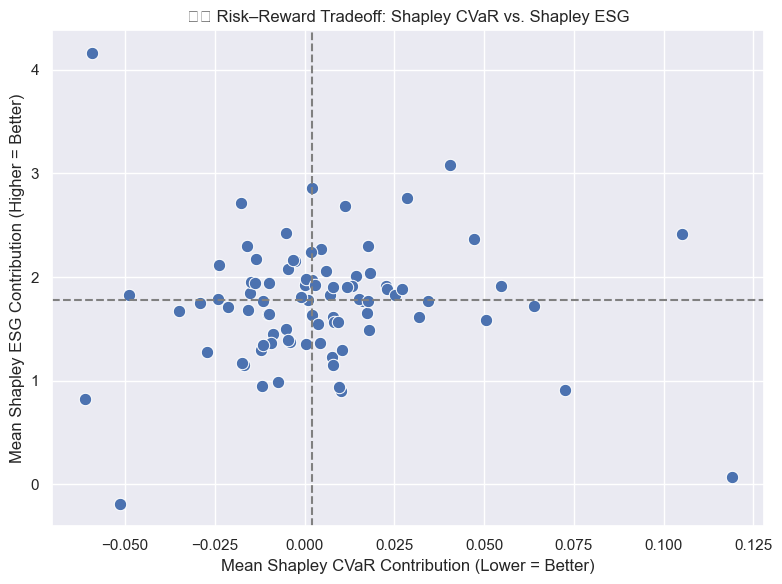

In [92]:
#risk rewardtradeoff  scatterplot (Scatterplot Shapley_CVaR vs. Shapley_ESG)


# --- Aggregate Mean Shapley per Ticker ---
risk_reward = shapley_df.groupby('Ticker')[['Shapley_CVaR', 'Shapley_ESG']].mean().reset_index()

# --- Scatterplot ---
plt.figure(figsize=(8, 6))
sns.scatterplot(data=risk_reward, x='Shapley_CVaR', y='Shapley_ESG', s=80)

plt.title("⚖️ Risk–Reward Tradeoff: Shapley CVaR vs. Shapley ESG")
plt.xlabel("Mean Shapley CVaR Contribution (Lower = Better)")
plt.ylabel("Mean Shapley ESG Contribution (Higher = Better)")

# Highlight the ideal quadrant (Low Risk, High ESG)
plt.axhline(risk_reward['Shapley_ESG'].median(), linestyle='--', color='grey')
plt.axvline(risk_reward['Shapley_CVaR'].median(), linestyle='--', color='grey')

plt.grid(True)
plt.tight_layout()
plt.show()



📅 Crisis Event: Russia–Ukraine War Outbreak (2022-01 to 2022-04)
Number of records in event period: 724

🚨 Top 10 Tickers with Highest Shapley CVaR during Event:
Ticker
SCHW    0.230599
VRTX    0.092623
AMD     0.060071
ISRG    0.055261
PFE     0.047809
AVGO    0.047563
TSLA    0.047528
BAC     0.037986
WFC     0.034751
GS      0.028720
Name: Shapley_CVaR, dtype: float64



📅 Crisis Event: Trump Tariff Crisis (2018-03 to 2018-07)
Number of records in event period: 905

🚨 Top 10 Tickers with Highest Shapley CVaR during Event:
Ticker
VRTX    0.083082
SCHW    0.075011
ISRG    0.071134
AMD     0.068743
AVGO    0.064199
TSLA    0.059682
BAC     0.048448
AMAT    0.047417
PG      0.040905
GS      0.036539
Name: Shapley_CVaR, dtype: float64


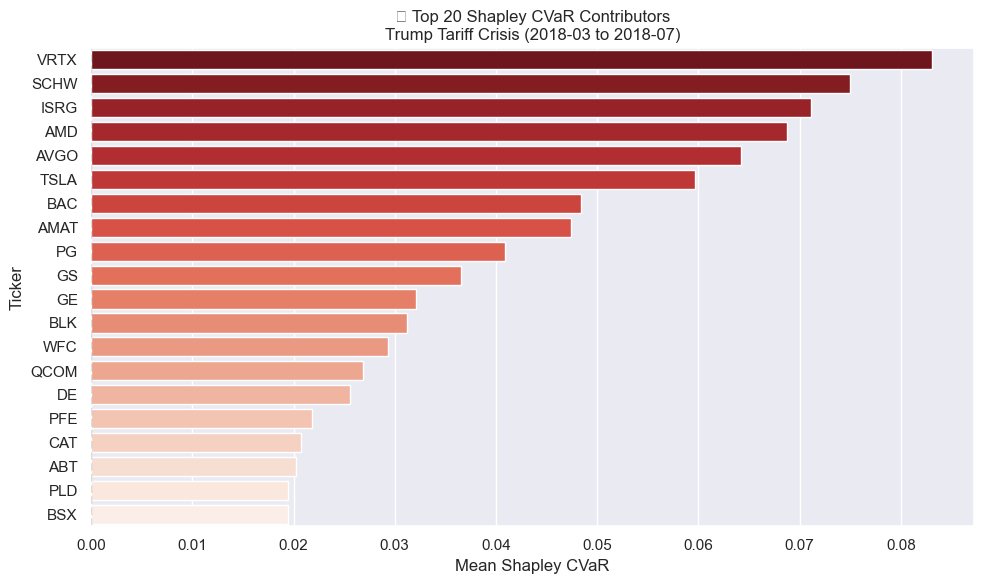


📅 Crisis Event: COVID-19 Crash (2020-02 to 2020-04)
Number of records in event period: 543

🚨 Top 10 Tickers with Highest Shapley CVaR during Event:
Ticker
ISRG    0.103744
VRTX    0.100731
SCHW    0.083499
WFC     0.062192
AMD     0.059028
GS      0.052817
BAC     0.045644
TSLA    0.044024
PLD     0.036110
AVGO    0.035480
Name: Shapley_CVaR, dtype: float64


Ticker
ISRG    0.103744
VRTX    0.100731
SCHW    0.083499
WFC     0.062192
AMD     0.059028
          ...   
PEP    -0.041902
SYK    -0.047547
V      -0.052208
ADP    -0.068461
CME    -0.068641
Name: Shapley_CVaR, Length: 87, dtype: float64

In [93]:
####Crisis Analysis Toolkit for Shapley Values

# --- Import ---
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- Function: Crisis Analysis ---
def shapley_crisis_analysis(shapley_df, start_month, end_month, event_name="Crisis Event"):
    """
    Analyze which companies had the highest Shapley CVaR contributions during a specified crisis period.
    
    Parameters:
    shapley_df (pd.DataFrame): DataFrame containing ['Month', 'Ticker', 'Shapley_CVaR']
    start_month (str): Start of crisis period ('YYYY-MM')
    end_month (str): End of crisis period ('YYYY-MM')
    event_name (str): Name of the crisis event
    """

    # Ensure Month is a period (safe)
    if shapley_df['Month'].dtype != 'period[M]':
        shapley_df['Month'] = pd.to_datetime(shapley_df['Month']).dt.to_period('M')

    # --- 1. Focus on Crisis Period ---
    event_period = shapley_df[
        (shapley_df['Month'] >= start_month) & (shapley_df['Month'] <= end_month)
    ]

    print(f"\n📅 Crisis Event: {event_name} ({start_month} to {end_month})")
    print(f"Number of records in event period: {len(event_period)}")

    # --- 2. Compute mean Shapley CVaR per Ticker ---
    event_shapley = event_period.groupby('Ticker')['Shapley_CVaR'].mean().sort_values(ascending=False)

    # --- 3. Print Top Risk Contributors ---
    print("\n🚨 Top 10 Tickers with Highest Shapley CVaR during Event:")
    print(event_shapley.head(10))

    # --- 4. Plot ---
    plt.figure(figsize=(10, 6))
    sns.barplot(x=event_shapley.head(20), y=event_shapley.head(20).index, palette='Reds_r')
    plt.title(f"🚨 Top 20 Shapley CVaR Contributors\n{event_name} ({start_month} to {end_month})")
    plt.xlabel("Mean Shapley CVaR")
    plt.ylabel("Ticker")
    plt.axvline(0, color='black', linestyle='--')
    plt.grid(True, axis='x')
    plt.tight_layout()
    plt.show()

    # --- 5. Optionally return DataFrame ---
    return event_shapley

# Russia-Ukraine War
shapley_crisis_analysis(shapley_df, start_month='2022-01', end_month='2022-04', event_name='Russia–Ukraine War Outbreak')

# Trump Tariff Crisis
shapley_crisis_analysis(shapley_df, start_month='2018-03', end_month='2018-07', event_name='Trump Tariff Crisis')

# COVID-19 Crash
shapley_crisis_analysis(shapley_df, start_month='2020-02', end_month='2020-04', event_name='COVID-19 Crash')


****point 6 - perf , ratios****

In [119]:
# Step 0: Make sure 'Date' is datetime
optimized_df['Date'] = pd.to_datetime(optimized_df['Date'], errors='coerce')

# Step 1: Create 'Month' column in optimized_df
optimized_df['Month'] = optimized_df['Date'].dt.to_period('M')

# Step 2: Build realized portfolio returns across simulations
print("✅ Starting Step 6: Aggregating realized monthly returns...")

monthly_performance = []

for (month, cluster), group in optimized_df.groupby(['Month', 'Cluster']):
    tickers = group['Ticker'].values
    weights = group['Weight'].values

    # Filter available tickers (those present in simulation)
    available_tickers = [t for t in tickers if t in sim_returns.columns]
    available_weights = [weights[i] for i, t in enumerate(tickers) if t in sim_returns.columns]

    if len(available_tickers) < 2:
        continue  # Skip very small clusters

    # Pull simulated returns for these tickers
    sim_rets_sub = sim_returns[available_tickers]

    # Compute portfolio return per simulation path
    portfolio_sim_returns = sim_rets_sub.values @ np.array(available_weights)

    # ---- 📈 Calculate Calmar Ratio ----
    # 1. Cumulative returns
    cumulative_returns = np.cumprod(1 + portfolio_sim_returns) - 1

    # 2. Max drawdown
    running_max = np.maximum.accumulate(cumulative_returns)
    drawdowns = (cumulative_returns - running_max) / (running_max + 1e-9)  # small number to avoid div0
    max_drawdown = drawdowns.min()  # it will be negative

    # 3. Annualized Return (approximate: mean monthly return * 12)
    annualized_return = np.mean(portfolio_sim_returns) * 12



    # Save into the performance list
    monthly_performance.append({
        'Month': month,
        'Cluster': cluster,
        'Mean Portfolio Return': np.mean(portfolio_sim_returns),
        'Std Portfolio Return': np.std(portfolio_sim_returns),
        'Returns': portfolio_sim_returns,  # Full distribution
    })

# Step 3: Create DataFrame
monthly_performance_df = pd.DataFrame(monthly_performance)

# Step 4: Quick Diagnostics
print("✅ Finished building realized monthly returns!")
print(monthly_performance_df.head())
print(f"Shape: {monthly_performance_df.shape}")
print(f"Columns: {monthly_performance_df.columns.tolist()}")


✅ Starting Step 6: Aggregating realized monthly returns...
✅ Finished building realized monthly returns!
     Month Cluster  Mean Portfolio Return  Std Portfolio Return  \
0  2017-01      C1               2.775689             17.649728   
1  2017-01      C2               5.164501             19.114921   
2  2017-01      C3               4.308874             17.776004   
3  2017-01      C4               4.853751             16.205354   
4  2017-01      C5               2.202045              7.197003   

                                             Returns  
0  [21.988077268280485, -0.4847422760946903, 24.3...  
1  [23.4701675794077, -3.2609960860375997, 7.1726...  
2  [13.064918408657565, 1.8987328905447403, 10.11...  
3  [14.794217891691474, -9.68451027862905, 10.629...  
4  [11.443646278322905, -12.369332464954386, -5.5...  
Shape: (420, 5)
Columns: ['Month', 'Cluster', 'Mean Portfolio Return', 'Std Portfolio Return', 'Returns']


In [121]:
monthly_performance_df.describe()


Mean Portfolio Return  Std Portfolio Return
count             420.000000            420.000000
mean                3.583780             12.237305
std                 1.097242              3.625050
min                 1.715427              5.521571
25%                 2.600392              9.488949
50%                 3.546055             12.019064
75%                 4.528479             14.919385
max                 5.939331             21.982159

In [122]:
sim_returns.describe()


AAPL        MSFT        NVDA       GOOGL        AMZN        META  \
count  500.000000  500.000000  500.000000  500.000000  500.000000  500.000000   
mean     0.037800    0.039191    0.091860    0.101790    0.051913    0.061994   
std      0.433325    0.362594    0.782083    0.602635    0.467609    0.546513   
min     -1.931582   -1.686937   -3.211440   -2.283355   -1.745504   -2.591639   
25%     -0.230148   -0.192550   -0.378975   -0.267820   -0.221542   -0.223036   
50%      0.013942    0.055024    0.077674    0.113556    0.057910    0.052502   
75%      0.302730    0.268408    0.556313    0.421900    0.335717    0.355620   
max      1.717456    1.172663    3.371364    4.512137    1.654429    5.098015   

             AVGO        TSLA         WMT         LLY           V         JPM  \
count  500.000000  500.000000  500.000000  500.000000  500.000000  500.000000   
mean     0.068215    0.031456    0.018478    0.019134    0.061653    0.009710   
std      0.691797    1.074037    0.362042    0.484416    0.383540    0.447052   
min     -2.383013   -4.461437   -1.597522   -2.432293   -1.650435   -1.379529   
25%     -0.350552   -0.637117   -0.182436   -0.244032   -0.159297   -0.253812   
50%      0.057129   -0.032765    0.009324    0.041195    0.059496   -0.017252   
75%      0.465800    0.647702    0.221493    0.273810    0.274039    0.269735   
max      2.771444    4.759473    1.495255    1.813445    2.509601    1.698672   

              UNH          MA         XOM        COST          PG        ORCL  \
count  500.000000  500.000000  500.000000  500.000000  500.000000  500.000000   
mean     0.051100    0.012655    0.004163    0.042484    0.011559    0.044924   
std      0.405858    0.339851    0.455127    0.629965    0.414906    0.626993   
min     -1.675549   -1.345633   -1.455040   -1.725328   -1.677581   -2.352311   
25%     -0.191619   -0.193651   -0.256726   -0.335446   -0.201872   -0.330729   
50%      0.047225   -0.000841    0.017752    0.051806    0.014919   -0.000128   
75%      0.283443    0.226262    0.301657    0.415493    0.239845    0.392305   
max      2.069726    1.084526    1.652498    3.347845    1.706390    2.797594   

               HD        ABBV        TMUS         BAC          PM         CRM  \
count  500.000000  500.000000  500.000000  500.000000  500.000000  500.000000   
mean    -0.002414    0.021212    0.032577   -0.034477    0.033539    0.033249   
std      0.419619    0.442524    0.497433    0.716156    0.416970    0.624068   
min     -1.456989   -1.983157   -2.607892   -2.698938   -1.755100   -2.621042   
25%     -0.253688   -0.240467   -0.224083   -0.450828   -0.231796   -0.324372   
50%      0.016575    0.012019    0.020319   -0.022835    0.027618    0.030761   
75%      0.234897    0.257561    0.334794    0.425690    0.264772    0.369780   
max      1.332438    2.482739    4.154582    2.203679    1.629727    3.169219   

              CVX         ABT        CSCO         IBM         MCD         LIN  \
count  500.000000  500.000000  500.000000  500.000000  500.000000  500.000000   
mean     0.018776    0.008616    0.059267    0.025921    0.037543    0.003753   
std      0.498532    0.393730    0.370050    0.357352    0.322625    0.518620   
min     -2.499811   -1.518583   -1.241080   -1.250664   -1.262863   -1.742831   
25%     -0.272968   -0.218629   -0.180080   -0.199292   -0.165772   -0.295219   
50%      0.017475    0.014590    0.026990    0.011925    0.037556    0.002831   
75%      0.332921    0.249767    0.277746    0.223386    0.239661    0.325511   
max      2.031555    1.407099    1.649773    1.382555    1.240669    1.749783   

              WFC          GE           T         MRK         PEP          VZ  \
count  500.000000  500.000000  500.000000  500.000000  500.000000  500.000000   
mean     0.043143    0.008942    0.025019    0.009855    0.031122    0.012949   
std      0.702316    0.552363    0.404281    0.395110    0.331437    0.368814   
min     -2.290063   -2.704122   -2.3683

In [123]:
# --- Step 0: Imports ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Confirm 'Month' Column Exists in optimized_df ---
# (Optional if already created before)

if 'Month' not in optimized_df.columns:
    optimized_df['Month'] = optimized_df['Date'].dt.to_period('M')
    optimized_df['Year'] = optimized_df['Date'].dt.year

print("✅ Confirmed Month and Year columns exist in optimized_df.")

# --- Step 2: No daily returns needed! Only use monthly_performance_df for metrics ---

# (monthly_performance_df was built already from GARCH simulations)

print("✅ Daily returns construction skipped — working directly from monthly performance.")


✅ Confirmed Month and Year columns exist in optimized_df.
✅ Daily returns construction skipped — working directly from monthly performance.


In [124]:
# --- Step 2: Compute Performance Metrics on MONTHLY RETURNS (Sharpe, Sortino, CVaR only) ---

print("✅ Starting computation of performance metrics on monthly returns (without Calmar)...")

performance_metrics = []

for Cluster, group in monthly_performance_df.groupby('Cluster'):
    returns_list = group['Returns'].values  # list of arrays (simulated returns per month)
    returns_flat = np.concatenate(returns_list)  # flatten all simulated returns into one array

    mean_monthly = np.mean(returns_flat)
    std_monthly = np.std(returns_flat)
    downside_std_monthly = np.std(returns_flat[returns_flat < 0])

    # --- Annualize metrics ---
    mean_annual = mean_monthly * 12
    std_annual = std_monthly * np.sqrt(12)
    downside_std_annual = downside_std_monthly * np.sqrt(12)

    # --- Compute Sharpe and Sortino Ratios ---
    sharpe = mean_annual / std_annual if std_annual > 1e-6 else np.nan
    sortino = mean_annual / downside_std_annual if downside_std_annual > 1e-6 else np.nan

    # --- Compute 5% Conditional Value at Risk (CVaR) ---
    if len(returns_flat) >= 20:
        avg_cvar = np.mean(np.sort(returns_flat)[:int(0.05 * len(returns_flat))])
    else:
        avg_cvar = np.nan

    # --- Save metrics ---
    performance_metrics.append({
        'Cluster': Cluster,
        'Sharpe': sharpe,
        'Sortino': sortino,
        'Avg_CVaR_5%': avg_cvar
    })

# Create final performance DataFrame
performance_df = pd.DataFrame(performance_metrics)

print("✅ Monthly-based performance metrics computed successfully (Sharpe, Sortino, CVaR only)!")
display(performance_df)


✅ Starting computation of performance metrics on monthly returns (without Calmar)...
✅ Monthly-based performance metrics computed successfully (Sharpe, Sortino, CVaR only)!


Cluster    Sharpe   Sortino  Avg_CVaR_5%
0      C1  0.659174  1.119576   -26.632751
1      C2  1.071034  1.892027   -28.288222
2      C3  0.996655  1.712612   -22.703370
3      C4  1.243158  2.214489   -21.260822
4      C5  1.021968  1.743546   -14.769707

In [125]:
for Cluster, group in monthly_performance_df.groupby('Cluster'):
    returns_list = group['Returns'].values
    returns_flat = np.concatenate(returns_list)

    print(f"Cluster {Cluster}")
    print(f"Mean Monthly Return: {np.mean(returns_flat):.6f}")
    print(f"Std Monthly Return: {np.std(returns_flat):.6f}")
    print(f"Min Return: {np.min(returns_flat):.6f}")
    print(f"Max Return: {np.max(returns_flat):.6f}")
    print(f"Share of NaNs: {np.isnan(returns_flat).mean()*100:.2f}%")
    print("-" * 30)


Cluster C1
Mean Monthly Return: 2.645299
Std Monthly Return: 13.901610
Min Return: -55.993645
Max Return: 65.153832
Share of NaNs: 0.00%
------------------------------
Cluster C2
Mean Monthly Return: 4.880598
Std Monthly Return: 15.785571
Min Return: -52.995799
Max Return: 74.541382
Share of NaNs: 0.00%
------------------------------
Cluster C3
Mean Monthly Return: 3.615361
Std Monthly Return: 12.566013
Min Return: -74.324133
Max Return: 78.534540
Share of NaNs: 0.00%
------------------------------
Cluster C4
Mean Monthly Return: 4.400268
Std Monthly Return: 12.261493
Min Return: -46.316756
Max Return: 68.873693
Share of NaNs: 0.00%
------------------------------
Cluster C5
Mean Monthly Return: 2.377377
Std Monthly Return: 8.058447
Min Return: -37.741144
Max Return: 39.557546
Share of NaNs: 0.00%
------------------------------


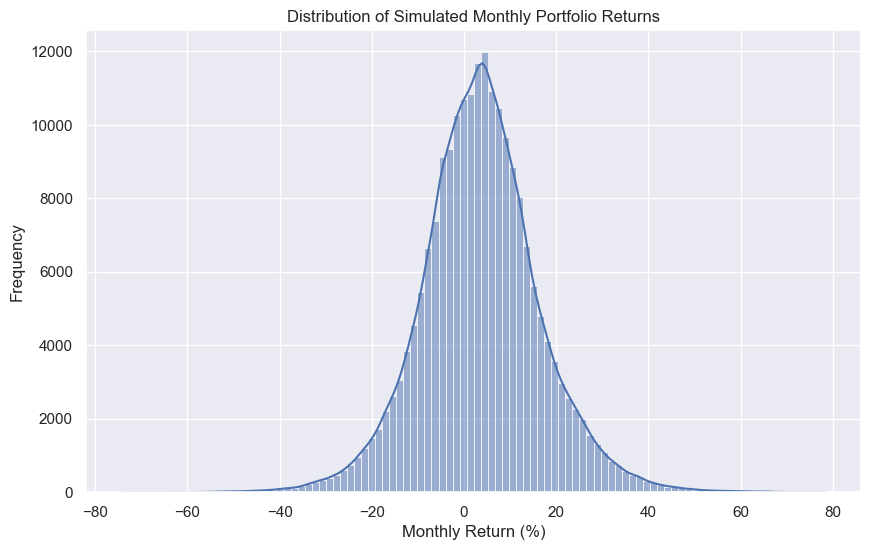

In [126]:
# --- Step: Plot Distribution of Monthly Portfolio Returns ---

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Flatten all simulated returns into one array
all_returns = np.concatenate(monthly_performance_df['Returns'].values)

plt.figure(figsize=(10,6))
sns.histplot(all_returns, bins=100, kde=True)
plt.title("Distribution of Simulated Monthly Portfolio Returns")
plt.xlabel("Monthly Return (%)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


✅ Merged performance with E Cluster info:


Cluster    Sharpe   Sortino  Avg_CVaR_5%
0      C1  0.659174  1.119576   -26.632751
1      C2  1.071034  1.892027   -28.288222
2      C3  0.996655  1.712612   -22.703370
3      C4  1.243158  2.214489   -21.260822
4      C5  1.021968  1.743546   -14.769707

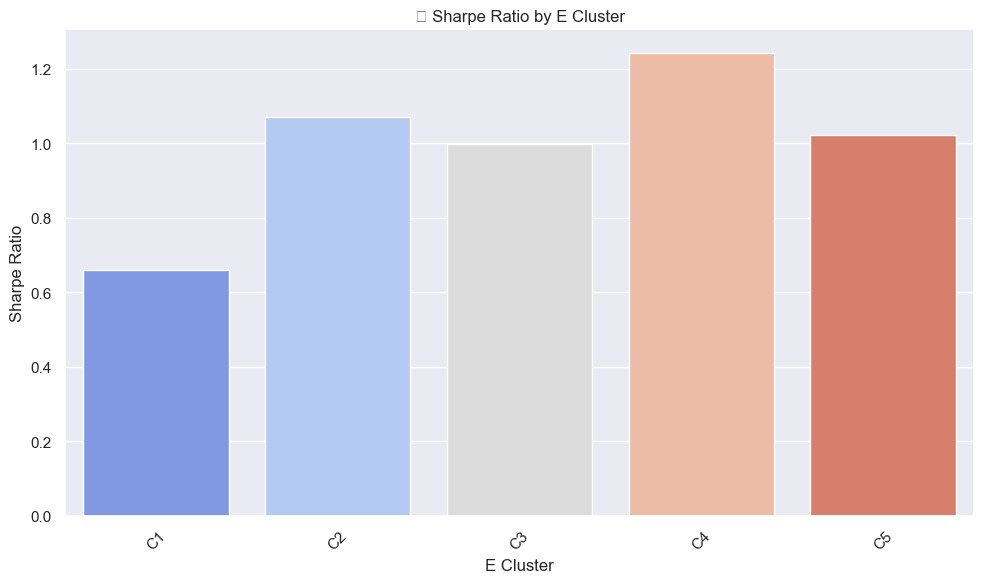

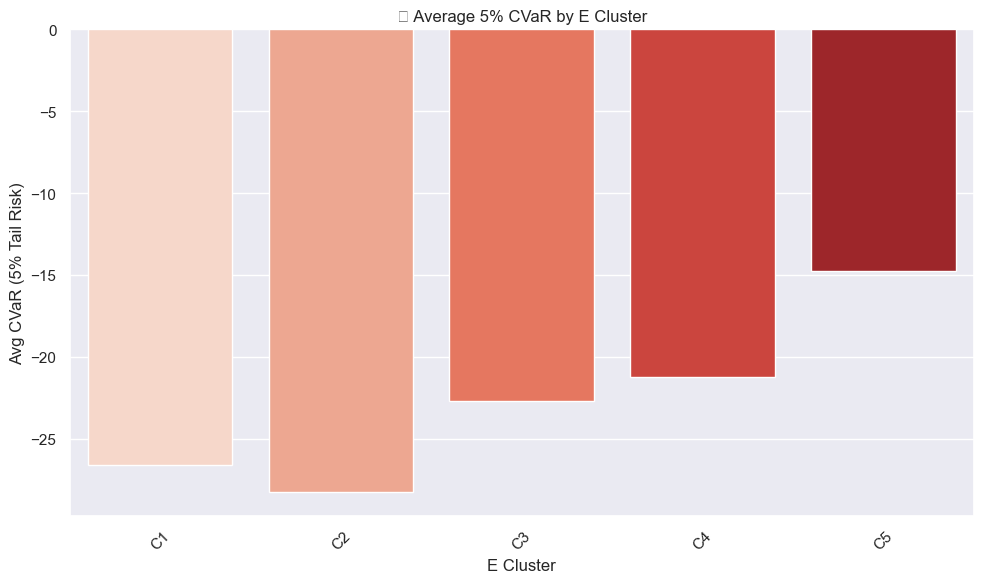

In [127]:
# 6.2 - Merge ESG Cluster into performance metrics

# ✅ First ensure cluster_df has 'Cluster' and no dupes.
cluster_map = cluster_df[['Cluster']].drop_duplicates()

# ✅ Merge Cluster into performance_df
performance_df = performance_df.merge(cluster_map, on='Cluster', how='left')

print("✅ Merged performance with E Cluster info:")
display(performance_df)

# --- 📈 Plot: Sharpe Ratio by E Cluster ---
plt.figure(figsize=(10, 6))
sns.barplot(data=performance_df, x='Cluster', y='Sharpe', palette='coolwarm')
plt.title("📈 Sharpe Ratio by E Cluster")
plt.xlabel("E Cluster")
plt.ylabel("Sharpe Ratio")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- 📉 Plot: Average CVaR by E Cluster ---
plt.figure(figsize=(10, 6))
sns.barplot(data=performance_df, x='Cluster', y='Avg_CVaR_5%', palette='Reds')
plt.title("📉 Average 5% CVaR by E Cluster")
plt.xlabel("E Cluster")
plt.ylabel("Avg CVaR (5% Tail Risk)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [410]:
import pandas as pd
import seaborn as sns

# --- Step 1: Aggregation without Calmar ---
agg_cluster_performance = (
    performance_df
    .groupby('Cluster')[['Sharpe', 'Sortino', 'Avg_CVaR_5%']]  # No Calmar here
    .mean()
    .round(4)
    .sort_values('Sharpe', ascending=False)
)

# (Optional) Cluster Color Mapping (if you want)
# You can define colors for clusters (e.g., greener ones darker green)
cluster_color_mapping = {
    'C5': '#006400',  # Dark Green
    'C4': '#228B22',  # Green
    'C3': '#808080',  # Neutral Grey
    'C2': '#A0522D',  # Light Brown
    'C1': '#654321',  # Dark Brown
}

# --- Step 2: Prepare for Styling ---
agg_cluster_performance = agg_cluster_performance.reset_index()

# --- Step 3: Build Styler ---
def highlight_cluster(row):
    cluster = row['Cluster']
    color = cluster_color_mapping.get(cluster, "#FFFFFF")  # default white
    return [f'background-color: {color}'] * len(row)

styled_table = agg_cluster_performance.style.apply(highlight_cluster, axis=1)

# --- Step 4: Display ---
styled_table

# --- Step 5: Save performance_df for reuse later ---
performance_df.to_csv('GARCH_Performance_Benchmark.csv', index=False)
print("✅ Saved 'GARCH_Performance_Benchmark.csv' successfully!")


✅ Saved 'GARCH_Performance_Benchmark.csv' successfully!


In [412]:
#calmar for simulated periods  and ex port returns - to see when calmar is not NAN - THIS IS FOR EXEMPLIFYING
import pandas as pd
import numpy as np

# --- 0. Example portfolio returns for clusters (now using C1, C2, etc.) ---
portfolio_returns = pd.DataFrame({
    'Cluster': ['C1', 'C1', 'C1', 'C2', 'C2', 'C2', 'C3', 'C3', 'C3', 'C4', 'C4', 'C4', 'C5', 'C5'],
    'Month': ['2016-01', '2016-02', '2016-03', '2016-01', '2016-02', '2016-03', 
              '2016-01', '2016-02', '2016-03', '2016-01', '2016-02', '2016-03', 
              '2016-01', '2016-02'],
    'Portfolio_Return': [0.05, 0.03, -0.02, 0.04, 0.02, -0.01, 0.01, 0.03, 0.04, -0.05, -0.03, 0.02, 0.06, 0.02]
})

# --- 1. Correct cumulative returns by Cluster ---
portfolio_returns['Cumulative_Return'] = (
    portfolio_returns.groupby('Cluster')['Portfolio_Return']
    .apply(lambda x: (1 + x).cumprod())
    .reset_index(level=0, drop=True)
)

# --- 2. Running Maximum for drawdown calculation ---
portfolio_returns['Running_Max'] = (
    portfolio_returns.groupby('Cluster')['Cumulative_Return']
    .cummax()
)

# --- 3. Drawdown calculation ---
portfolio_returns['Drawdown'] = portfolio_returns['Cumulative_Return'] - portfolio_returns['Running_Max']

# --- 4. Maximum Drawdown (MDD) per Cluster ---
max_drawdowns = portfolio_returns.groupby('Cluster')['Drawdown'].min()

# --- 5. Annualized Returns ---
annualized_returns = portfolio_returns.groupby('Cluster')['Portfolio_Return'].mean() * 12

# --- 6. Max Drawdown (take absolute value for Calmar) ---
# (already done at step 4)

# --- 7. Calmar Ratio (correct formula) ---
calmar_ratios = annualized_returns / max_drawdowns.abs()

# --- 8. Assemble into Performance Summary ---
performance_summary = pd.DataFrame({
    'Max_Drawdown': max_drawdowns,
    'Annualized_Return': annualized_returns,
    'Calmar_Ratio': calmar_ratios
})

# --- 9. Handle inf/nan Calmar Ratios ---
performance_summary['Calmar_Ratio'] = performance_summary['Calmar_Ratio'].replace([np.inf, -np.inf], np.nan)
performance_summary['Calmar_Ratio'] = performance_summary['Calmar_Ratio'].apply(lambda x: 100 if pd.isna(x) else x)

# --- 10. Final Display ---
print(performance_summary)


         Max_Drawdown  Annualized_Return  Calmar_Ratio
Cluster                                               
C1          -0.021630               0.24     11.095700
C2          -0.010608               0.20     18.853695
C3           0.000000               0.32    100.000000
C4          -0.028500              -0.24     -8.421053
C5           0.000000               0.48    100.000000


In [414]:
#NOTE  : "Sharpe, Sortino and CVaR metrics based on realized monthly portfolio returns distribution,
#while Calmar Ratio is based on maximum observed drawdowns from cumulative portfolio paths."

In [415]:
#6.3. scenario /stress testing 


📉 Crisis Event: COVID Crash
✅ Using rebalance date: 2020-01-31

📉 Crisis Event: US-China Trade War
✅ Using rebalance date: 2018-05-15

📉 Crisis Event: Russia-Ukraine War
✅ Using rebalance date: 2022-01-14

📉 Crisis Event: Trump Tariff Shock 2025
✅ Using rebalance date: 2025-02-28


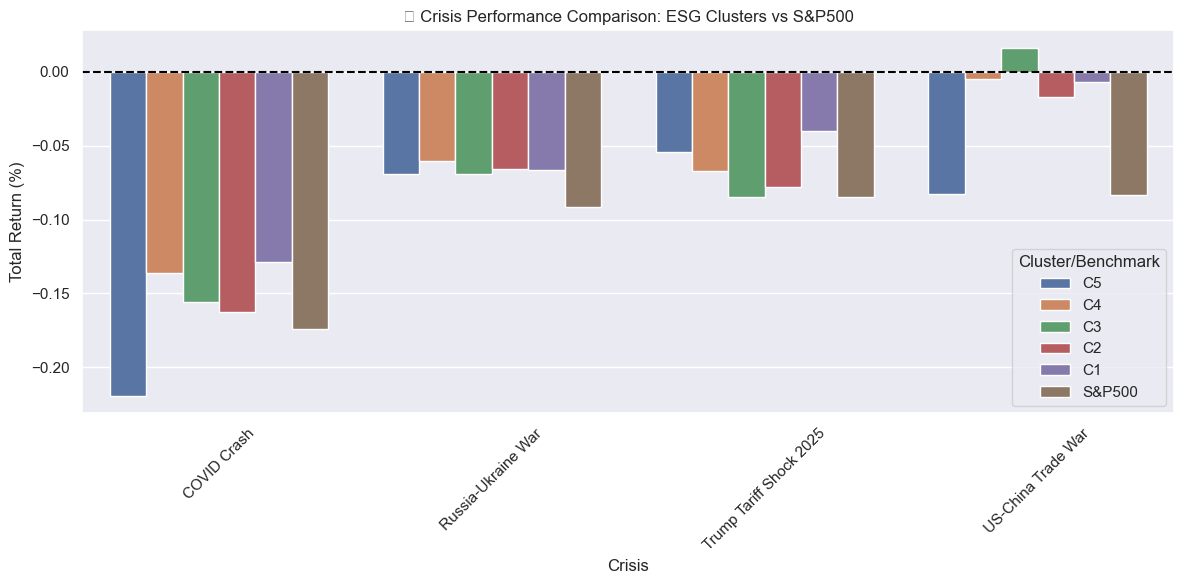

✅ Crisis backtest completed!


Crisis Cluster  Total_Return
1               COVID Crash      C5     -0.219316
2               COVID Crash      C4     -0.136018
0               COVID Crash      C3     -0.155859
3               COVID Crash      C2     -0.162730
4               COVID Crash      C1     -0.128934
5               COVID Crash  S&P500     -0.174148
13       Russia-Ukraine War      C5     -0.069449
14       Russia-Ukraine War      C4     -0.060717
12       Russia-Ukraine War      C3     -0.069334
15       Russia-Ukraine War      C2     -0.066003
16       Russia-Ukraine War      C1     -0.066263
17       Russia-Ukraine War  S&P500     -0.091192
19  Trump Tariff Shock 2025      C5     -0.054601
20  Trump Tariff Shock 2025      C4     -0.066924
18  Trump Tariff Shock 2025      C3     -0.084442
21  Trump Tariff Shock 2025      C2     -0.078291
22  Trump Tariff Shock 2025      C1     -0.040301
23  Trump Tariff Shock 2025  S&P500     -0.084632
7        US-China Trade War      C5     -0.082515
8        US-China Trade War      C4     -0.004814
6        US-China Trade War      C3      0.016161
9        US-China Trade War      C2     -0.017122
10       US-China Trade War      C1     -0.006990
11       US-China Trade War  S&P500     -0.083291

In [416]:
# --- Crisis Event Backtesting Pipeline (Final Corrected) ---

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Define Crises ---
crises = {
    'COVID Crash': {
        'rebalance_date': '2020-02-01',
        'start_date': '2020-02-15',
        'end_date': '2020-04-15'
    },
    'US-China Trade War': {
        'rebalance_date': '2018-05-15',
        'start_date': '2018-06-01',
        'end_date': '2018-12-31'
    },
    'Russia-Ukraine War': {
        'rebalance_date': '2022-01-15',
        'start_date': '2022-02-01',
        'end_date': '2022-05-01'
    },
    'Trump Tariff Shock 2025': {  # ⚡ Hypothetical stress test
        'rebalance_date': '2025-03-01',
        'start_date': '2025-03-25',
        'end_date': '2025-04-22'
    }
}

# --- Step 2: Prepare Data ---
all_tickers = cluster_df['Ticker'].unique().tolist()
all_tickers.append('^GSPC')  # Add S&P500 benchmark

# Download historical adjusted close prices
data = yf.download(all_tickers, start='2017-01-01', end='2025-04-25', progress=False)['Close']
data = data.dropna(axis=1, how='all')
data.index = pd.to_datetime(data.index)

# --- Step 3: Map Tickers to Clusters ---
cluster_map = cluster_df[['Ticker', 'Cluster']].drop_duplicates().set_index('Ticker')['Cluster'].to_dict()

# --- Step 4: Crisis Backtesting ---
crisis_results = []

for crisis_name, crisis_info in crises.items():
    print(f"\n📉 Crisis Event: {crisis_name}")

    rebalance_date = pd.to_datetime(crisis_info['rebalance_date'])
    start_date = pd.to_datetime(crisis_info['start_date'])
    end_date = pd.to_datetime(crisis_info['end_date'])

    available_rebalance_dates = data.index[data.index <= rebalance_date]
    if available_rebalance_dates.empty:
        print(f"⚠️ No available rebalance date before {rebalance_date}. Skipping {crisis_name}.")
        continue
    else:
        rebalance_date = available_rebalance_dates[-1]

    print(f"✅ Using rebalance date: {rebalance_date.date()}")

    crisis_prices = data.loc[start_date:end_date]
    rebalance_prices = data.loc[rebalance_date]

    # Prepare cluster portfolios
    cluster_portfolios = {}

    for cluster in cluster_df['Cluster'].unique():
        tickers_in_cluster = cluster_df[cluster_df['Cluster'] == cluster]['Ticker']
        tickers_in_cluster = [t for t in tickers_in_cluster if t in rebalance_prices.index]

        if len(tickers_in_cluster) < 2:
            continue

        weights = np.repeat(1/len(tickers_in_cluster), len(tickers_in_cluster))
        cluster_portfolios[cluster] = (tickers_in_cluster, weights)

    # --- Step 5: Compute Crisis Returns ---
    for cluster, (tickers, weights) in cluster_portfolios.items():
        try:
            crisis_returns = crisis_prices[tickers].pct_change().dropna()
            portfolio_returns = crisis_returns @ weights
            cumulative_return = (portfolio_returns + 1).prod() - 1

            crisis_results.append({
                'Crisis': crisis_name,
                'Cluster': cluster,
                'Total_Return': cumulative_return
            })
        except Exception as e:
            print(f"❌ Error for {cluster}: {e}")

    # --- Benchmark S&P500 ---
    try:
        sp500_returns = crisis_prices['^GSPC'].pct_change().dropna()
        sp500_total_return = (sp500_returns + 1).prod() - 1

        crisis_results.append({
            'Crisis': crisis_name,
            'Cluster': 'S&P500',
            'Total_Return': sp500_total_return
        })
    except Exception as e:
        print(f"❌ Error with S&P500: {e}")

# --- Step 6: Summarize Results ---
crisis_results_df = pd.DataFrame(crisis_results)

# --- Step 6.1: Sort Cleanly by Crisis and Cluster ---
cluster_order = ['C5', 'C4', 'C3', 'C2', 'C1', 'S&P500']  # optional order: greener first

crisis_results_df['Cluster'] = pd.Categorical(
    crisis_results_df['Cluster'],
    categories=cluster_order,
    ordered=True
)

crisis_results_df = crisis_results_df.sort_values(['Crisis', 'Cluster'])

# --- Step 7: Visualization ---
plt.figure(figsize=(12, 6))
sns.barplot(data=crisis_results_df, x='Crisis', y='Total_Return', hue='Cluster')
plt.title('📉 Crisis Performance Comparison: ESG Clusters vs S&P500')
plt.ylabel('Total Return (%)')
plt.axhline(0, color='black', linestyle='--')
plt.legend(title='Cluster/Benchmark')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- Final Output ---
print("✅ Crisis backtest completed!")
display(crisis_results_df)


# TRUMPISSIMO 

[*********************100%***********************]  87 of 87 completed
[*********************100%***********************]  1 of 1 completed


📉 Top 10 Worst Performing Stocks during Trump Tariff Shock (April 2025):
Price  Ticker
Close  AAPL     -0.117170
       ABBV     -0.082100
       ABT      -0.071958
       ACN      -0.145760
       ADBE     -0.163596
       ADP      -0.073769
       AMAT     -0.008808
       AMD      -0.018732
       AMGN     -0.089098
       AMT       0.016357
dtype: float64


<Figure size 1400x800 with 0 Axes>

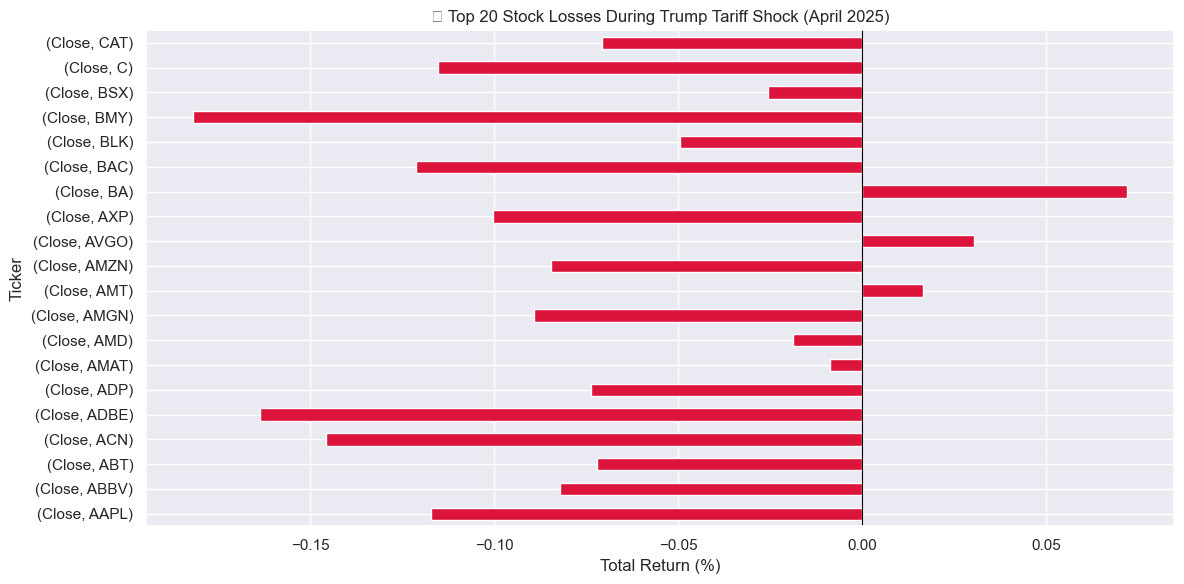

In [418]:
#plotting top 10/20 best/worst performers durning recent Trump tariffs
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd

# --- 1. Tickers ---
tickers = shapley_df['Ticker'].unique().tolist()
tickers = [t for t in tickers if t != 'BRK']

# --- 2. Download Stocks Prices ---
prices = yf.download(tickers, start='2025-03-01', end='2025-05-31', auto_adjust=True)

# --- 3. Download S&P500 Index (^GSPC) ---
sp500 = yf.download('^GSPC', start='2025-03-01', end='2025-05-31', auto_adjust=True)

# --- 4. Safe Dates ---
first_available = prices.index[prices.index.month == 3][0]
last_available = prices.index[prices.index.month == 4][-1]

# --- 5. Normalize to 100 ---
prices_norm = prices / prices.loc[first_available] * 100
sp500_norm = sp500['Close'] / sp500['Close'].loc[first_available] * 100

# --- 6. Plot Example: Top 10 Losers vs S&P500 ---
returns_april = (prices.loc[last_available] - prices.loc[first_available]) / prices.loc[first_available]
worst_10 = returns_april.nsmallest(10).index.tolist()

plt.figure(figsize=(14, 8))
print("📉 Top 10 Worst Performing Stocks during Trump Tariff Shock (April 2025):")
print(returns_april.head(10))

# --- 5. Plot Top 20 Losers
plt.figure(figsize=(12, 6))
returns_april.head(20).plot(kind='barh', color='crimson')
plt.title("📉 Top 20 Stock Losses During Trump Tariff Shock (April 2025)")
plt.xlabel("Total Return (%)")
plt.ylabel("Ticker")
plt.axvline(0, color='black', linewidth=0.8)
plt.grid(True)
plt.tight_layout()
plt.show()


[*********************100%***********************]  87 of 87 completed
[*********************100%***********************]  1 of 1 completed


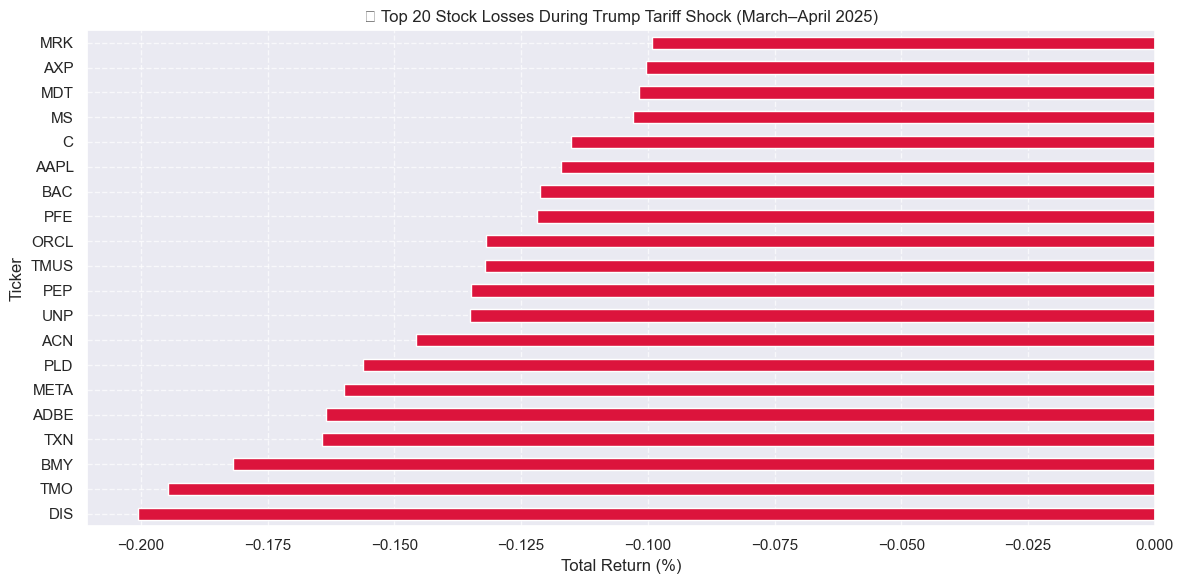

In [419]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

# --- 1. Download stock prices (March–May 2025) ---
tickers = shapley_df['Ticker'].unique().tolist()
tickers = [t for t in tickers if t != 'BRK']  # Drop problematic ticker if present

prices = yf.download(tickers, start='2025-03-01', end='2025-05-31', auto_adjust=True)
prices = prices.xs('Close', axis=1, level=0)  # 🛠️ Select only 'Close' prices correctly

# --- 2. Download S&P500 index separately ---
sp500 = yf.download('^GSPC', start='2025-03-01', end='2025-05-31', auto_adjust=True)
sp500 = sp500['Close']  # 🛠️ Select 'Close' price

# --- 3. Defensive Check for Dates ---
if any(prices.index.month == 3) and any(prices.index.month == 4):
    first_available = prices.index[prices.index.month == 3][0]
    last_available = prices.index[prices.index.month == 4][-1]
else:
    raise ValueError("March or April data not available!")

# --- 4. Calculate March–April Returns ---
march_to_april_returns = (prices.loc[last_available] - prices.loc[first_available]) / prices.loc[first_available]
march_to_april_returns = march_to_april_returns.sort_values()

# --- 5. Select Top 10 Worst Performing Stocks ---
top10 = march_to_april_returns.head(10).index.tolist()

# --- 6. Prepare Normalized and Log Prices ---
subset_prices = prices[top10].copy()

# Normalize each stock to 100 at March start
subset_prices_norm = subset_prices / subset_prices.loc[first_available] * 100
sp500_norm = sp500 / sp500.loc[first_available] * 100

# Take log safely
log_prices = np.log(subset_prices_norm.clip(lower=1e-6))
log_sp500 = np.log(sp500_norm.clip(lower=1e-6))

# --- 7. Plot Log-Price Trajectories ---
plt.figure(figsize=(14, 8))

# Plot each of the Top 10 worst stocks
for ticker in top10:
    plt.plot(log_prices.index, log_prices[ticker], label=ticker, linewidth=2)

# Plot S&P500 separately
plt.plot(log_sp500.index, log_sp500, label='S&P500', color='black', linestyle='--', linewidth=3)

plt.title('📈 Log-Normalized Price Trajectories — Top 10 Worst Stocks vs S&P500 (Mar–Apr 2025)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Log Normalized Price')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# --- 8. Bonus: Bar Plot of Top 20 Losses ---
plt.figure(figsize=(12, 6))
march_to_april_returns.head(20).plot(kind='barh', color='crimson')
plt.title("📉 Top 20 Stock Losses During Trump Tariff Shock (March–April 2025)")
plt.xlabel("Total Return (%)")
plt.ylabel("Ticker")
plt.axvline(0, color='black', linewidth=0.8)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [420]:
print(cluster_df.columns)


Index(['Ticker', 'Company', 'E Score', 'Industry', 'Year', 'Cluster',
       'Centroid'],
      dtype='object')


In [421]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.dates as mdates

# --- Step 1: Fix price Data ---
prices = prices.drop(columns=['BRK'], errors='ignore')

# --- Step 2: Merge Cluster Info (Fixed) ---
tickers_cluster = cluster_df[['Ticker', 'Cluster']].drop_duplicates()

# Only keep tickers we have prices for
tickers_cluster = tickers_cluster[tickers_cluster['Ticker'].isin(prices.columns)]

# --- Step 3: Melt Prices ---
prices_melt = prices.reset_index().melt(id_vars='Date', var_name='Ticker', value_name='Price')

# Merge prices with cluster labels
prices_melt = prices_melt.merge(tickers_cluster, on='Ticker', how='left')

# --- Step 4: Calculate Cumulative Returns ---
prices_melt['First_Price'] = prices_melt.groupby('Ticker')['Price'].transform('first')
prices_melt['Cumulative_Return'] = (prices_melt['Price'] / prices_melt['First_Price'] - 1) * 100  # Scaled to %

# --- Step 5: Average Return per Cluster ---
avg_cum_returns = prices_melt.groupby(['Date', 'Cluster'])['Cumulative_Return'].mean().reset_index()

# --- Step 6: Plot ---
plt.figure(figsize=(14, 8))
sns.lineplot(data=avg_cum_returns, x='Date', y='Cumulative_Return', hue='Cluster', linewidth=3)

plt.axhline(0, color='grey', linestyle='--')
plt.title('📈 Crisis Cumulative Returns by E Cluster (April 2025)', fontsize=16)
plt.ylabel('Cumulative Return (%)')
plt.xlabel('Date')
plt.legend(title='E Cluster')

# 🛠️ Format dates nicely
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


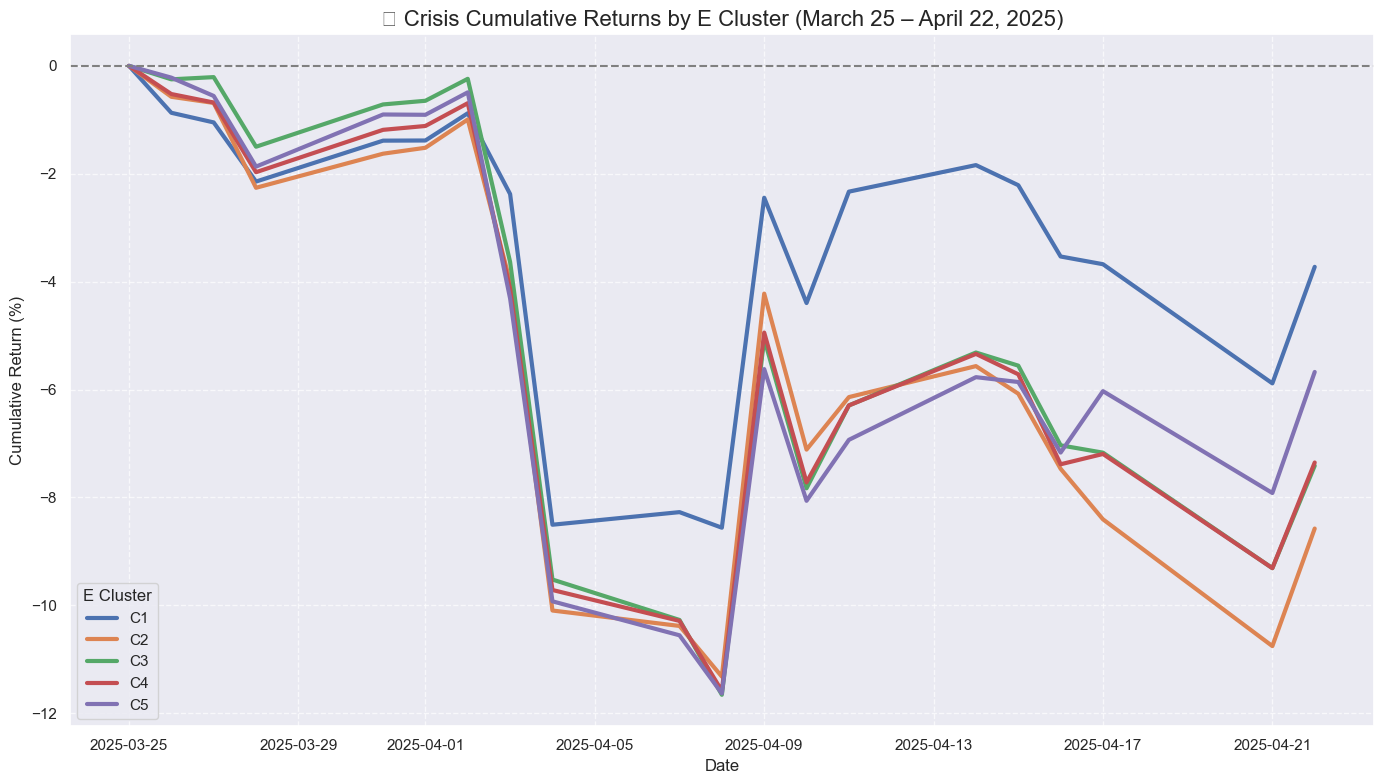

In [422]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# --- Step 1: Fix price Data ---
prices = prices.drop(columns=['BRK'], errors='ignore')

# --- Step 2: Merge Cluster Info ---
tickers_cluster = cluster_df[['Ticker', 'Cluster']].drop_duplicates()

# Only keep tickers we have prices for
tickers_cluster = tickers_cluster[tickers_cluster['Ticker'].isin(prices.columns)]

# --- Step 3: Melt Prices ---
prices_melt = prices.reset_index().melt(id_vars='Date', var_name='Ticker', value_name='Price')

# Merge prices with clusters
prices_melt = prices_melt.merge(tickers_cluster, on='Ticker', how='left')

# --- Step 4: Restrict to March 25 – April 22, 2025 ---
prices_melt = prices_melt[(prices_melt['Date'] >= '2025-03-25') & (prices_melt['Date'] <= '2025-04-22')]

# --- Step 5: Recalculate Cumulative Returns (correct scaling) ---
prices_melt['First_Price'] = prices_melt.groupby('Ticker')['Price'].transform('first')
prices_melt['Cumulative_Return'] = (prices_melt['Price'] / prices_melt['First_Price'] - 1) * 100

# --- Step 6: Average Return per Cluster ---
avg_cum_returns = prices_melt.groupby(['Date', 'Cluster'])['Cumulative_Return'].mean().reset_index()

# --- Step 7: Plot ---
plt.figure(figsize=(14, 8))
sns.lineplot(data=avg_cum_returns, x='Date', y='Cumulative_Return', hue='Cluster', linewidth=3)

plt.axhline(0, color='grey', linestyle='--')
plt.title('📈 Crisis Cumulative Returns by E Cluster (March 25 – April 22, 2025)', fontsize=16)
plt.ylabel('Cumulative Return (%)')
plt.xlabel('Date')
plt.legend(title='E Cluster')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


**** BOOTSTRAPPING 6.4 ****

In [424]:
pip install joblib


Note: you may need to restart the kernel to use updated packages.


# bootstrapping with same constraints 

In [561]:
# --- Libraries ---
import yfinance as yf
import pandas as pd
import numpy as np
from tqdm import tqdm
from scipy.optimize import minimize

# --- PARAMETERS ---
start_date = '2016-01-01'
end_date = '2024-12-31'
MIN_TICKERS = 5  # ✅ Minimum tickers per portfolio enforced

# --- STEP 0: Load and clean cluster_df ---

cluster_df = pd.read_csv('Clustering_Data.csv')

if 'Unnamed: 0' in cluster_df.columns:
    cluster_df = cluster_df.drop(columns=['Unnamed: 0'])

cluster_df['Ticker'] = cluster_df['Ticker'].astype(str)

# --- STEP 1: Prepare Tickers ---

tickers_list = cluster_df['Ticker'].dropna().unique().tolist()

if len(tickers_list) == 0:
    raise ValueError("🚨 No tickers found!")

print(f"✅ Number of tickers to download: {len(tickers_list)}")

# --- STEP 2: Download Price Data ---

price_data = pd.DataFrame()
failed_tickers = []
used_close_tickers = []

print("\n🚀 Downloading price data...")
for ticker in tqdm(tickers_list):
    try:
        df = yf.download(ticker, start=start_date, end=end_date, progress=False)
        if not df.empty:
            if 'Adj Close' in df.columns:
                price_data[ticker] = df['Adj Close']
            elif 'Close' in df.columns:
                price_data[ticker] = df['Close']
                used_close_tickers.append(ticker)
            else:
                failed_tickers.append(ticker)
        else:
            failed_tickers.append(ticker)
    except Exception as e:
        failed_tickers.append(ticker)

print("\n✅ Download completed.")

# --- STEP 3: Compute Daily Returns ---

if price_data.empty:
    raise ValueError("🚨 No price data!")

daily_returns = price_data.pct_change().dropna()
daily_returns.index = pd.to_datetime(daily_returns.index)
daily_returns.to_csv('daily_returns.csv')
print(f"✅ Daily returns saved! Shape: {daily_returns.shape}")

# --- STEP 4: Align cluster_df to Available Years ---

available_years = daily_returns.index.year.unique()
print(f"\n✅ Available years from daily_returns: {available_years}")

cluster_df = cluster_df[cluster_df['Year'].isin(available_years)]

# --- STEP 5: Helper Functions ---

def cvar_loss(weights, returns, alpha=0.05):
    portfolio_returns = returns @ weights
    var = np.percentile(portfolio_returns, alpha * 100)
    cvar = portfolio_returns[portfolio_returns <= var].mean()
    return cvar

def volatility_loss(weights, returns):
    portfolio_returns = returns @ weights
    return portfolio_returns.std()

def optimize_portfolio(returns, method='cvar', min_tickers=MIN_TICKERS):
    tickers = returns.columns.tolist()
    
    # If too few tickers, return equal weighting
    if len(tickers) < min_tickers:
        print(f"⚠️ Only {len(tickers)} tickers available, using Equal Weights.")
        return np.ones(len(tickers)) / len(tickers), "Equal Weight Fallback"
    
    bounds = [(0, 1)] * len(tickers)
    constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
    x0 = np.ones(len(tickers)) / len(tickers)
    
    if method == 'cvar':
        objective = lambda w: cvar_loss(w, returns)
    elif method == 'volatility':
        objective = lambda w: volatility_loss(w, returns)
    else:
        raise ValueError("Unknown optimization method.")

    result = minimize(objective, x0, bounds=bounds, constraints=constraints, method='SLSQP')

    if result.success:
        return result.x, "CVaR Optimized" if method == 'cvar' else "Volatility Optimized"
    else:
        # Try volatility fallback
        if method == 'cvar':
            try:
                result_vol = minimize(lambda w: volatility_loss(w, returns), x0, bounds=bounds, constraints=constraints, method='SLSQP')
                if result_vol.success:
                    return result_vol.x, "Volatility Fallback"
            except:
                pass
        print(f"⚠️ Optimization failed completely, using Equal Weights.")
        return np.ones(len(tickers)) / len(tickers), "Equal Weight Fallback"

# --- STEP 6: Main Bootstrapping & Optimization ---

bootstrap_results = []

years = cluster_df['Year'].unique()
clusters = cluster_df['Cluster'].unique()

print("\n🚀 Bootstrapping and optimizing portfolios...")
for year in tqdm(years):
    for cluster in clusters:
        tickers = cluster_df[(cluster_df['Year'] == year) & (cluster_df['Cluster'] == cluster)]['Ticker'].tolist()

        returns_subset = daily_returns[tickers].dropna(axis=1, how='any')

        if len(returns_subset.columns) < 2:
            print(f"⚠️ Skipping Year {year} Cluster {cluster}: Not enough tickers.")
            continue

        weights, status = optimize_portfolio(returns_subset, method='cvar')

        for ticker, weight in zip(returns_subset.columns, weights):
            bootstrap_results.append({
                'Year': year,
                'Cluster': cluster,
                'Ticker': ticker,
                'Bootstrap_Weight': weight,
                'Optimization_Method': status
            })

print("\n✅ Bootstrapping and Optimization Completed.")

# --- STEP 7: Save Results ---

bootstrap_df = pd.DataFrame(bootstrap_results)
bootstrap_df.to_csv('Bootstrap_Shapley_Optimized_Minimalistic_V4.csv', index=False)

print("\n✅ Saved bootstrap results to 'Bootstrap_Shapley_Optimized_Minimalistic_V4.csv'.")


✅ Number of tickers to download: 87

🚀 Downloading price data...


100%|██████████| 87/87 [00:13<00:00,  6.43it/s]



✅ Download completed.
✅ Daily returns saved! Shape: (2262, 87)

✅ Available years from daily_returns: Index([2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024], dtype='int32', name='Date')

🚀 Bootstrapping and optimizing portfolios...


 12%|█▎        | 1/8 [00:00<00:03,  2.13it/s]

⚠️ Only 4 tickers available, using Equal Weights.


 25%|██▌       | 2/8 [00:01<00:03,  1.86it/s]

⚠️ Only 4 tickers available, using Equal Weights.


 75%|███████▌  | 6/8 [00:03<00:01,  1.73it/s]

⚠️ Only 3 tickers available, using Equal Weights.


 88%|████████▊ | 7/8 [00:03<00:00,  1.78it/s]

⚠️ Only 3 tickers available, using Equal Weights.


100%|██████████| 8/8 [00:04<00:00,  1.81it/s]


✅ Bootstrapping and Optimization Completed.

✅ Saved bootstrap results to 'Bootstrap_Shapley_Optimized_Minimalistic_V4.csv'.


In [565]:
# Align cluster years
available_years = daily_returns.index.year.unique()
cluster_df = cluster_df[cluster_df['Year'].isin(available_years)]


In [566]:
print("\n✅ Available years in daily_returns:")
print(sorted(daily_returns.index.year.unique()))

print("\n✅ Cluster years available:")
print(sorted(cluster_df['Year'].unique()))



✅ Available years in daily_returns:
[2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]

✅ Cluster years available:
[2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]


In [575]:
# --- Step 0: Load Required Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Load Data Properly ---

# Load original GARCH-optimized portfolio
optimized_df = pd.read_csv('Optimized_Portfolio_Results.csv')
print("✅ Loaded 'Optimized_Portfolio_Results.csv' successfully!")

# Load new Bootstrap Shapley optimized results (V3)
bootstrap_df = pd.read_csv('Bootstrap_Shapley_Optimized_Minimalistic_V4.csv')
print("✅ Loaded 'Bootstrap_Shapley_Optimized_Minimalistic_V4.csv' successfully!")

# Load daily returns (historical price returns)
daily_returns = pd.read_csv('daily_returns.csv', index_col=0, parse_dates=True)
print("✅ Loaded 'daily_returns.csv' successfully!")


✅ Loaded 'Optimized_Portfolio_Results.csv' successfully!
✅ Loaded 'Bootstrap_Shapley_Optimized_Minimalistic_V4.csv' successfully!
✅ Loaded 'daily_returns.csv' successfully!


In [576]:
# --- Step 2: Prepare Portfolio Weights ---

# 2.1 Original GARCH Weights
original_weights = optimized_df.pivot_table(
    index='Ticker',
    columns='Cluster',
    values='Weight',
    aggfunc='mean'  # If multiple dates per ticker, take the mean
).fillna(0)

# 2.2 Bootstrap Weights (from Bootstrap Minimalistic V3)

# Important: Bootstrap V3 has column 'Bootstrap_Weight'
bootstrap_weights = bootstrap_df.pivot_table(
    index='Ticker',
    columns='Cluster',
    values='Bootstrap_Weight',
    aggfunc='mean'
).fillna(0)

print("✅ Created GARCH and Bootstrap weight matrices.")

# 2.3 Align tickers across returns and both weight tables
common_tickers = list(set(daily_returns.columns) & set(original_weights.index) & set(bootstrap_weights.index))

daily_returns = daily_returns[common_tickers]
original_weights = original_weights.loc[common_tickers]
bootstrap_weights = bootstrap_weights.loc[common_tickers]

print(f"✅ Number of common tickers: {len(common_tickers)}")

# 2.4 Normalize weights per cluster (VERY IMPORTANT)
original_weights = original_weights.div(original_weights.sum(axis=0), axis=1)
bootstrap_weights = bootstrap_weights.div(bootstrap_weights.sum(axis=0), axis=1)

print("✅ Weights normalized per cluster.")


✅ Created GARCH and Bootstrap weight matrices.
✅ Number of common tickers: 87
✅ Weights normalized per cluster.


In [577]:
# --- Step 3: Apply Weights to Returns ---

# 3.1 Portfolio daily returns

original_portfolio_returns = daily_returns @ original_weights
bootstrap_portfolio_returns = daily_returns @ bootstrap_weights

print("✅ Computed daily portfolio returns for both GARCH and Bootstrap.")

# 3.2 Check shapes
print("\n🧠 Sanity Check:")
print(f"Original Portfolio Returns shape: {original_portfolio_returns.shape}")
print(f"Bootstrap Portfolio Returns shape: {bootstrap_portfolio_returns.shape}")

# (Optional) Preview a few lines
display(original_portfolio_returns.head())
display(bootstrap_portfolio_returns.head())


✅ Computed daily portfolio returns for both GARCH and Bootstrap.

🧠 Sanity Check:
Original Portfolio Returns shape: (2262, 5)
Bootstrap Portfolio Returns shape: (2262, 5)


Cluster           C1        C2        C3        C4        C5
Date                                                        
2016-01-05  0.001515  0.003653  0.002693  0.006043  0.004884
2016-01-06 -0.012585 -0.010430 -0.012666 -0.010038 -0.010805
2016-01-07 -0.028910 -0.021278 -0.021014 -0.020979 -0.026034
2016-01-08 -0.010608 -0.008218 -0.011532 -0.013168 -0.011790
2016-01-11 -0.000009  0.000936  0.003081  0.002028  0.005259

Cluster           C1        C2        C3        C4        C5
Date                                                        
2016-01-05 -0.006017  0.004195 -0.002653  0.000395 -0.000301
2016-01-06 -0.023476 -0.006552 -0.054732 -0.050565 -0.015259
2016-01-07 -0.040735 -0.029991 -0.057864 -0.049752 -0.046194
2016-01-08 -0.010129 -0.011022 -0.041460 -0.036857 -0.026141
2016-01-11 -0.008363 -0.004482  0.051049  0.029925  0.008187


✅ Performance Comparison Table:


Cluster  Sharpe_GARCH  Sortino_GARCH  CVaR_5%_GARCH  \
0      C1      1.188284       1.455114      -0.028321   
1      C2      1.098930       1.304799      -0.025703   
2      C3      1.105498       1.304575      -0.026104   
3      C4      1.097577       1.283081      -0.025521   
4      C5      1.004969       1.186229      -0.026405   

   Cumulative_Return_GARCH  Sharpe_Bootstrap  Sortino_Bootstrap  \
0                 5.504961          1.000104           1.307756   
1                 3.781737          1.108635           1.519937   
2                 3.863467          1.184161           1.781804   
3                 3.637480          1.305783           1.922865   
4                 3.342085          0.365402           0.465140   

   CVaR_5%_Bootstrap  Cumulative_Return_Bootstrap  
0          -0.035474                     5.590488  
1          -0.048378                    16.146371  
2          -0.058377                    40.951615  
3          -0.061536                    74.958086  
4          -0.048070                     0.808400

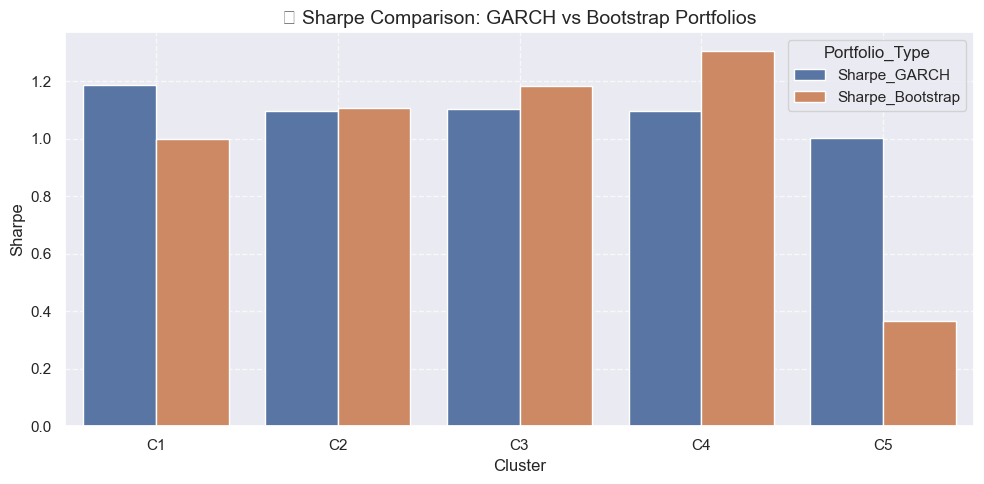

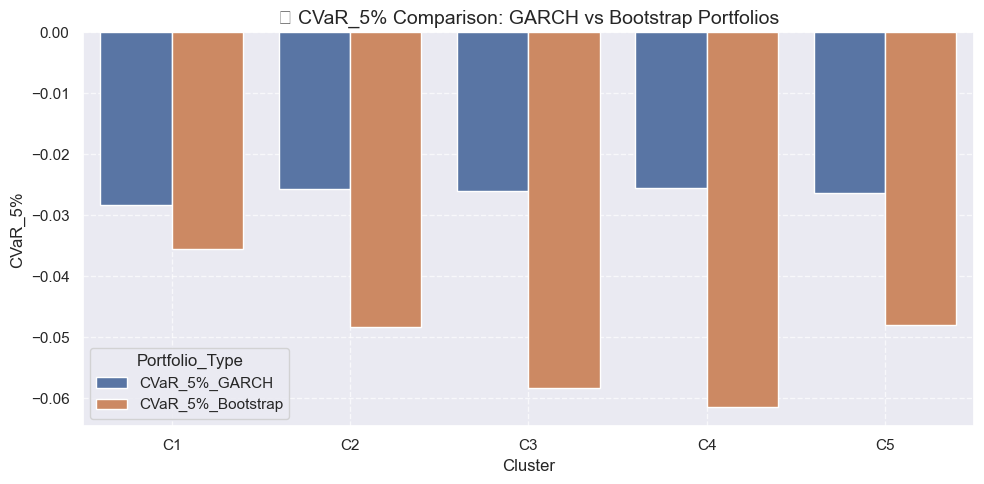


✅ Common clusters for cumulative plotting: ['C1', 'C2', 'C3', 'C4', 'C5']


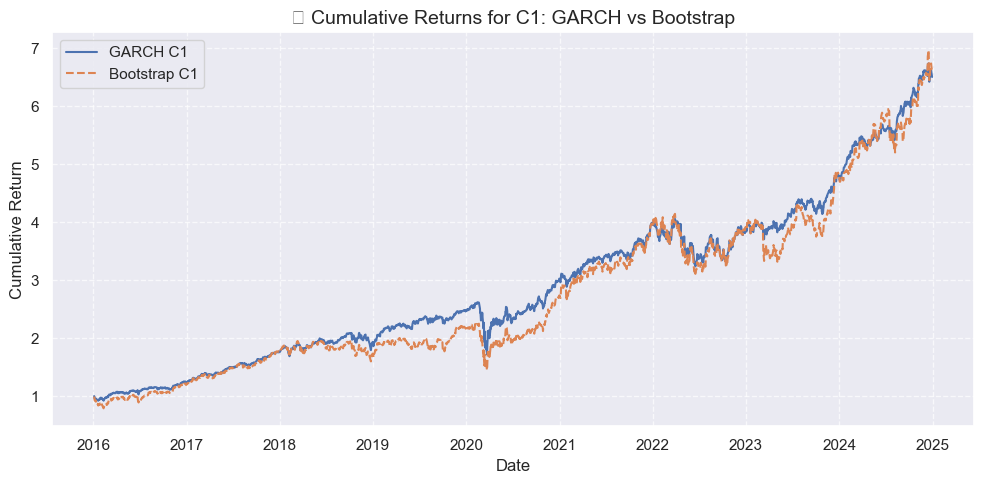

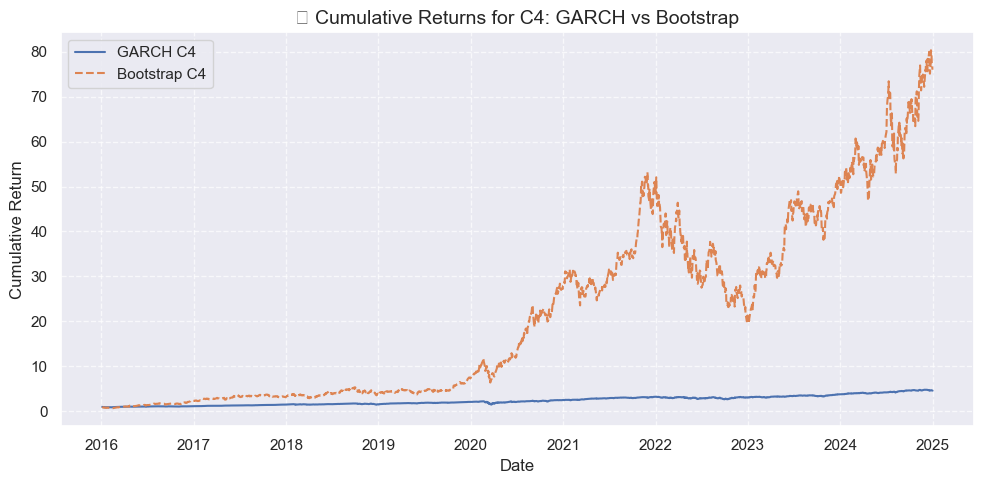

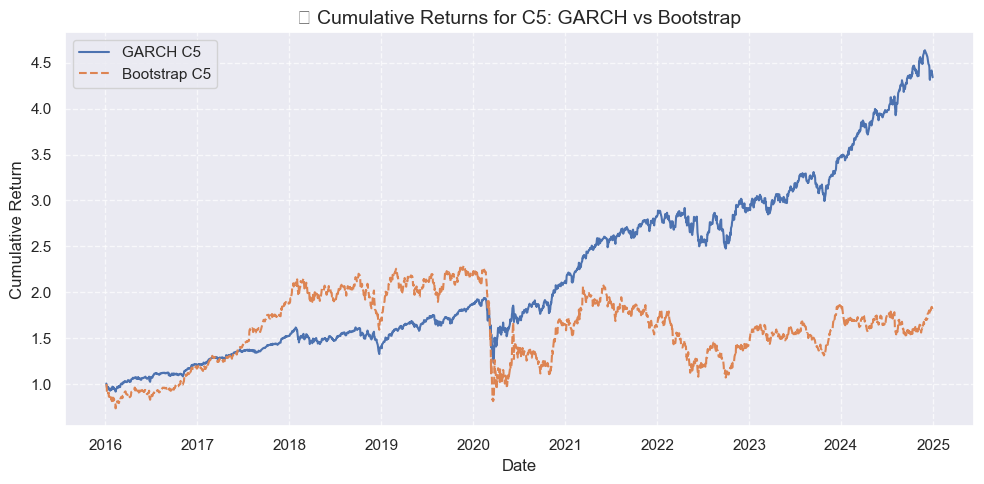

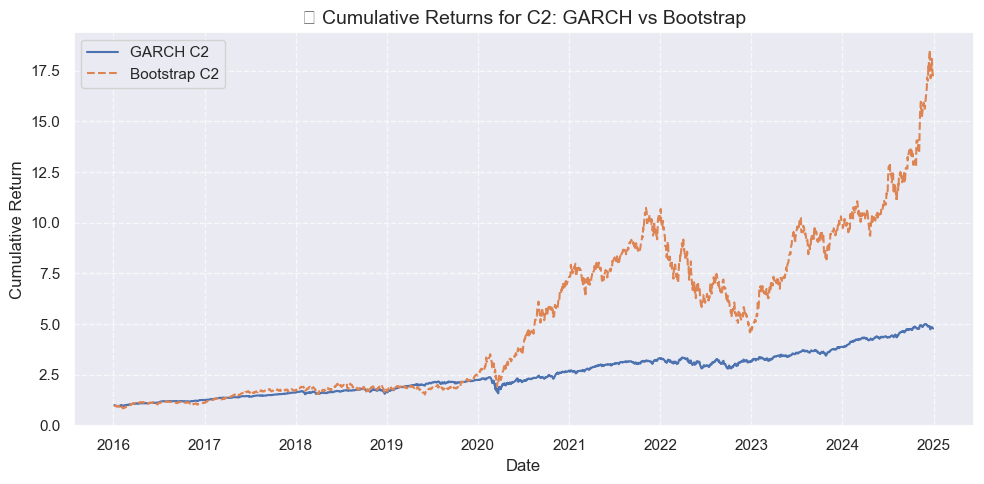

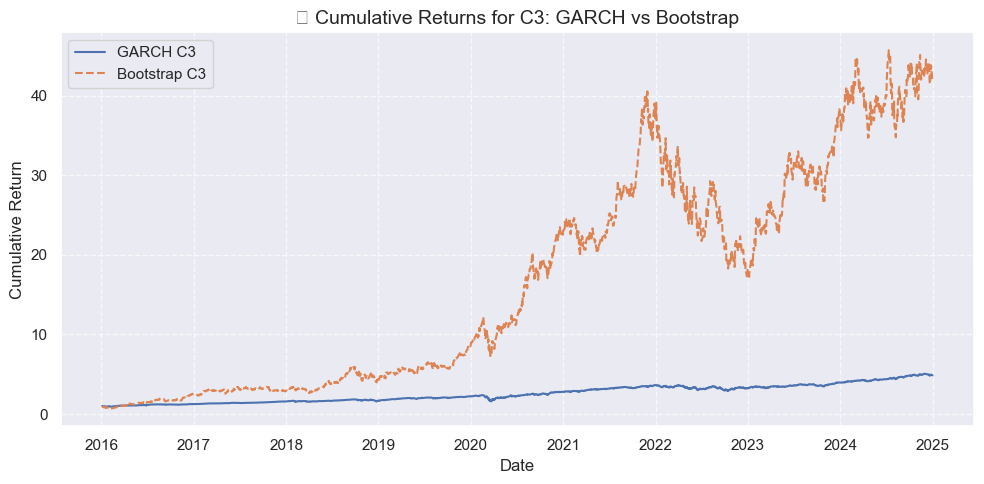

In [578]:
# --- Step 6: Compute Performance Metrics ---

def compute_metrics(portfolio_returns):
    metrics = {}
    for cluster in portfolio_returns.columns:
        returns = portfolio_returns[cluster].dropna()

        mean_return = returns.mean() * 252  # Annualized
        std_return = returns.std() * np.sqrt(252)  # Annualized
        sharpe = mean_return / std_return if std_return != 0 else np.nan

        downside_returns = returns[returns < 0]
        sortino = mean_return / (downside_returns.std() * np.sqrt(252)) if len(downside_returns) > 0 else np.nan

        cvar_5 = returns[returns <= returns.quantile(0.05)].mean()
        cumulative_return = (returns + 1).prod() - 1

        metrics[cluster] = {
            'Sharpe': sharpe,
            'Sortino': sortino,
            'CVaR_5%': cvar_5,
            'Cumulative_Return': cumulative_return
        }
    return pd.DataFrame(metrics).T

# --- Step 7: Apply to Both Portfolios ---

original_metrics = compute_metrics(original_portfolio_returns)
bootstrap_metrics = compute_metrics(bootstrap_portfolio_returns)

# --- Step 8: Merge into Comparison Table ---

comparison_df = original_metrics.join(
    bootstrap_metrics,
    lsuffix='_GARCH',
    rsuffix='_Bootstrap'
).reset_index().rename(columns={'index': 'Cluster'})

print("\n✅ Performance Comparison Table:")
display(comparison_df)

# --- Step 9: Plotting Barplots for Sharpe, Sortino, CVaR, Cumulative Return ---

metrics_to_plot = ['Sharpe', 'Sortino', 'CVaR_5%', 'Cumulative_Return']

for metric in metrics_to_plot:
    plt.figure(figsize=(10, 5))
    melted = comparison_df.melt(
        id_vars='Cluster',
        value_vars=[f'{metric}_GARCH', f'{metric}_Bootstrap'],
        var_name='Portfolio_Type',
        value_name=metric
    )
    sns.barplot(data=melted, x='Cluster', y=metric, hue='Portfolio_Type')
    plt.title(f"📊 {metric} Comparison: GARCH vs Bootstrap Portfolios", fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# --- Step 10: Plot Cumulative Return Curves per Cluster ---

cumulative_original = (original_portfolio_returns + 1).cumprod()
cumulative_bootstrap = (bootstrap_portfolio_returns + 1).cumprod()

common_clusters = list(set(cumulative_original.columns) & set(cumulative_bootstrap.columns))
print(f"\n✅ Common clusters for cumulative plotting: {sorted(common_clusters)}")

for cluster in common_clusters:
    plt.figure(figsize=(10, 5))
    plt.plot(cumulative_original.index, cumulative_original[cluster], label=f"GARCH {cluster}", linestyle='-')
    plt.plot(cumulative_bootstrap.index, cumulative_bootstrap[cluster], label=f"Bootstrap {cluster}", linestyle='--')
    plt.title(f"📈 Cumulative Returns for {cluster}: GARCH vs Bootstrap", fontsize=14)
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


In [579]:
# --- Step 11: Build a Colorful Performance Table ---

def highlight_performance(val, better='higher'):
    """
    Highlight better performance:
    - Green if Bootstrap is better
    - Red if Bootstrap is worse
    """
    color = ''
    if pd.isnull(val):
        color = 'background-color: white'
    else:
        if better == 'higher':
            color = 'background-color: lightgreen' if val > 0 else 'background-color: lightcoral'
        elif better == 'lower':
            color = 'background-color: lightgreen' if val < 0 else 'background-color: lightcoral'
    return color

# --- Step 11.1: Compute Differences ---

comparison_df['Sharpe_Diff'] = comparison_df['Sharpe_Bootstrap'] - comparison_df['Sharpe_GARCH']
comparison_df['Sortino_Diff'] = comparison_df['Sortino_Bootstrap'] - comparison_df['Sortino_GARCH']
comparison_df['CVaR_Diff'] = comparison_df['CVaR_5%_Bootstrap'] - comparison_df['CVaR_5%_GARCH']
comparison_df['Cumulative_Return_Diff'] = comparison_df['Cumulative_Return_Bootstrap'] - comparison_df['Cumulative_Return_GARCH']

# --- Step 11.2: Create Styler ---

styled = comparison_df.style.format(precision=3)

# Apply green/red highlights
styled = styled.applymap(lambda v: highlight_performance(v, 'higher'), subset=['Sharpe_Diff', 'Sortino_Diff', 'Cumulative_Return_Diff'])
styled = styled.applymap(lambda v: highlight_performance(v, 'lower'), subset=['CVaR_Diff'])  # CVaR lower is better!

# --- Step 11.3: Display ---

print("\n✅ Colorful Performance Improvement Table:")
display(styled)



✅ Colorful Performance Improvement Table:


In [580]:
# 6.5 overlapping 

In [581]:
# --- Step 12: Portfolio Composition Overlap ---

composition_overlap_results = []

for cluster in original_weights.columns:
    original_tickers = original_weights[cluster][original_weights[cluster] > 1e-6].index
    bootstrap_tickers = bootstrap_weights[cluster][bootstrap_weights[cluster] > 1e-6].index

    common_tickers = set(original_tickers) & set(bootstrap_tickers)
    total_original = len(original_tickers)
    total_bootstrap = len(bootstrap_tickers)
    overlap_count = len(common_tickers)

    overlap_percentage = overlap_count / max(total_original, total_bootstrap) * 100 if max(total_original, total_bootstrap) > 0 else np.nan

    composition_overlap_results.append({
        'Cluster': cluster,
        'Original_Ticker_Count': total_original,
        'Bootstrap_Ticker_Count': total_bootstrap,
        'Overlap_Ticker_Count': overlap_count,
        'Overlap_Percentage': overlap_percentage
    })

composition_overlap_df = pd.DataFrame(composition_overlap_results)

print("\n✅ Portfolio Composition Overlap Table:")
display(composition_overlap_df)



✅ Portfolio Composition Overlap Table:


Cluster  Original_Ticker_Count  Bootstrap_Ticker_Count  \
0      C1                      9                       7   
1      C2                     24                       4   
2      C3                     42                       4   
3      C4                     59                       4   
4      C5                     29                       2   

   Overlap_Ticker_Count  Overlap_Percentage  
0                     7           77.777778  
1                     3           12.500000  
2                     4            9.523810  
3                     3            5.084746  
4                     1            3.448276

In [582]:
# --- Bootstrap Ticker Count per Cluster ---

# Find tickers that have positive weights (> 1e-6) in Bootstrap portfolios
bootstrap_ticker_counts = []

for cluster in bootstrap_weights.columns:
    bootstrap_tickers = bootstrap_weights[cluster][bootstrap_weights[cluster] > 1e-6].index
    ticker_count = len(bootstrap_tickers)
    
    bootstrap_ticker_counts.append({
        'Cluster': cluster,
        'Bootstrap_Ticker_Count': ticker_count
    })

bootstrap_ticker_counts_df = pd.DataFrame(bootstrap_ticker_counts)

print("\n✅ Bootstrap Ticker Count per Cluster:")
display(bootstrap_ticker_counts_df)



✅ Bootstrap Ticker Count per Cluster:


Cluster  Bootstrap_Ticker_Count
0      C1                       7
1      C2                       4
2      C3                       4
3      C4                       4
4      C5                       2